In [137]:
pip install pmdarima

     |████████████████████████████████| 656 kB 3.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [339]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

warnings.filterwarnings('ignore')

# Load Data

In [1061]:
east = pd.read_csv('data/east_daily.csv')
midwest = pd.read_csv('data/midwest_daily.csv') 
south = pd.read_csv('data/south_daily.csv') 
west = pd.read_csv('data/west_daily.csv') 

# Check Stationarity

In [284]:
X = east.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.842138
p-value: 0.002504
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [285]:
X = midwest.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.473716
p-value: 0.122001
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [286]:
X = south.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.104854
p-value: 0.026196
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [287]:
X = west.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.816341
p-value: 0.055977
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Differencing

In [1048]:
midwest_stationary = midwest['date'].to_frame().join(midwest['daily_deaths'].diff(1).fillna(0))

In [1050]:
west_stationary = west['date'].to_frame().join(west['daily_deaths'].diff(1).fillna(0))

# Check Stationarity After Differencing

In [1051]:
X = midwest_stationary.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.612100
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [1053]:
X = west_stationary.daily_deaths
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.691688
p-value: 0.000001
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Split Data Into Train and Test

In [1062]:
east = east.set_index('date')
midwest = midwest.set_index('date')
south = south.set_index('date')
west = west.set_index('date')

In [1066]:
train_size = int(len(east) * 0.9)

east_train, east_test = east[0:train_size], east[train_size:]
print(east_train.shape, east_test.shape)

midwest_train, midwest_test = midwest[0:train_size], midwest[train_size:]
print(midwest_train.shape, midwest_test.shape)

south_train, south_test = south[0:train_size], south[train_size:]
print(south_train.shape, south_test.shape)

west_train, west_test = west[0:train_size], west[train_size:]
print(west_train.shape, west_test.shape)

(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)
(1022, 1) (114, 1)


In [1068]:
east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(south_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(west_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer')

TEST SET  TRAINING SET
date                              
2020-02-12       NaN           0.0
2020-02-13       NaN           0.0
2020-02-14       NaN           0.0
2020-02-15       NaN           0.0
2020-02-16       NaN           0.0
...              ...           ...
2023-03-19       0.0           NaN
2023-03-20      37.0           NaN
2023-03-21      33.0           NaN
2023-03-22     184.0           NaN
2023-03-23      89.0           NaN

[1136 rows x 2 columns]

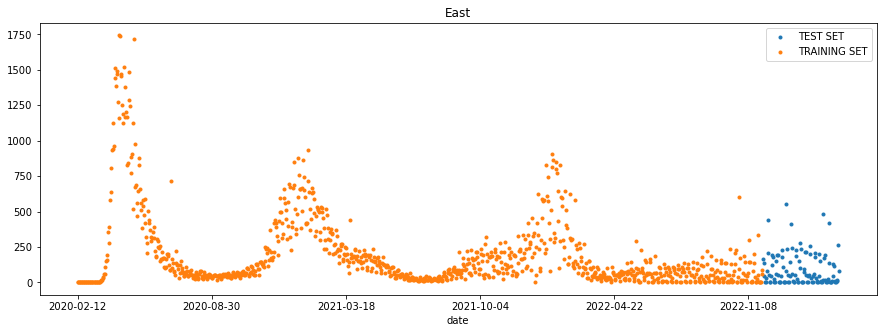

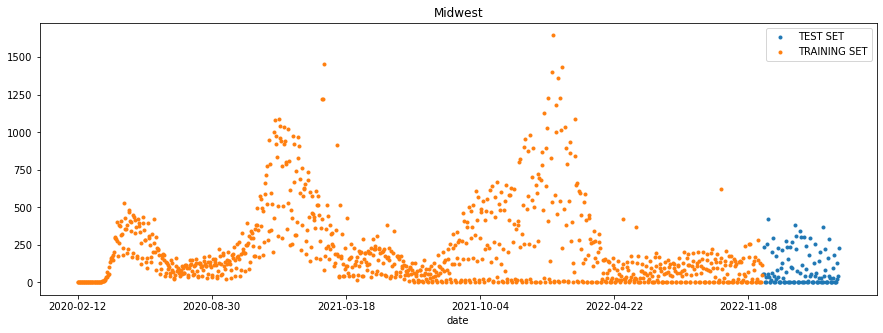

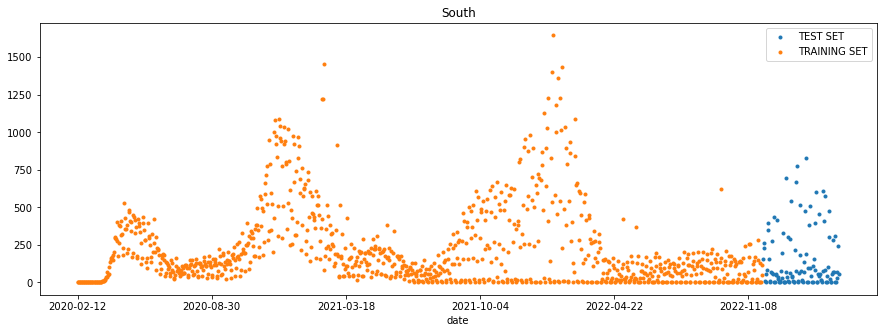

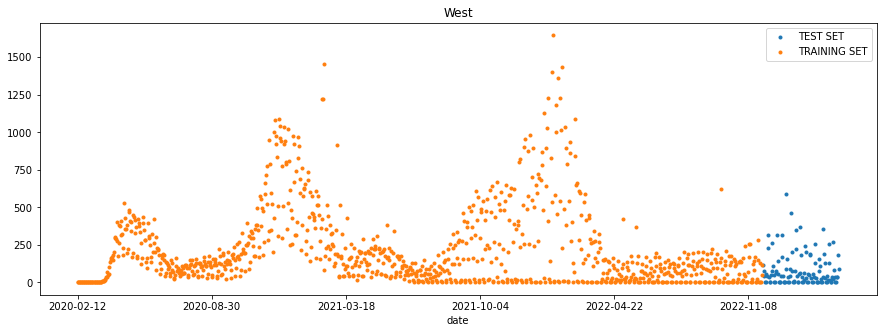

In [1069]:
_ = east_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(east_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='East', style='.')

_ = midwest_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Midwest', style='.')

_ = south_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='South', style='.')

_ = west_test \
    .rename(columns={'daily_deaths': 'TEST SET'}) \
    .join(midwest_train.rename(columns={'daily_deaths': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='West', style='.')

# ACF and PACF

### east

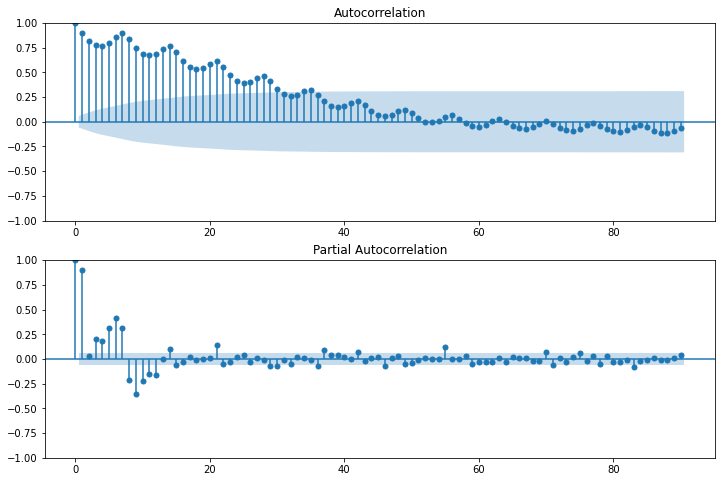

In [1070]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(east,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(east,lags=90,ax=ax2)

### midwest

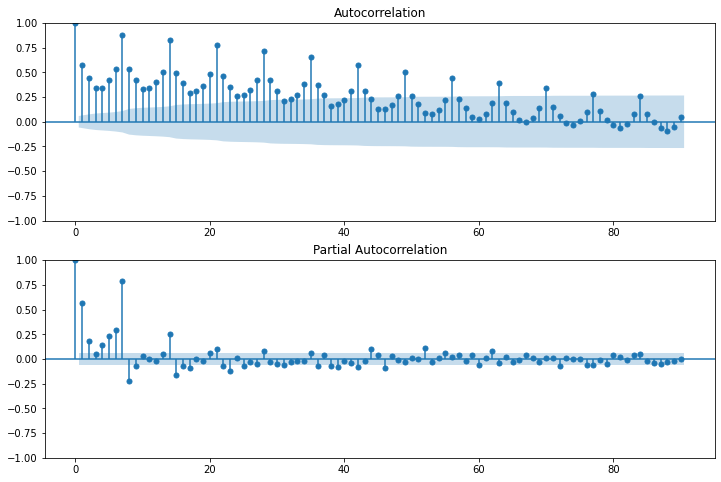

In [1071]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(midwest,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(midwest,lags=90,ax=ax2)

### south

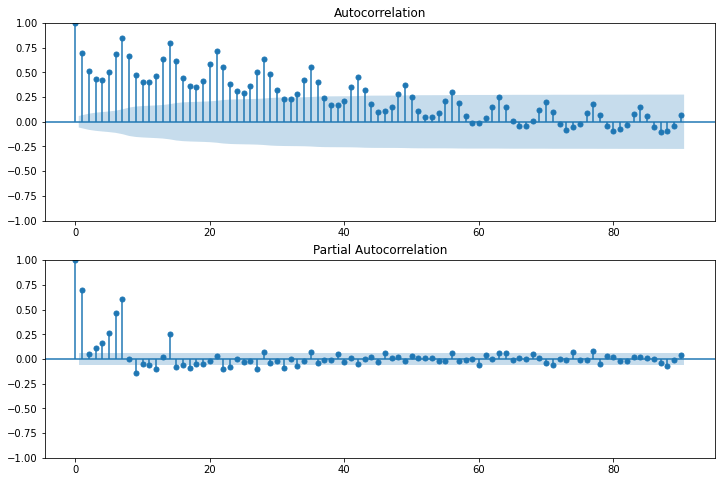

In [1072]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(south,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(south,lags=90,ax=ax2)

### west

MA(5) model
- ACF cut off at lag 5
- PACF tails off

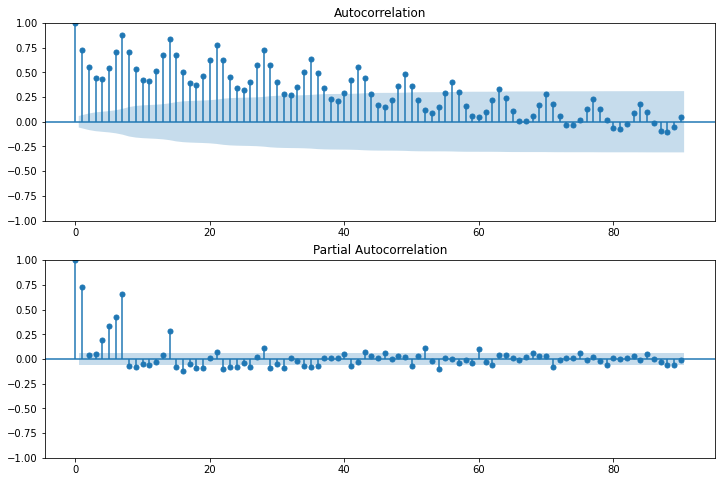

In [1073]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(west,lags=90,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(west,lags=90,ax=ax2)

# ARIMA Models (grid search p and q)

In [837]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = (1 / (n - 1)) * np.sum(np.abs(Actual.values[1:] - Actual.values[:-1]))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

# Grid Search p and q

### east

In [1043]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
48  6  6  11800.445572
41  5  6  11850.802397
47  6  5  11880.336364
40  5  5  11891.908581
33  4  5  11901.431019
26  3  5  11902.678270
39  5  4  11903.549108
27  3  6  11903.933034
34  4  6  11905.450196
46  6  4  11960.565424
44  6  2  11962.957687
45  6  3  11965.641160
37  5  2  12016.985360
32  4  4  12019.444256
24  3  3  12027.195774
25  3  4  12029.635327
30  4  2  12073.746497
31  4  3  12083.189447
43  6  1  12152.529788
20  2  6  12158.521578
42  6  0  12180.746612
13  1  6  12182.622521
19  2  5  12195.805642
12  1  5  12208.567043
18  2  4  12209.989462
36  5  1  12243.971171
17  2  3  12260.905697
11  1  4  12307.445470
29  4  1  12328.592672
35  5  0  12351.407159
22  3  1  12353.494338
38  5  3  12371.939242
10  1  3  12379.417074
16  2  2  12381.431648
9   1  2  12383.470539
23  3  2  12447.937551
28  4  0  12448.209437
21  3  0  12475.857072
15  2  1  12518.578198
7   1  0  12520.989580
8   1  1  12522.338681
14  2  0  12522.655830
5   0  5  12597.621601
6   0  6  12599.607503
4   0  4  12671.147010
3   0  3  12899.533789
2   0  2  13056.429564
1   0  1  13428.904826
0   0  0  14336.038947

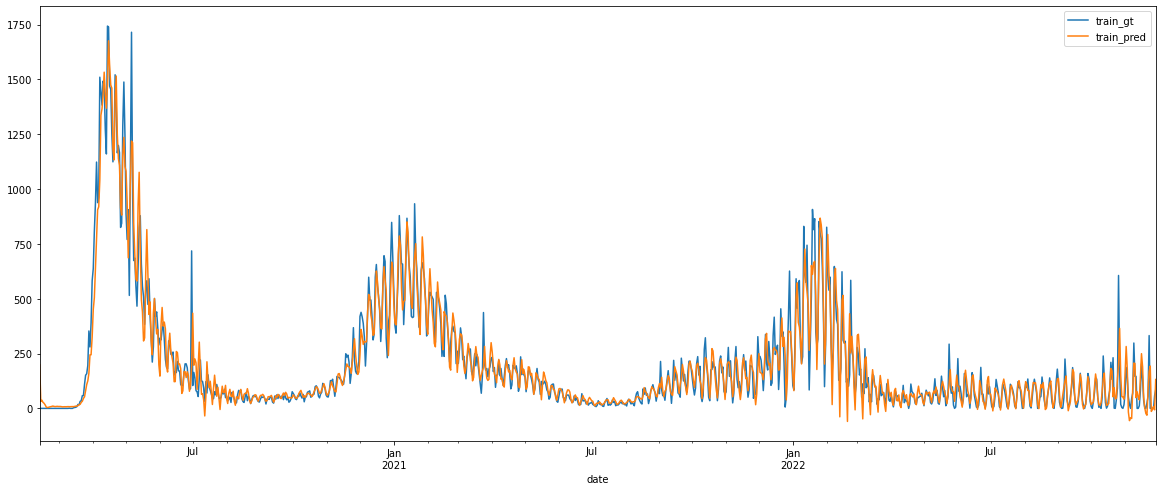

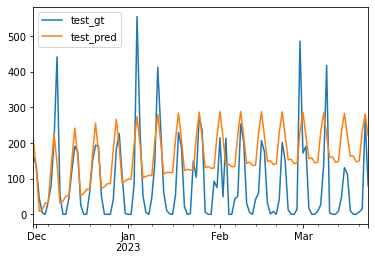

Training Set Metrics:
R-squared: 0.6506617364130307
MAE: 45.673374034029656
MASE: 0.7005139763064531

Testing Set Metrics:
MAE: 98.38039679947812
MASE: 1.1108098359653304


In [1044]:
model = sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(6,0,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

trying with one difference

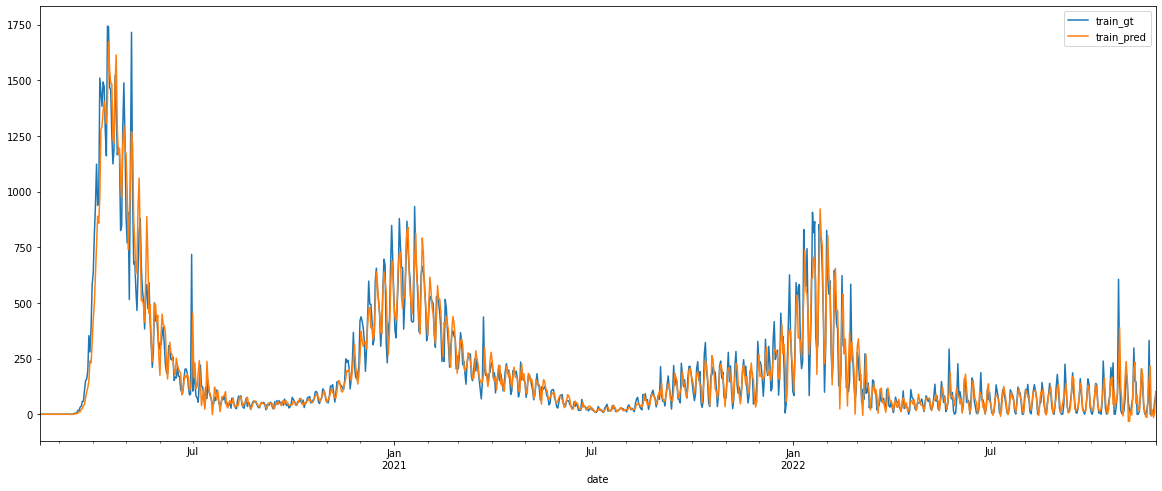

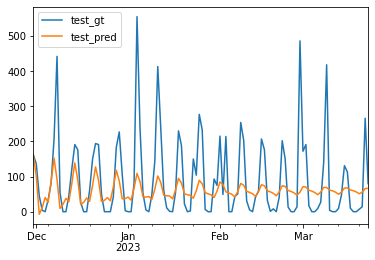

Training Set Metrics:
R-squared: 0.6506617364130307
MAE: 45.200839135512716
MASE: 0.6932664867634857

Testing Set Metrics:
MAE: 70.0386259275723
MASE: 0.7908038299176329


In [1045]:
model = sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
test_pred = test_pred * 2
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1046]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
41  5  6  11794.699914
34  4  6  11838.346423
48  6  6  11839.669618
47  6  5  11843.410448
46  6  4  11845.729041
39  5  4  11868.401756
40  5  5  11875.728325
32  4  4  11879.747778
33  4  5  11881.988769
20  2  6  11886.737025
26  3  5  11887.095317
19  2  5  11887.594189
27  3  6  11888.317229
44  6  2  11898.635882
38  5  3  11928.510325
45  6  3  11931.804347
37  5  2  11942.084444
31  4  3  11943.464347
25  3  4  12006.997907
17  2  3  12014.475052
18  2  4  12015.397262
43  6  1  12069.390322
24  3  3  12071.776765
42  6  0  12084.627046
36  5  1  12138.213616
13  1  6  12155.924965
35  5  0  12167.501869
6   0  6  12175.973476
12  1  5  12189.506336
5   0  5  12199.862971
11  1  4  12204.752614
29  4  1  12230.495135
10  1  3  12258.593168
4   0  4  12296.586301
22  3  1  12316.176021
15  2  1  12341.698707
28  4  0  12343.684066
3   0  3  12368.222642
9   1  2  12370.266360
2   0  2  12372.314546
8   1  1  12419.273209
21  3  0  12449.221165
14  2  0  12484.964094
30  4  2  12492.864007
23  3  2  12509.384871
16  2  2  12510.677625
1   0  1  12543.212848
7   1  0  12547.817839
0   0  0  12549.675638

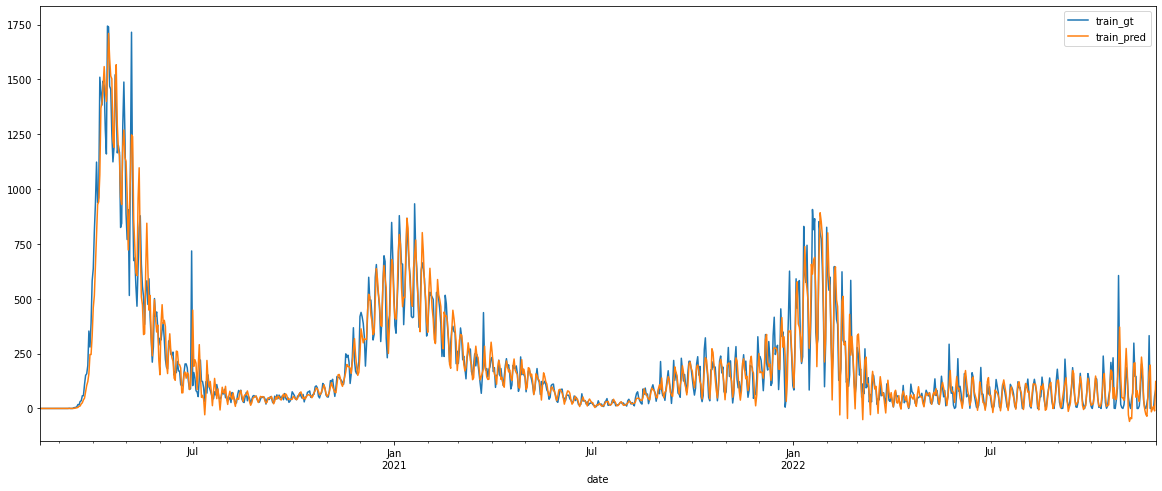

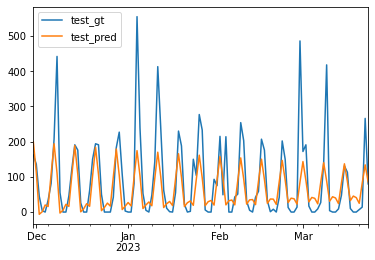

Training Set Metrics:
R-squared: 0.9185244924264576
MAE: 45.03536333134728
MASE: 0.6907285066818725

Testing Set Metrics:
MAE: 54.50067439674024
MASE: 0.6153653284204283


In [1047]:
model = sm.tsa.arima.ARIMA(east_train['daily_deaths'],order=(5,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

### midwest

In [1074]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
48  6  6  12630.472775
47  6  5  12639.272292
46  6  4  12643.034159
44  6  2  12645.053063
45  6  3  12645.222265
43  6  1  12657.731421
42  6  0  12694.283463
40  5  5  13113.958449
39  5  4  13166.680678
38  5  3  13179.849296
41  5  6  13182.642778
33  4  5  13242.161590
20  2  6  13246.130898
37  5  2  13262.301142
34  4  6  13278.539809
32  4  4  13283.736152
26  3  5  13297.041498
31  4  3  13320.824759
27  3  6  13321.255134
19  2  5  13330.788883
13  1  6  13348.631787
36  5  1  13356.358135
6   0  6  13370.618668
25  3  4  13379.900089
23  3  2  13408.166273
18  2  4  13430.702417
5   0  5  13430.862016
11  1  4  13431.835695
30  4  2  13437.536071
4   0  4  13438.466969
12  1  5  13442.815968
29  4  1  13468.747764
24  3  3  13499.649542
17  2  3  13502.882377
10  1  3  13549.475158
22  3  1  13552.923832
16  2  2  13602.286319
9   1  2  13603.556008
15  2  1  13621.241690
2   0  2  13628.551609
3   0  3  13630.405993
8   1  1  13632.140564
1   0  1  13657.313667
35  5  0  13669.571048
28  4  0  13782.435057
21  3  0  13864.618463
14  2  0  13917.062416
7   1  0  13951.112645
0   0  0  14081.354664

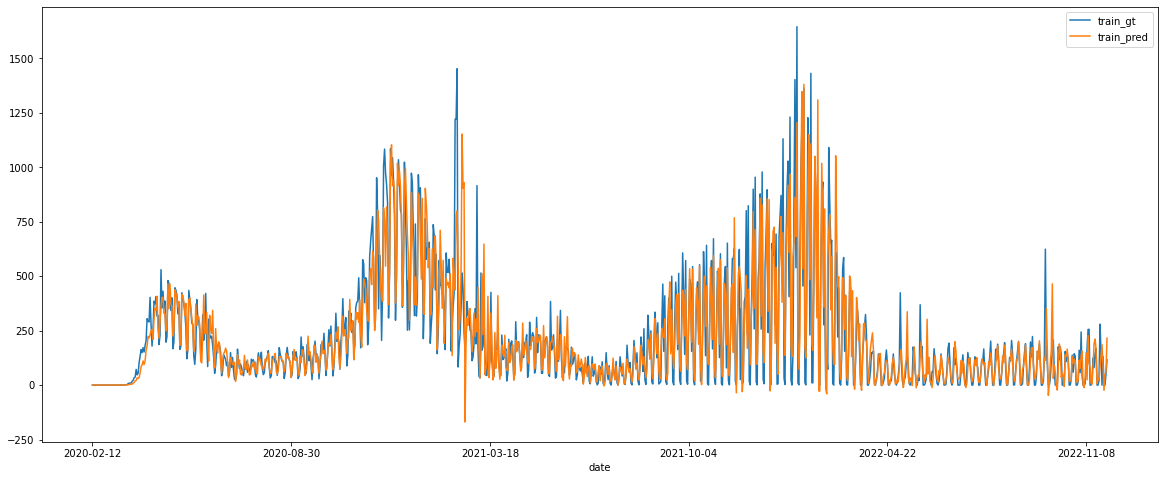

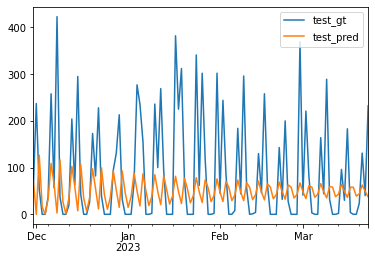

Training Set Metrics:
MAE: 67.6821129215094
MASE: 0.49642560662103336

Testing Set Metrics:
MAE: 79.45209092286146
MASE: 0.6866080050690843


In [1080]:
model = sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
#test_pred = test_pred * 1.5
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

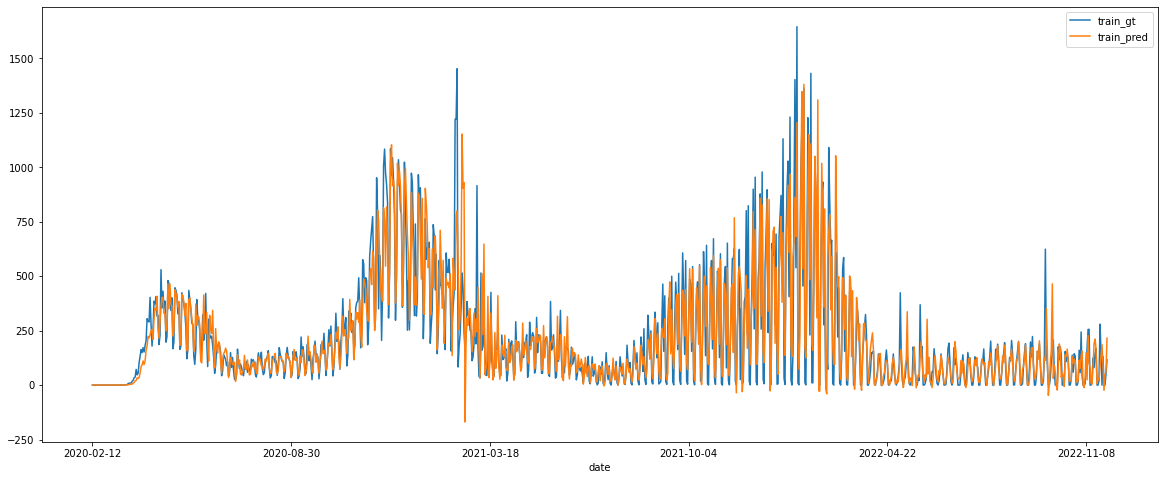

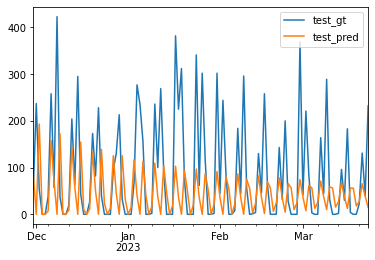

Training Set Metrics:
MAE: 67.6821129215094
MASE: 0.49642560662103336

Testing Set Metrics:
MAE: 77.2233070161166
MASE: 0.6673473304390621


In [1112]:
model = sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
test_pred = test_pred - 30
test_pred = test_pred * 2
test_pred[test_pred<0] = 0
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

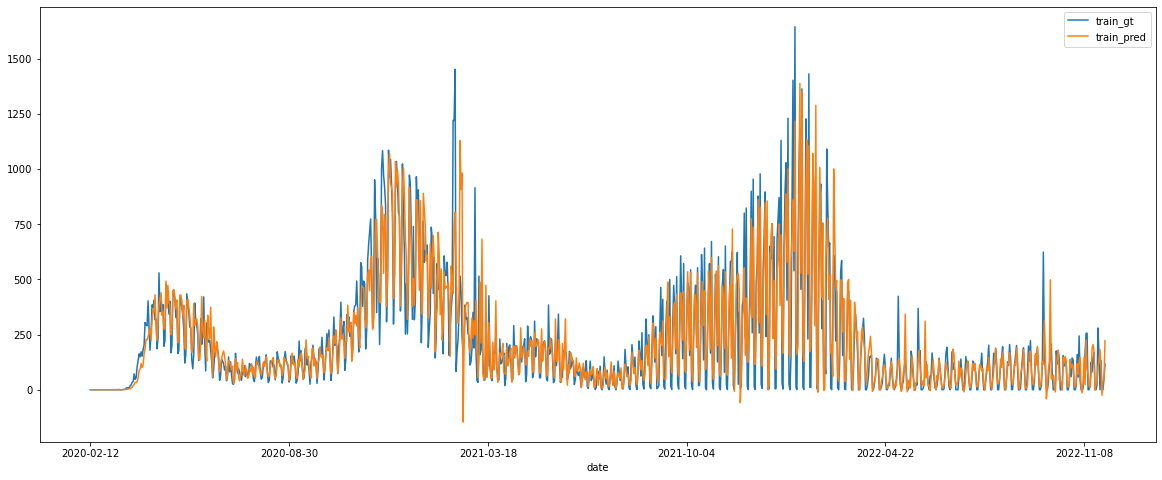

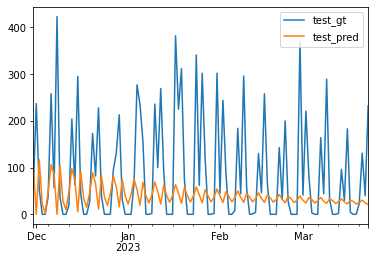

Training Set Metrics:
MAE: 68.71216887524825
MASE: 0.5039807216967318

Testing Set Metrics:
MAE: 80.3092137534714
MASE: 0.6940150775575304


In [1107]:
model = sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(6,2,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
#test_pred = test_pred * 1.5
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1081]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(p,2,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
46  6  4  12646.661544
48  6  6  12646.797219
47  6  5  12653.925973
45  6  3  12656.894940
44  6  2  12658.372801
43  6  1  12696.208947
42  6  0  13055.853512
32  4  4  13338.358922
5   0  5  13438.501055
13  1  6  13442.496426
20  2  6  13467.662287
6   0  6  13485.612928
11  1  4  13551.118618
41  5  6  13565.039351
31  4  3  13575.928601
38  5  3  13576.596721
39  5  4  13586.874467
12  1  5  13603.334891
10  1  3  13604.343809
3   0  3  13615.749628
9   1  2  13619.566953
4   0  4  13632.846321
33  4  5  13633.396907
34  4  6  13637.267154
40  5  5  13639.225474
2   0  2  13658.079548
36  5  1  13668.368633
24  3  3  13704.821504
18  2  4  13713.439683
37  5  2  13715.961376
30  4  2  13716.846126
26  3  5  13729.980024
19  2  5  13742.165700
17  2  3  13762.858722
29  4  1  13780.562274
27  3  6  13852.209562
22  3  1  13862.173653
16  2  2  13888.127734
25  3  4  13892.829432
15  2  1  13914.158409
23  3  2  13918.130237
8   1  1  13947.926166
1   0  1  14077.414076
28  4  0  14292.695648
35  5  0  14292.737958
21  3  0  14360.428901
14  2  0  14443.609270
7   1  0  14601.099932
0   0  0  15080.660635

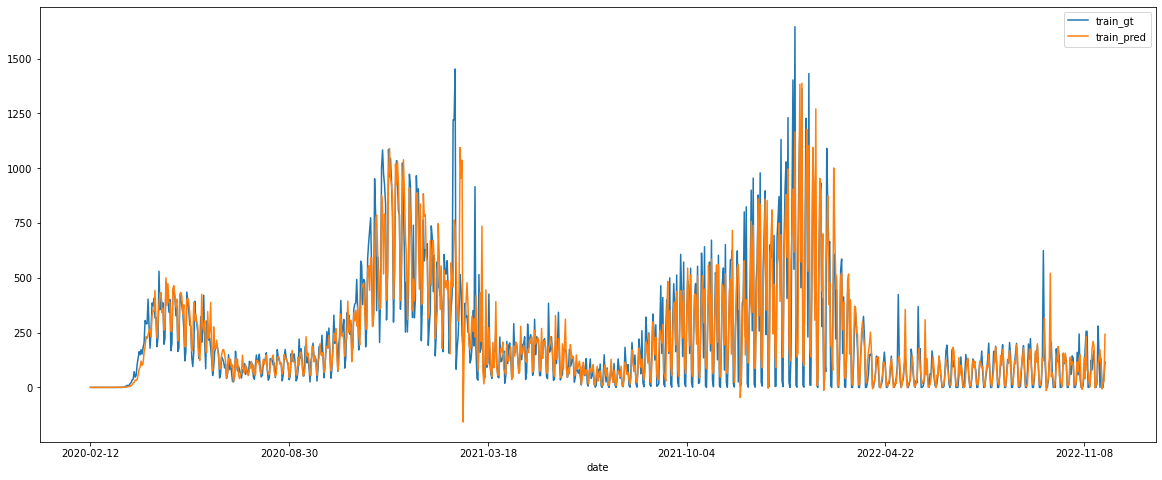

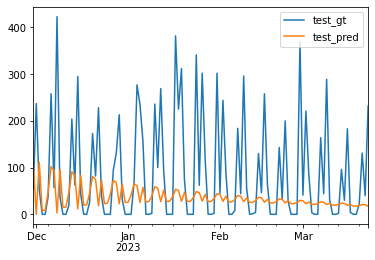

Training Set Metrics:
MAE: 67.6707299086543
MASE: 0.4963421160381031

Testing Set Metrics:
MAE: 79.26121162757828
MASE: 0.6849584669559763


In [1084]:
model = sm.tsa.arima.ARIMA(midwest_train['daily_deaths'],order=(6,2,4))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

### south

In [1021]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
47  6  5  13766.923601
48  6  6  13767.072344
46  6  4  13808.822345
41  5  6  13820.829905
40  5  5  13851.555699
44  6  2  13908.078246
39  5  4  13924.070243
25  3  4  13969.786373
33  4  5  13976.741487
27  3  6  13977.713714
34  4  6  13984.004583
26  3  5  13984.293609
43  6  1  14013.893309
45  6  3  14017.108393
37  5  2  14021.959453
32  4  4  14032.798224
23  3  2  14190.517540
36  5  1  14222.360196
20  2  6  14236.949101
42  6  0  14239.817935
13  1  6  14250.662187
19  2  5  14259.602145
12  1  5  14276.484290
18  2  4  14279.486439
11  1  4  14292.867390
29  4  1  14325.247551
22  3  1  14385.667124
24  3  3  14390.016651
9   1  2  14419.919164
16  2  2  14421.837117
17  2  3  14436.718079
38  5  3  14441.104111
30  4  2  14503.164523
35  5  0  14506.284838
28  4  0  14569.416988
5   0  5  14570.704969
4   0  4  14572.899466
21  3  0  14591.411705
10  1  3  14603.158305
7   1  0  14603.718409
8   1  1  14604.473626
14  2  0  14604.942471
15  2  1  14605.368536
31  4  3  14623.393763
3   0  3  14628.978176
2   0  2  14692.230932
6   0  6  14705.220133
1   0  1  14820.569982
0   0  0  15288.411602

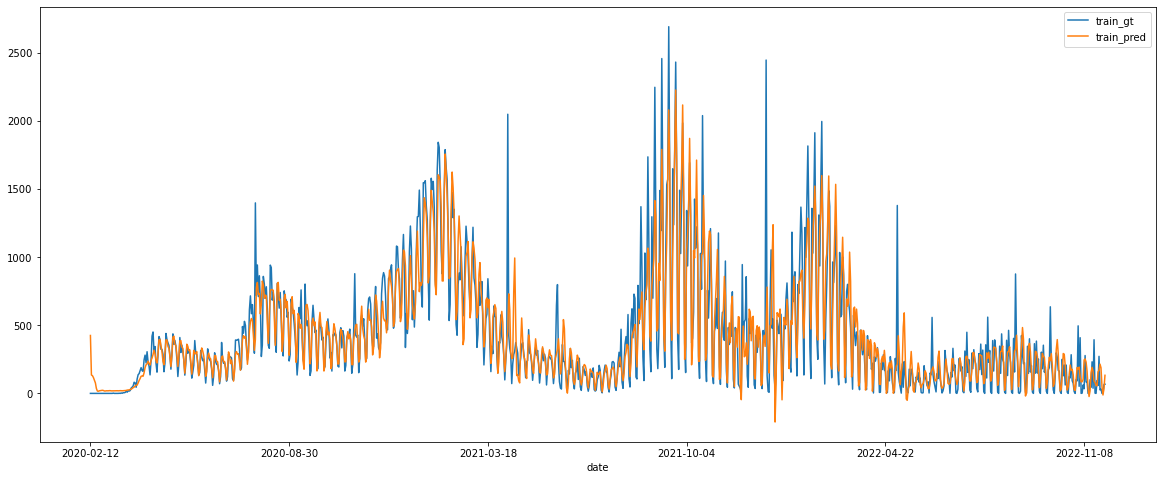

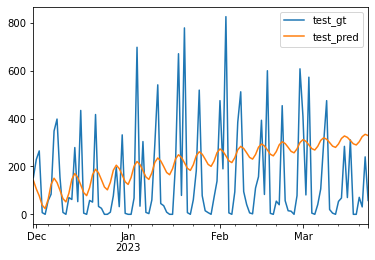

Training Set Metrics:
MAE: 118.53238085779554
MASE: 0.5790865501481396

Testing Set Metrics:
MAE: 178.18747826399175
MASE: 0.9218140843213418


In [1086]:
model = sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(6,0,5))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

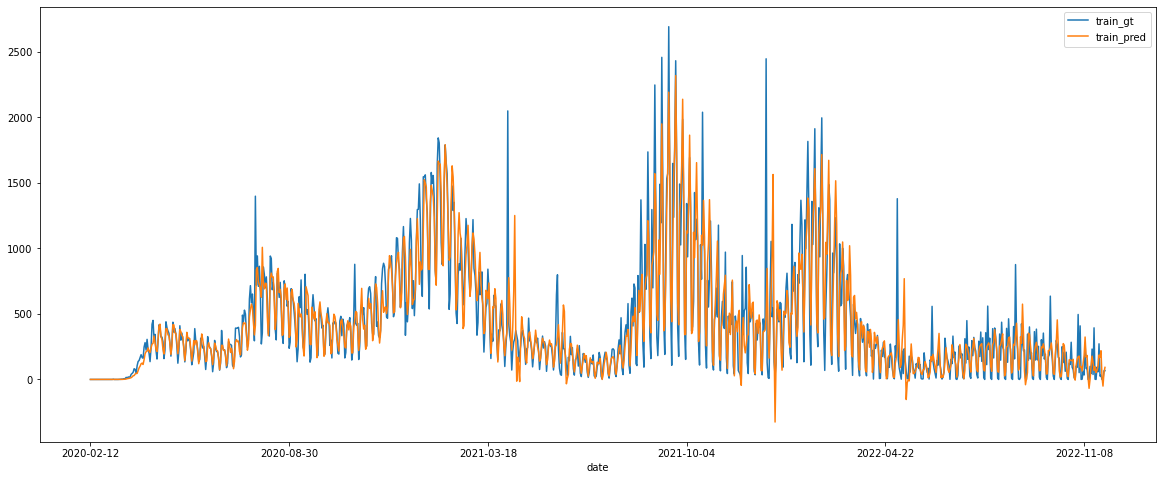

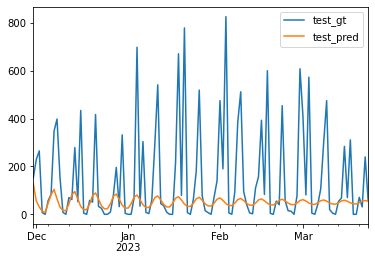

Training Set Metrics:
MAE: 114.56522833605325
MASE: 0.5597051401814963

Testing Set Metrics:
MAE: 124.69837903300031
MASE: 0.645099886953671


In [1087]:
model = sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(6,1,5))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1028]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
48  6  6  13691.965504
47  6  5  13700.398448
46  6  4  13705.530740
44  6  2  13738.629887
45  6  3  13739.944455
42  6  0  13753.338087
41  5  6  13753.528866
43  6  1  13755.313100
40  5  5  13757.925840
39  5  4  13774.456337
34  4  6  13811.094377
38  5  3  13816.742515
37  5  2  13821.393281
33  4  5  13840.432353
32  4  4  13857.428730
31  4  3  13884.579160
19  2  5  13909.458248
26  3  5  13933.389826
18  2  4  13939.935574
27  3  6  13948.246848
25  3  4  13960.226137
20  2  6  13965.186842
17  2  3  13966.196811
30  4  2  13968.934938
36  5  1  13996.352759
24  3  3  14010.812609
23  3  2  14112.513503
16  2  2  14180.623386
29  4  1  14199.881128
13  1  6  14222.528666
6   0  6  14229.907222
35  5  0  14233.415474
12  1  5  14247.341498
5   0  5  14264.354403
11  1  4  14267.349284
4   0  4  14279.802891
22  3  1  14310.048198
10  1  3  14312.628530
15  2  1  14370.859352
2   0  2  14405.416321
3   0  3  14407.206308
9   1  2  14407.341939
8   1  1  14436.116171
28  4  0  14524.196271
1   0  1  14533.908190
21  3  0  14614.906610
14  2  0  14667.215902
7   1  0  14721.767368
0   0  0  14751.020836

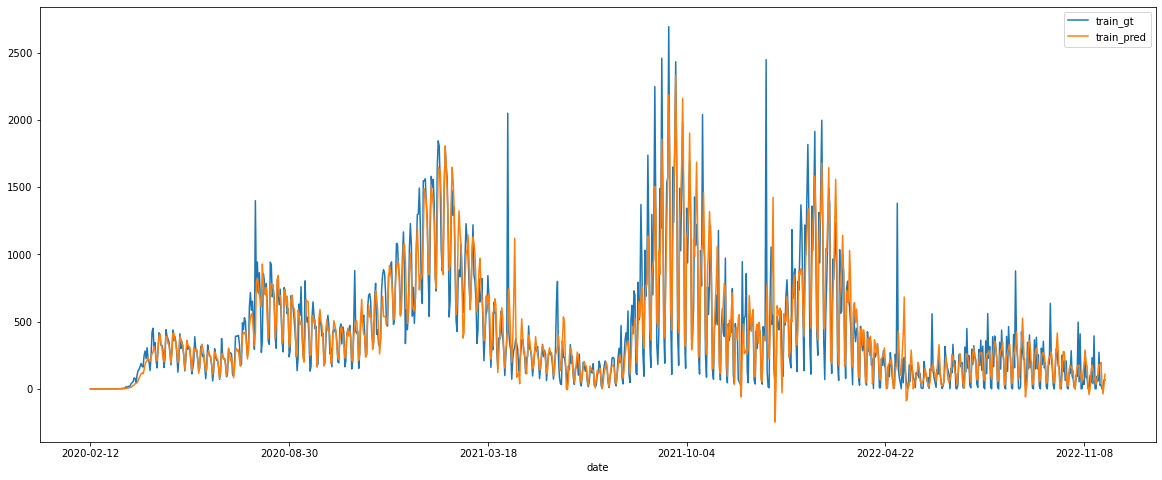

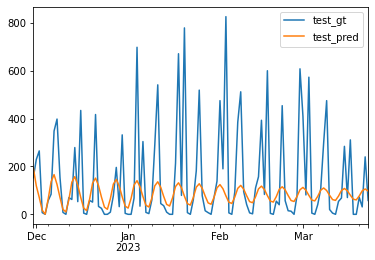

Training Set Metrics:
MAE: 115.66437949123166
MASE: 0.5650750116540623

Testing Set Metrics:
MAE: 118.7965734293231
MASE: 0.6145681819124439


In [1091]:
model = sm.tsa.arima.ARIMA(south_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)


### west

In [1092]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
48  6  6  12129.174671
47  6  5  12146.148748
46  6  4  12158.133332
44  6  2  12175.214099
45  6  3  12175.614082
43  6  1  12178.410534
42  6  0  12180.200129
41  5  6  12268.903209
40  5  5  12279.653852
37  5  2  12315.004659
19  2  5  12334.520470
39  5  4  12339.003889
31  4  3  12353.526762
38  5  3  12358.264670
24  3  3  12365.278023
20  2  6  12367.801510
18  2  4  12376.061542
25  3  4  12377.913813
26  3  5  12380.568361
17  2  3  12381.007805
33  4  5  12390.134550
34  4  6  12392.587880
27  3  6  12412.351925
32  4  4  12422.359033
36  5  1  12491.270603
23  3  2  12552.357705
29  4  1  12618.108693
30  4  2  12677.267586
13  1  6  12692.920819
12  1  5  12694.111478
6   0  6  12714.861752
5   0  5  12730.505844
11  1  4  12734.023586
35  5  0  12738.062363
22  3  1  12747.506894
4   0  4  12752.349529
15  2  1  12866.476179
10  1  3  12890.333860
3   0  3  12893.815578
9   1  2  12901.185628
2   0  2  12902.125817
16  2  2  12904.463799
8   1  1  12920.924692
28  4  0  12951.476802
1   0  1  13036.853113
21  3  0  13101.758210
14  2  0  13174.354703
7   1  0  13196.214718
0   0  0  13224.403623

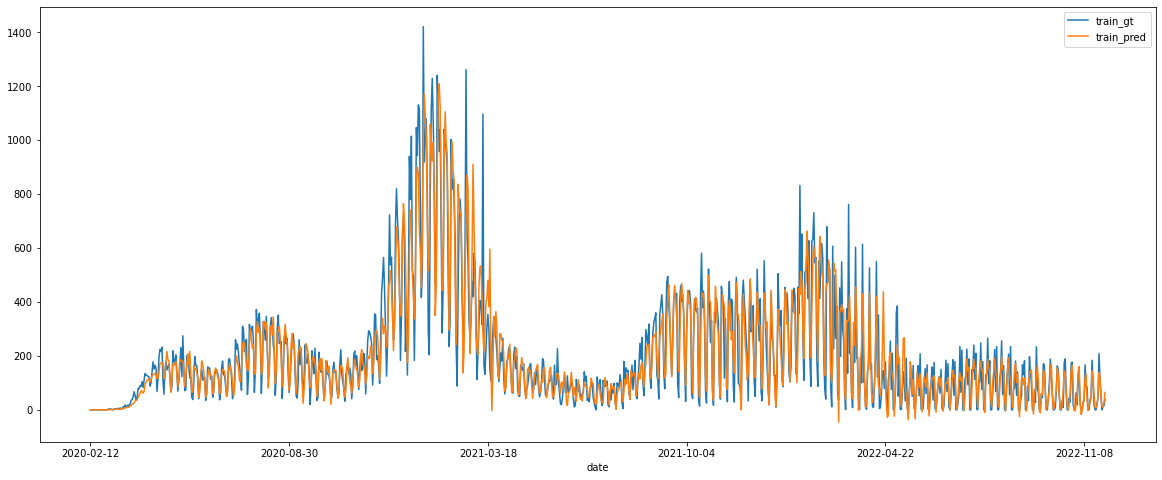

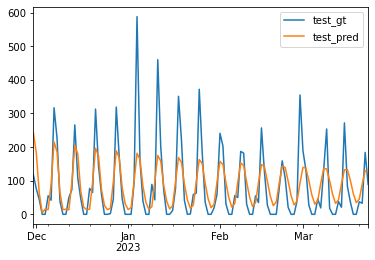

Training Set Metrics:
MAE: 54.93198630179385
MASE: 0.5467174664586933

Testing Set Metrics:
MAE: 51.75648266296938
MASE: 0.5785421447141695


In [1096]:
model = sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(6,1,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
test_pred = test_pred * 1.5
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

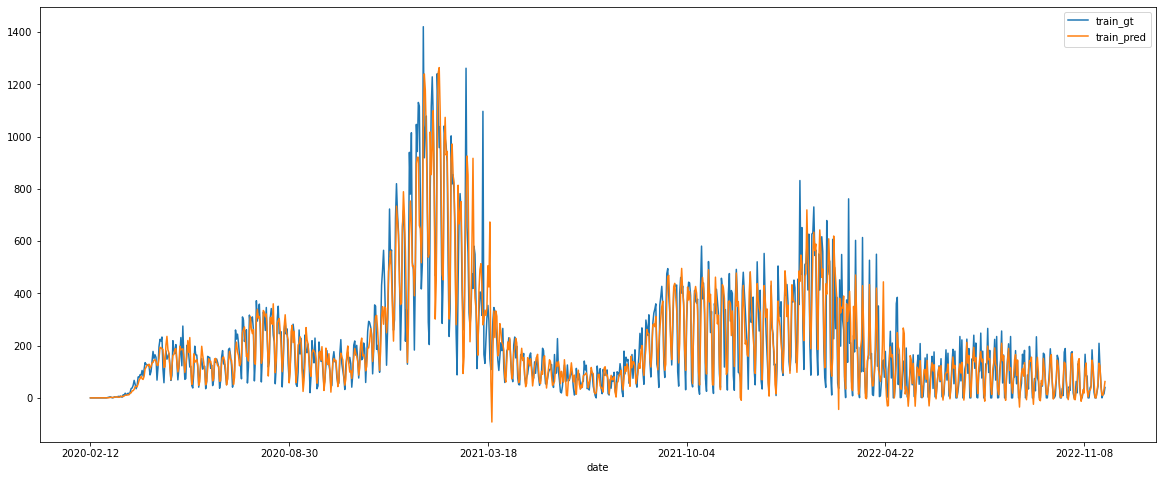

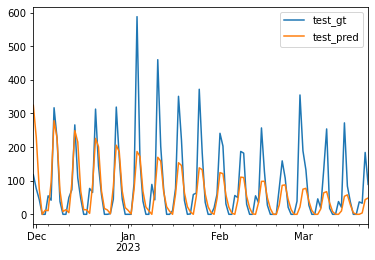

Training Set Metrics:
MAE: 55.0513071477983
MASE: 0.5479050221073252

Testing Set Metrics:
MAE: 48.44481794518326
MASE: 0.5415238330008614


In [1099]:
model = sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(6,2,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
test_pred = test_pred * 2
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1100]:
results=[]
for p in range(0,7):
    for q in range(0,7):
        model=sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(p,2,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

p  q           aic
48  6  6  12165.744088
47  6  5  12168.987193
45  6  3  12176.284378
46  6  4  12178.032008
43  6  1  12181.539249
44  6  2  12258.238182
39  5  4  12442.588684
37  5  2  12478.915416
38  5  3  12622.182350
41  5  6  12638.233483
42  6  0  12664.863405
34  4  6  12677.115849
40  5  5  12702.656985
6   0  6  12731.248126
36  5  1  12737.869141
5   0  5  12754.434654
13  1  6  12758.865220
19  2  5  12762.884296
32  4  4  12774.637411
18  2  4  12828.969521
12  1  5  12852.206721
20  2  6  12857.597711
26  3  5  12868.344986
11  1  4  12870.142492
10  1  3  12871.108949
3   0  3  12872.301412
4   0  4  12895.102168
27  3  6  12936.779899
29  4  1  12950.355415
2   0  2  13016.402815
30  4  2  13017.376142
33  4  5  13028.576017
31  4  3  13030.263387
24  3  3  13096.669502
22  3  1  13099.861035
17  2  3  13118.276716
25  3  4  13125.485573
15  2  1  13171.918491
23  3  2  13175.288368
16  2  2  13177.460466
8   1  1  13193.524831
1   0  1  13221.398402
9   1  2  13224.323141
35  5  0  13475.879521
28  4  0  13547.254118
21  3  0  13617.716192
14  2  0  13666.941916
7   1  0  13757.633859
0   0  0  14080.266960

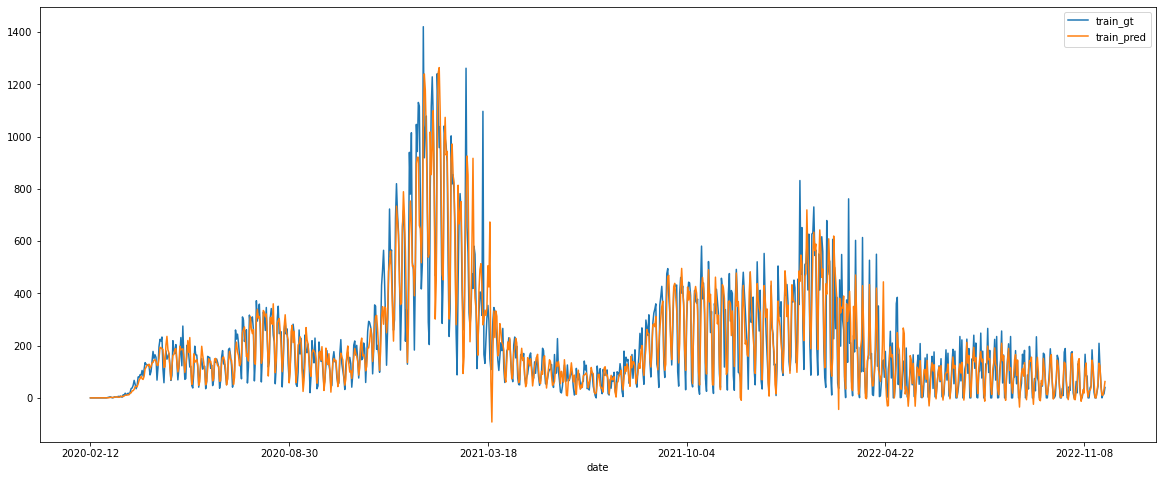

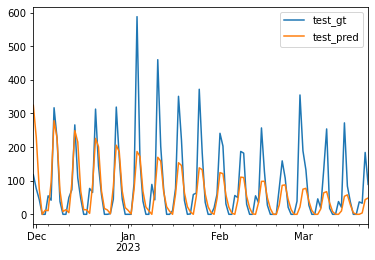

Training Set Metrics:
R-squared: 0.8202199100684161
MAE: 55.0513071477983
MASE: 0.5479050221073252

Testing Set Metrics:
R-squared: 0.42663118450068027
MAE: 48.44481794518326
MASE: 0.5415238330008614


In [1104]:
model = sm.tsa.arima.ARIMA(west_train['daily_deaths'],order=(6,2,6))
model = model.fit()

train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
west_test[west_test<0]=0
test_pred = test_pred * 2
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(west_train, train_pred)
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(west_test, test_pred)
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

# Time Series Decomposition

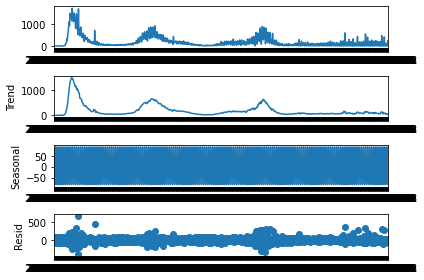

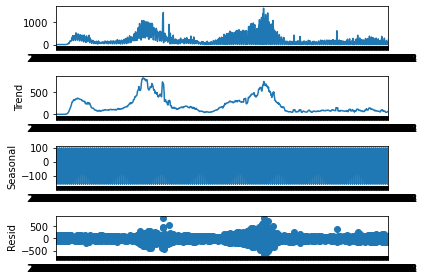

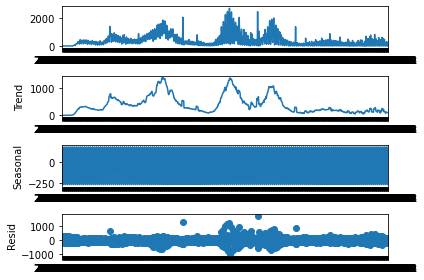

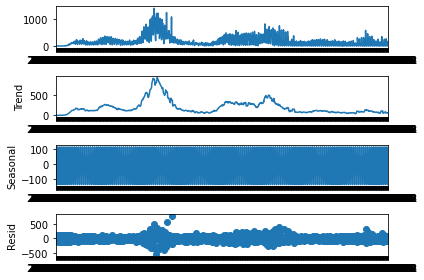

In [1106]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(east, period=7).plot()
plt.show()

seasonal_decompose(midwest, period=7).plot()
plt.show()

seasonal_decompose(south, period=7).plot()
plt.show()

seasonal_decompose(west, period=7).plot()
plt.show()

In [ ]:
seasonal_decompose(east, period=28).plot()
plt.show()

seasonal_decompose(midwest, period=28).plot()
plt.show()

seasonal_decompose(south, period=28).plot()
plt.show()

seasonal_decompose(west, period=28).plot()
plt.show()

# Auto ARIMA / SARIMA

### east

In [934]:
import warnings
import statsmodels.api 
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore",category =  UserWarning)
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)

if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(east_train,order=(p,0,q), seasonal_order=(P,0,Q,7)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.04244D+00    |proj g|=  3.24097D-01

At iterate    5    f=  5.90524D+00    |proj g|=  5.87898D-03


 This problem is unconstrained.



At iterate   10    f=  5.89718D+00    |proj g|=  5.03602D-03

At iterate   15    f=  5.88202D+00    |proj g|=  7.95648D-02

At iterate   20    f=  5.82916D+00    |proj g|=  1.70714D-02

At iterate   25    f=  5.82852D+00    |proj g|=  7.29329D-04

At iterate   30    f=  5.82665D+00    |proj g|=  3.91625D-02

At iterate   35    f=  5.82122D+00    |proj g|=  1.59154D-03

At iterate   40    f=  5.82114D+00    |proj g|=  4.13829D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     54      1     0     0   4.138D-06   5.821D+00
  F =   5.8211407960899386     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.90400D+00    |proj g|=  4.68233D-03

At iterate   10    f=  5.89672D+00    |proj g|=  7.30429D-03

At iterate   15    f=  5.88141D+00    |proj g|=  6.89913D-02

At iterate   20    f=  5.82908D+00    |proj g|=  1.54046D-02

At iterate   25    f=  5.82869D+00    |proj g|=  3.39286D-04

At iterate   30    f=  5.82588D+00    |proj g|=  2.24337D-02
  ys=-2.207E-04  -gs= 1.131E-03 BFGS update SKIPPED

At iterate   35    f=  5.82137D+00    |proj g|=  3.07285D-03

At iterate   40    f=  5.82100D+00    |proj g|=  2.26721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     61      1     1

 This problem is unconstrained.



At iterate   10    f=  5.88688D+00    |proj g|=  2.69026D-02

At iterate   15    f=  5.87304D+00    |proj g|=  3.51526D-02

At iterate   20    f=  5.83092D+00    |proj g|=  2.14922D-02

At iterate   25    f=  5.82990D+00    |proj g|=  1.51048D-04

At iterate   30    f=  5.82982D+00    |proj g|=  7.87903D-03

At iterate   35    f=  5.82168D+00    |proj g|=  3.37800D-03

At iterate   40    f=  5.82105D+00    |proj g|=  4.85097D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     60      1     0     0   6.670D-05   5.821D+00
  F =   5.8210037832343211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.90248D+00    |proj g|=  4.16907D-03

At iterate   10    f=  5.89384D+00    |proj g|=  2.91322D-02

At iterate   15    f=  5.84260D+00    |proj g|=  2.09862D-02

At iterate   20    f=  5.82964D+00    |proj g|=  1.39591D-03

At iterate   25    f=  5.82954D+00    |proj g|=  5.38831D-03

At iterate   30    f=  5.82765D+00    |proj g|=  1.99423D-02

At iterate   35    f=  5.82245D+00    |proj g|=  7.16549D-03

At iterate   40    f=  5.81576D+00    |proj g|=  1.09047D-02

At iterate   45    f=  5.81333D+00    |proj g|=  1.49821D-02

At iterate   50    f=  5.80977D+00    |proj g|=  1.16861D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.87567D+00    |proj g|=  1.18446D-02

At iterate   10    f=  5.86811D+00    |proj g|=  3.55049D-03

At iterate   15    f=  5.85639D+00    |proj g|=  6.87018D-02

At iterate   20    f=  5.82341D+00    |proj g|=  1.20009D-03

At iterate   25    f=  5.82334D+00    |proj g|=  2.24566D-03

At iterate   30    f=  5.82107D+00    |proj g|=  3.50591D-02

At iterate   35    f=  5.81794D+00    |proj g|=  6.41727D-03

At iterate   40    f=  5.81749D+00    |proj g|=  8.87198D-04

At iterate   45    f=  5.81748D+00    |proj g|=  3.02528D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     56   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02257D+00    |proj g|=  3.67586D-01

At iterate    5    f=  5.87358D+00    |proj g|=  4.07579D-03

At iterate   10    f=  5.86830D+00    |proj g|=  1.52842D-02

At iterate   15    f=  5.86599D+00    |proj g|=  2.19957D-02

At iterate   20    f=  5.82476D+00    |proj g|=  4.04376D-02

At iterate   25    f=  5.82322D+00    |proj g|=  1.59862D-03

At iterate   30    f=  5.82319D+00    |proj g|=  1.85755D-03

At iterate   35    f=  5.82001D+00    |proj g|=  4.35605D-02

At iterate   40    f=  5.81746D+00    |proj g|=  7.26761D-03

At iterate   45    f=  5.81739D+00    |proj g|=  6.49316D-05

At iterate   50    f=  5.81739D+00    |proj g|=  2.12270D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.87325D+00    |proj g|=  3.61424D-03

At iterate   10    f=  5.86891D+00    |proj g|=  2.17201D-02

At iterate   15    f=  5.85204D+00    |proj g|=  8.63979D-03

At iterate   20    f=  5.83022D+00    |proj g|=  6.74828D-02

At iterate   25    f=  5.82321D+00    |proj g|=  1.22096D-03

At iterate   30    f=  5.82317D+00    |proj g|=  2.12456D-03

At iterate   35    f=  5.82150D+00    |proj g|=  6.28112D-02

At iterate   40    f=  5.81767D+00    |proj g|=  1.45285D-02

At iterate   45    f=  5.81754D+00    |proj g|=  1.00999D-03

At iterate   50    f=  5.81739D+00    |proj g|=  6.51473D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.87141D+00    |proj g|=  3.64448D-03

At iterate   10    f=  5.86722D+00    |proj g|=  2.67466D-02

At iterate   15    f=  5.82939D+00    |proj g|=  3.64720D-02

At iterate   20    f=  5.82246D+00    |proj g|=  6.66979D-04

At iterate   25    f=  5.82209D+00    |proj g|=  4.60831D-03

At iterate   30    f=  5.81483D+00    |proj g|=  1.51986D-02

At iterate   35    f=  5.81300D+00    |proj g|=  2.33762D-03

At iterate   40    f=  5.81275D+00    |proj g|=  6.19937D-04

At iterate   45    f=  5.81243D+00    |proj g|=  7.91061D-03

At iterate   50    f=  5.80838D+00    |proj g|=  6.78309D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.93418D+00    |proj g|=  2.97727D-02

At iterate   10    f=  5.89491D+00    |proj g|=  5.83530D-02

At iterate   15    f=  5.88497D+00    |proj g|=  1.22560D-02

At iterate   20    f=  5.85727D+00    |proj g|=  7.06158D-02

At iterate   25    f=  5.82730D+00    |proj g|=  1.70034D-03

At iterate   30    f=  5.82725D+00    |proj g|=  2.91954D-04

At iterate   35    f=  5.82720D+00    |proj g|=  5.92414D-03

At iterate   40    f=  5.81950D+00    |proj g|=  1.75343D-02

At iterate   45    f=  5.81857D+00    |proj g|=  4.44361D-04

At iterate   50    f=  5.81857D+00    |proj g|=  5.46994D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  5.90187D+00    |proj g|=  5.12664D-02

At iterate   15    f=  5.88510D+00    |proj g|=  1.50896D-02

At iterate   20    f=  5.87184D+00    |proj g|=  3.11613D-02

At iterate   25    f=  5.82798D+00    |proj g|=  4.87621D-03

At iterate   30    f=  5.82772D+00    |proj g|=  3.17814D-04

At iterate   35    f=  5.82771D+00    |proj g|=  5.90483D-04

At iterate   40    f=  5.82764D+00    |proj g|=  8.31416D-03
  ys=-1.217E-02  -gs= 6.289E-04 BFGS update SKIPPED

At iterate   45    f=  5.81911D+00    |proj g|=  3.75501D-03

At iterate   50    f=  5.81847D+00    |proj g|=  5.93960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate    5    f=  5.93430D+00    |proj g|=  2.40611D-02

At iterate   10    f=  5.89257D+00    |proj g|=  4.00404D-02

At iterate   15    f=  5.88705D+00    |proj g|=  9.64289D-03

At iterate   20    f=  5.87531D+00    |proj g|=  2.06320D-02

At iterate   25    f=  5.87038D+00    |proj g|=  9.14177D-03

At iterate   30    f=  5.82874D+00    |proj g|=  3.05208D-02

At iterate   35    f=  5.82761D+00    |proj g|=  4.76230D-04

At iterate   40    f=  5.82760D+00    |proj g|=  1.73402D-04

At iterate   45    f=  5.82758D+00    |proj g|=  3.82861D-03

At iterate   50    f=  5.82107D+00    |proj g|=  3.59539D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.93077D+00    |proj g|=  2.40860D-02

At iterate   10    f=  5.90496D+00    |proj g|=  5.74811D-02

At iterate   15    f=  5.88609D+00    |proj g|=  9.12004D-03

At iterate   20    f=  5.87425D+00    |proj g|=  1.43398D-02

At iterate   25    f=  5.82508D+00    |proj g|=  6.59283D-03

At iterate   30    f=  5.82477D+00    |proj g|=  4.98838D-04

At iterate   35    f=  5.82445D+00    |proj g|=  2.22325D-02

At iterate   40    f=  5.82201D+00    |proj g|=  1.32494D-02

At iterate   45    f=  5.81692D+00    |proj g|=  3.68527D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     52   

 This problem is unconstrained.



At iterate    5    f=  5.88471D+00    |proj g|=  8.31553D-02

At iterate   10    f=  5.85933D+00    |proj g|=  8.48812D-03

At iterate   15    f=  5.85444D+00    |proj g|=  1.04020D-02

At iterate   20    f=  5.85105D+00    |proj g|=  4.33206D-03

At iterate   25    f=  5.82622D+00    |proj g|=  4.31358D-02

At iterate   30    f=  5.81260D+00    |proj g|=  1.12839D-02

At iterate   35    f=  5.80938D+00    |proj g|=  2.06449D-03

At iterate   40    f=  5.80931D+00    |proj g|=  2.35852D-03

At iterate   45    f=  5.80925D+00    |proj g|=  5.76535D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     53   

 This problem is unconstrained.



At iterate    5    f=  5.88317D+00    |proj g|=  9.13441D-02

At iterate   10    f=  5.85985D+00    |proj g|=  1.53225D-02

At iterate   15    f=  5.85583D+00    |proj g|=  7.44300D-03

At iterate   20    f=  5.85164D+00    |proj g|=  8.10410D-03

At iterate   25    f=  5.84907D+00    |proj g|=  9.17944D-03

At iterate   30    f=  5.82116D+00    |proj g|=  1.99584D-02

At iterate   35    f=  5.81299D+00    |proj g|=  3.13635D-03

At iterate   40    f=  5.81177D+00    |proj g|=  1.60982D-03

At iterate   45    f=  5.81153D+00    |proj g|=  1.39330D-03

At iterate   50    f=  5.81128D+00    |proj g|=  8.11225D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88670D+00    |proj g|=  1.51996D-01

At iterate   10    f=  5.85892D+00    |proj g|=  6.03736D-03

At iterate   15    f=  5.85583D+00    |proj g|=  2.69842D-02

At iterate   20    f=  5.84420D+00    |proj g|=  1.74283D-02

At iterate   25    f=  5.84246D+00    |proj g|=  5.77819D-03

At iterate   30    f=  5.83199D+00    |proj g|=  3.20187D-02

At iterate   35    f=  5.81765D+00    |proj g|=  8.50061D-03

At iterate   40    f=  5.81536D+00    |proj g|=  8.63980D-03

At iterate   45    f=  5.81212D+00    |proj g|=  1.00816D-02

At iterate   50    f=  5.81186D+00    |proj g|=  2.22734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88018D+00    |proj g|=  8.25770D-02

At iterate   10    f=  5.85815D+00    |proj g|=  1.01981D-02

At iterate   15    f=  5.85521D+00    |proj g|=  5.02699D-03

At iterate   20    f=  5.84935D+00    |proj g|=  1.26865D-02

At iterate   25    f=  5.82363D+00    |proj g|=  4.56372D-02

At iterate   30    f=  5.81201D+00    |proj g|=  1.81820D-03

At iterate   35    f=  5.81086D+00    |proj g|=  6.65690D-03

At iterate   40    f=  5.80934D+00    |proj g|=  5.12755D-04

At iterate   45    f=  5.80889D+00    |proj g|=  4.30711D-03

At iterate   50    f=  5.80561D+00    |proj g|=  6.20478D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [935]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
15  2  2  2  2  11884.671912
12  2  2  1  1  11888.103753
7   1  2  2  2  11888.320860
3   1  1  2  2  11889.173597
13  2  2  1  2  11894.246101
14  2  2  2  1  11895.446187
4   1  2  1  1  11902.919701
5   1  2  1  2  11904.735338
6   1  2  2  1  11904.750630
8   2  1  1  1  11905.153878
11  2  1  2  2  11905.667818
9   2  1  1  2  11906.951719
0   1  1  1  1  11908.411787
1   1  1  1  2  11910.101178
2   1  1  2  1  11910.131733
10  2  1  2  1  11912.274194

In [966]:
model=sm.tsa.statespace.SARIMAX(east_train,order=(2, 0, 2),seasonal_order=(2,0,2,7))
model=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.22337D+00    |proj g|=  8.24823D-01

At iterate    5    f=  5.88018D+00    |proj g|=  8.25770D-02

At iterate   10    f=  5.85815D+00    |proj g|=  1.01981D-02

At iterate   15    f=  5.85521D+00    |proj g|=  5.02699D-03

At iterate   20    f=  5.84935D+00    |proj g|=  1.26865D-02

At iterate   25    f=  5.82363D+00    |proj g|=  4.56372D-02

At iterate   30    f=  5.81201D+00    |proj g|=  1.81820D-03

At iterate   35    f=  5.81086D+00    |proj g|=  6.65690D-03

At iterate   40    f=  5.80934D+00    |proj g|=  5.12755D-04

At iterate   45    f=  5.80889D+00    |proj g|=  4.30711D-03

At iterate   50    f=  5.80561D+00    |proj g|=  6.20478D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

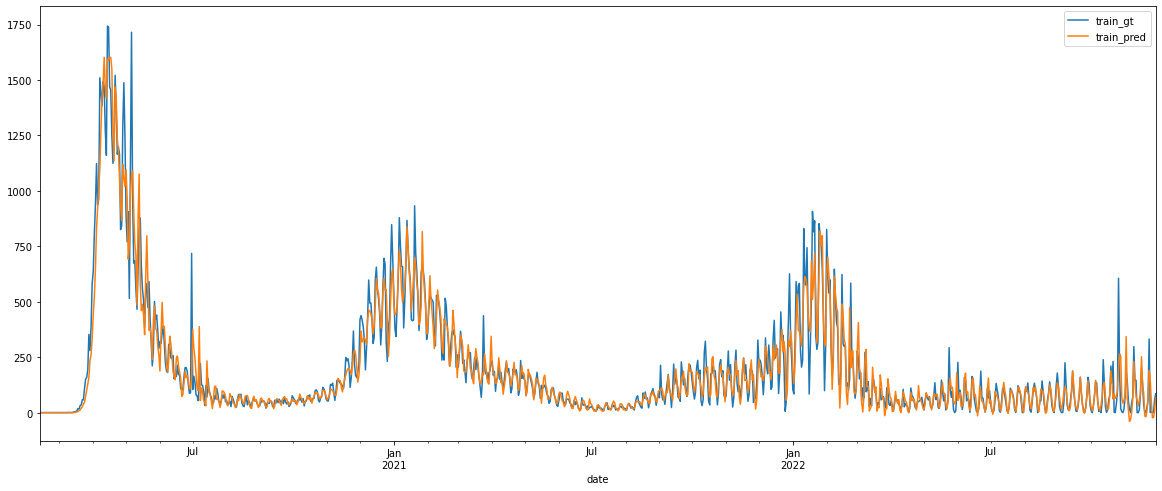

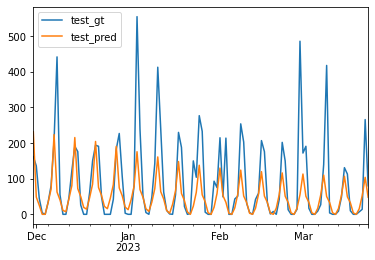

Training Set Metrics:
R-squared: 0.9110766552938006
MAE: 45.18343862292853
MASE: 0.6929996069343092

Testing Set Metrics:
R-squared: 0.2650918119813357
MAE: 52.947939465621
MASE: 0.5978334492021555


In [973]:
train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
test_pred = test_pred - 20
test_pred[test_pred<0] = 0
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1117]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(east_train,order=(p,1,q), seasonal_order=(P,1,Q,7)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85726D+00    |proj g|=  1.54148D-01


 This problem is unconstrained.



At iterate    5    f=  5.81374D+00    |proj g|=  9.48988D-03

At iterate   10    f=  5.80851D+00    |proj g|=  1.14720D-02

At iterate   15    f=  5.79747D+00    |proj g|=  2.16227D-02

At iterate   20    f=  5.78509D+00    |proj g|=  1.45565D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   9.735D-07   5.785D+00
  F =   5.7850922433498724     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.81530D+00    |proj g|=  7.50401D-03

At iterate   10    f=  5.81479D+00    |proj g|=  1.30219D-02

At iterate   15    f=  5.79869D+00    |proj g|=  1.37788D-02

At iterate   20    f=  5.77511D+00    |proj g|=  1.42236D-02

At iterate   25    f=  5.76959D+00    |proj g|=  1.24045D-03

At iterate   30    f=  5.76921D+00    |proj g|=  9.64280D-03

At iterate   35    f=  5.76902D+00    |proj g|=  2.31121D-03

At iterate   40    f=  5.76899D+00    |proj g|=  1.89938D-04

At iterate   45    f=  5.76899D+00    |proj g|=  3.47102D-04

At iterate   50    f=  5.76899D+00    |proj g|=  8.56383D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.82584D+00    |proj g|=  2.70090D-02

At iterate   10    f=  5.81278D+00    |proj g|=  3.55996D-02

At iterate   15    f=  5.79495D+00    |proj g|=  3.13806D-02

At iterate   20    f=  5.78092D+00    |proj g|=  1.55723D-02

At iterate   25    f=  5.77157D+00    |proj g|=  3.93260D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     34      1     0     0   7.276D-06   5.772D+00
  F =   5.7715707553966267     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  5.81242D+00    |proj g|=  2.83775D-02

At iterate   10    f=  5.80573D+00    |proj g|=  1.61064D-02

At iterate   15    f=  5.80058D+00    |proj g|=  2.92298D-03

At iterate   20    f=  5.78459D+00    |proj g|=  1.30823D-03

At iterate   25    f=  5.78457D+00    |proj g|=  2.05967D-03

At iterate   30    f=  5.78450D+00    |proj g|=  1.44848D-04

At iterate   35    f=  5.78450D+00    |proj g|=  4.07159D-04
  ys=-1.410E-04  -gs= 5.798E-05 BFGS update SKIPPED

At iterate   40    f=  5.78399D+00    |proj g|=  9.90122D-03

At iterate   45    f=  5.78300D+00    |proj g|=  2.15868D-03

At iterate   50    f=  5.78285D+00    |proj g|=  4.64786D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  5.81356D+00    |proj g|=  3.76976D-02

At iterate   10    f=  5.80734D+00    |proj g|=  1.70087D-02

At iterate   15    f=  5.79546D+00    |proj g|=  8.69117D-03

At iterate   20    f=  5.78965D+00    |proj g|=  3.03903D-03

At iterate   25    f=  5.78636D+00    |proj g|=  3.53246D-03

At iterate   30    f=  5.78455D+00    |proj g|=  2.64440D-02

At iterate   35    f=  5.78202D+00    |proj g|=  2.47333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     53      1     0     0   7.251D-06   5.782D+00
  F =   5.7820017926822871     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85145D+00    |proj g|=  2.24989D-01

At iterate    5    f=  5.81443D+00    |proj g|=  2.02358D-03

At iterate   10    f=  5.81063D+00    |proj g|=  5.71711D-02

At iterate   15    f=  5.79652D+00    |proj g|=  9.73509D-03

At iterate   20    f=  5.77812D+00    |proj g|=  5.49786D-02

At iterate   25    f=  5.77093D+00    |proj g|=  3.62733D-03

At iterate   30    f=  5.77082D+00    |proj g|=  2.63100D-03

At iterate   35    f=  5.77078D+00    |proj g|=  8.33218D-05

At iterate   40    f=  5.77078D+00    |proj g|=  1.68827D-04

At iterate   45    f=  5.77070D+00    |proj g|=  2.50465D-03

At iterate   50    f=  5.77058D+00    |proj g|=  3.69527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.82522D+00    |proj g|=  1.60856D-02

At iterate   10    f=  5.81335D+00    |proj g|=  6.48449D-02

At iterate   15    f=  5.79687D+00    |proj g|=  1.75039D-02

At iterate   20    f=  5.78582D+00    |proj g|=  3.65619D-03

At iterate   25    f=  5.77180D+00    |proj g|=  2.13721D-03

At iterate   30    f=  5.77097D+00    |proj g|=  3.62951D-03

At iterate   35    f=  5.77084D+00    |proj g|=  3.55637D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     39      1     0     0   3.556D-05   5.771D+00
  F =   5.7708427715302326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.81321D+00    |proj g|=  2.26951D-02

At iterate   10    f=  5.80285D+00    |proj g|=  1.31898D-02

At iterate   15    f=  5.79856D+00    |proj g|=  4.58579D-03

At iterate   20    f=  5.79037D+00    |proj g|=  1.36063D-02

At iterate   25    f=  5.78879D+00    |proj g|=  1.01429D-02

At iterate   30    f=  5.78609D+00    |proj g|=  2.40499D-03

At iterate   35    f=  5.78467D+00    |proj g|=  3.49633D-02

At iterate   40    f=  5.78161D+00    |proj g|=  2.91738D-03

At iterate   45    f=  5.78159D+00    |proj g|=  6.02804D-04

At iterate   50    f=  5.78150D+00    |proj g|=  3.98167D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80987D+00    |proj g|=  3.38759D-02

At iterate   10    f=  5.80291D+00    |proj g|=  1.61141D-02

At iterate   15    f=  5.79150D+00    |proj g|=  2.42371D-02

At iterate   20    f=  5.78065D+00    |proj g|=  1.25461D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     26      1     0     0   1.093D-05   5.781D+00
  F =   5.7806481666671310     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.80930D+00    |proj g|=  5.70041D-03

At iterate   10    f=  5.80878D+00    |proj g|=  1.00332D-02

At iterate   15    f=  5.80075D+00    |proj g|=  3.48780D-02

At iterate   20    f=  5.77841D+00    |proj g|=  1.60970D-02

At iterate   25    f=  5.76482D+00    |proj g|=  6.13637D-03

At iterate   30    f=  5.76473D+00    |proj g|=  3.24731D-04

At iterate   35    f=  5.76467D+00    |proj g|=  7.32548D-03

At iterate   40    f=  5.76408D+00    |proj g|=  4.98091D-03

At iterate   45    f=  5.76397D+00    |proj g|=  2.37574D-03

At iterate   50    f=  5.76388D+00    |proj g|=  5.57811D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81822D+00    |proj g|=  2.37065D-02

At iterate   10    f=  5.80043D+00    |proj g|=  3.98445D-02

At iterate   15    f=  5.78860D+00    |proj g|=  2.03008D-02

At iterate   20    f=  5.77505D+00    |proj g|=  5.45780D-02

At iterate   25    f=  5.76643D+00    |proj g|=  6.74838D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     32      1     0     0   8.277D-07   5.766D+00
  F =   5.7664309371561844     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 2 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.84000D+00    |proj g|=  1.91460D-01

At iterate    5    f=  5.80792D+00    |proj g|=  2.89945D-02

At iterate   10    f=  5.79902D+00    |proj g|=  2.13769D-02

At iterate   15    f=  5.79591D+00    |proj g|=  4.36538D-03

At iterate   20    f=  5.78375D+00    |proj g|=  2.29755D-02

At iterate   25    f=  5.78026D+00    |proj g|=  6.22965D-04

At iterate   30    f=  5.78025D+00    |proj g|=  1.41027D-03

At iterate   35    f=  5.78013D+00    |proj g|=  8.36304D-03

At iterate   40    f=  5.78004D+00    |proj g|=  1.53134D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  5.80377D+00    |proj g|=  4.01151D-02

At iterate   10    f=  5.79354D+00    |proj g|=  2.61756D-02

At iterate   15    f=  5.78409D+00    |proj g|=  1.16979D-02

At iterate   20    f=  5.78093D+00    |proj g|=  8.73080D-03

At iterate   25    f=  5.77960D+00    |proj g|=  1.07940D-02

At iterate   30    f=  5.77753D+00    |proj g|=  2.15129D-02

At iterate   35    f=  5.76695D+00    |proj g|=  4.32610D-03

At iterate   40    f=  5.76639D+00    |proj g|=  2.59328D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     51      1     0     0   4.069D-06   5.766D+00
  F =   5.76638596227

 This problem is unconstrained.



At iterate    5    f=  5.80240D+00    |proj g|=  1.58251D-02

At iterate   10    f=  5.78678D+00    |proj g|=  1.44028D-02

At iterate   15    f=  5.78165D+00    |proj g|=  8.53248D-03

At iterate   20    f=  5.78052D+00    |proj g|=  3.01899D-03

At iterate   25    f=  5.77548D+00    |proj g|=  1.13899D-02

At iterate   30    f=  5.76792D+00    |proj g|=  2.87517D-02

At iterate   35    f=  5.76483D+00    |proj g|=  9.16671D-03

At iterate   40    f=  5.76050D+00    |proj g|=  2.05682D-02

At iterate   45    f=  5.74386D+00    |proj g|=  8.06042D-03

At iterate   50    f=  5.74266D+00    |proj g|=  6.95060D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81480D+00    |proj g|=  2.53291D-02

At iterate   10    f=  5.79366D+00    |proj g|=  5.79170D-02

At iterate   15    f=  5.77214D+00    |proj g|=  1.13565D-02

At iterate   20    f=  5.76729D+00    |proj g|=  9.30507D-03

At iterate   25    f=  5.75108D+00    |proj g|=  3.24182D-02

At iterate   30    f=  5.74384D+00    |proj g|=  3.10479D-03

At iterate   35    f=  5.74380D+00    |proj g|=  1.53249D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     41      1     0     0   1.532D-05   5.744D+00
  F =   5.7438041377694473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.80339D+00    |proj g|=  4.04052D-02

At iterate   10    f=  5.78810D+00    |proj g|=  2.52761D-02

At iterate   15    f=  5.77881D+00    |proj g|=  7.46841D-03

At iterate   20    f=  5.77723D+00    |proj g|=  5.34004D-03

At iterate   25    f=  5.76874D+00    |proj g|=  4.51543D-02

At iterate   30    f=  5.75897D+00    |proj g|=  2.99108D-02

At iterate   35    f=  5.74497D+00    |proj g|=  8.79882D-03

At iterate   40    f=  5.74138D+00    |proj g|=  1.71973D-03

At iterate   45    f=  5.74124D+00    |proj g|=  2.52400D-03

At iterate   50    f=  5.74036D+00    |proj g|=  7.42246D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [1118]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
15  2  2  2  2  11751.304319
13  2  2  1  2  11754.004567
14  2  2  2  1  11756.335658
9   2  1  1  2  11795.366781
12  2  2  1  1  11800.492907
10  2  1  2  1  11800.584836
1   1  1  1  2  11803.814498
5   1  2  1  2  11809.068209
2   1  1  2  1  11809.090624
6   1  2  2  1  11809.602625
8   2  1  1  1  11827.644853
11  2  1  2  2  11830.401832
4   1  2  1  1  11830.411664
7   1  2  2  2  11833.379055
3   1  1  2  2  11834.148779
0   1  1  1  1  11834.728545

In [1121]:
model=sm.tsa.statespace.SARIMAX(east_train,order=(2, 1, 2),seasonal_order=(2,1,2,7))
model=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85885D+00    |proj g|=  2.84265D-01


 This problem is unconstrained.



At iterate    5    f=  5.80339D+00    |proj g|=  4.04052D-02

At iterate   10    f=  5.78810D+00    |proj g|=  2.52761D-02

At iterate   15    f=  5.77881D+00    |proj g|=  7.46841D-03

At iterate   20    f=  5.77723D+00    |proj g|=  5.34004D-03

At iterate   25    f=  5.76874D+00    |proj g|=  4.51543D-02

At iterate   30    f=  5.75897D+00    |proj g|=  2.99108D-02

At iterate   35    f=  5.74497D+00    |proj g|=  8.79882D-03

At iterate   40    f=  5.74138D+00    |proj g|=  1.71973D-03

At iterate   45    f=  5.74124D+00    |proj g|=  2.52400D-03

At iterate   50    f=  5.74036D+00    |proj g|=  7.42246D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

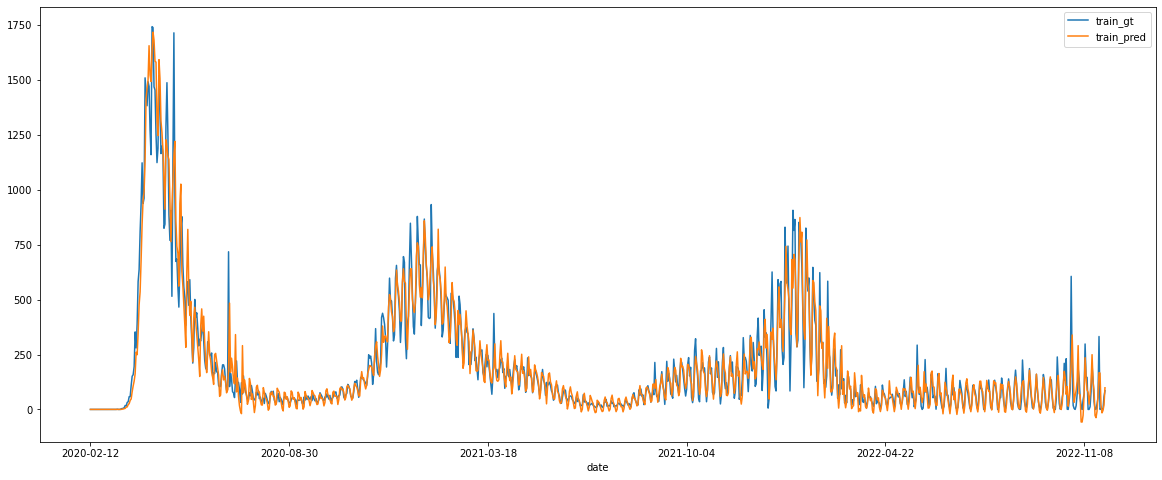

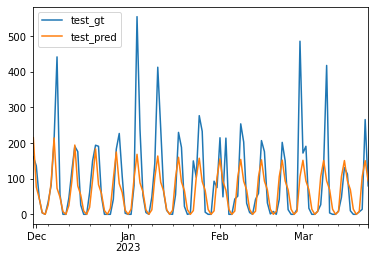

Training Set Metrics:
MAE: 46.26734054679823
MASE: 0.7096239195163062

Testing Set Metrics:
MAE: 50.42870945666838
MASE: 0.5693889057357641


In [1122]:
train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
#test_pred = test_pred - 20
test_pred[test_pred<0] = 0
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1113]:
east_auto = auto_arima(east_train, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=7,
                           start_P=0, start_Q = 0, max_Q = 2, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(east_auto.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=12522.332, Time=1.43 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=14336.039, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=12167.056, Time=1.46 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=12936.188, Time=1.29 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14779.862, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=12520.988, Time=0.25 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=12085.956, Time=5.65 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=12068.402, Time=4.87 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=12068.866, Time=1.65 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=7.25 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=12067.708, Time=4.84 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=12241.835, Time=3.22 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=12327.061, Time=2.01 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=12543.589, Time=4.94 sec
 ARIMA(2,0,0)(1,0,2)[7] i

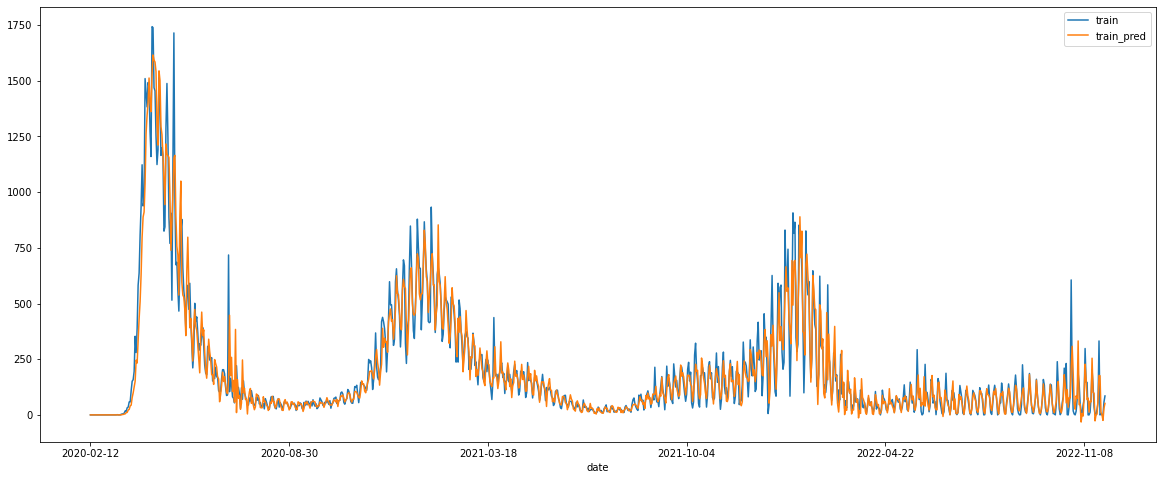

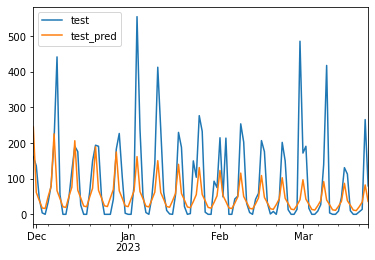

Training Set Metrics:
MAE: 44.87968459170661
MASE: 0.6883407887775458

Testing Set Metrics:
MAE: 57.63410841016286
MASE: 0.6507448291715031


In [1114]:
train_pred=east_auto.fittedvalues()
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=east_auto.predict(n_periods=len(east_test))
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1119]:
east_auto2 = auto_arima(east_train, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=7,
                           start_P=0, start_Q = 0, max_Q = 2, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(east_auto2.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=12076.895, Time=0.45 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=12478.590, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=12077.375, Time=0.34 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=11875.278, Time=0.42 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=12075.240, Time=0.17 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=1.42 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=11867.520, Time=0.81 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=3.20 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=12090.702, Time=0.74 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=11863.034, Time=1.08 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=11870.898, Time=0.70 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=inf, Time=3.62 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=inf, Time=1.49 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=11984.785, Time=0.92 sec
 ARIMA(2,1,1)(0,1,2)[7]             : AIC=1

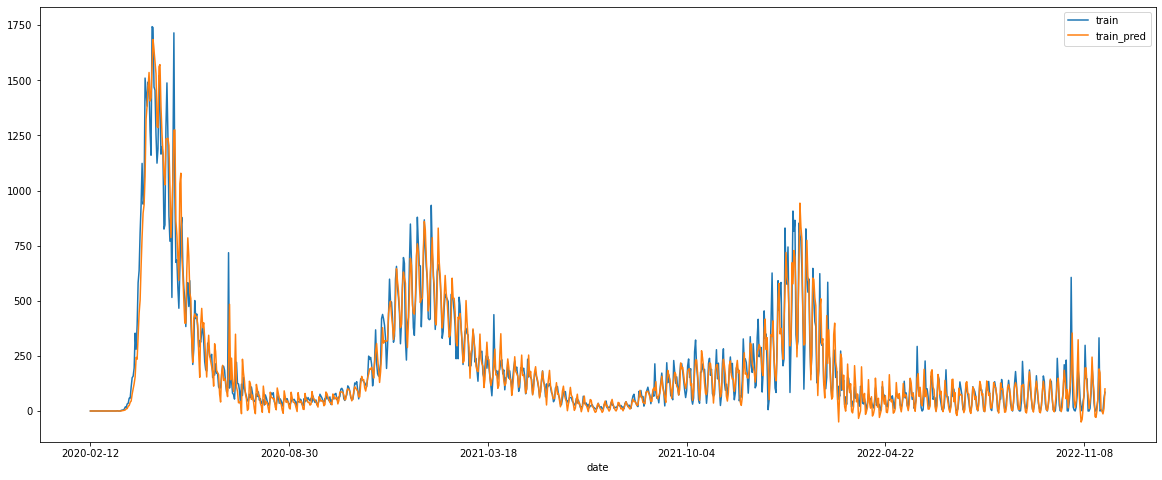

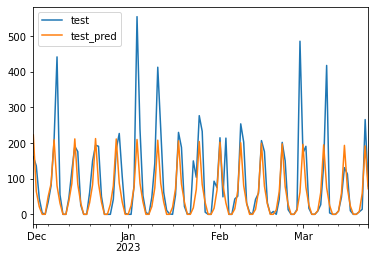

Training Set Metrics:
R-squared: 0.9135973208332667
MAE: 46.864056199550866
MASE: 0.718776027576521

Testing Set Metrics:
R-squared: 0.4155705366437571
MAE: 43.885701584277875
MASE: 0.4955120182877098


In [1120]:
train_pred=east_auto2.fittedvalues()
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=east_auto2.predict(n_periods=len(east_test))
test_pred[test_pred<0] = 0
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(east_train, train_pred)
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(east_test, test_pred)
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1123]:
n_periods = 7
forecast, conf_int = east_auto2.predict(n_periods=n_periods, return_conf_int=True)
forecast[forecast<0] = 0

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2022-11-30    222.847750
2022-12-01     64.423688
2022-12-02     21.381982
2022-12-03      0.000000
2022-12-04      0.000000
2022-12-05     49.642668
2022-12-06     86.469549
Freq: D, dtype: float64
Confidence Interval: [[  65.70858642  379.98691347]
 [-107.78726366  236.63463872]
 [-155.05208686  197.81605179]
 [-188.5235725   177.39033172]
 [-189.46227866  189.00838814]
 [-146.11688333  245.40221937]
 [-124.15185822  297.09095702]]


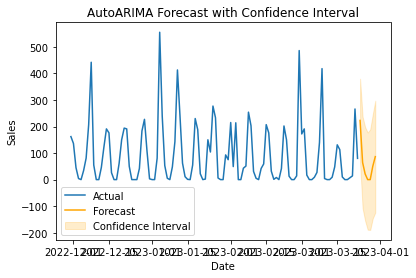

In [1124]:
forecast_index = pd.date_range(east_test.index[-1], periods=n_periods + 1, freq=east_test.index.freq)[-n_periods:]

plt.plot(east_test.index, east_test['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [1182]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,6):
        for q in range(1,6):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(east_train,order=(p,1,q), seasonal_order=(P,1,Q,7)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85726D+00    |proj g|=  1.54148D-01


 This problem is unconstrained.



At iterate    5    f=  5.81374D+00    |proj g|=  9.48988D-03

At iterate   10    f=  5.80851D+00    |proj g|=  1.14720D-02

At iterate   15    f=  5.79747D+00    |proj g|=  2.16227D-02

At iterate   20    f=  5.78509D+00    |proj g|=  1.45565D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   9.735D-07   5.785D+00
  F =   5.7850922433498724     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.81530D+00    |proj g|=  7.50401D-03

At iterate   10    f=  5.81479D+00    |proj g|=  1.30219D-02

At iterate   15    f=  5.79869D+00    |proj g|=  1.37788D-02

At iterate   20    f=  5.77511D+00    |proj g|=  1.42236D-02

At iterate   25    f=  5.76959D+00    |proj g|=  1.24045D-03

At iterate   30    f=  5.76921D+00    |proj g|=  9.64280D-03

At iterate   35    f=  5.76902D+00    |proj g|=  2.31121D-03

At iterate   40    f=  5.76899D+00    |proj g|=  1.89938D-04

At iterate   45    f=  5.76899D+00    |proj g|=  3.47102D-04

At iterate   50    f=  5.76899D+00    |proj g|=  8.56383D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.82584D+00    |proj g|=  2.70090D-02

At iterate   10    f=  5.81278D+00    |proj g|=  3.55996D-02

At iterate   15    f=  5.79495D+00    |proj g|=  3.13806D-02

At iterate   20    f=  5.78092D+00    |proj g|=  1.55723D-02

At iterate   25    f=  5.77157D+00    |proj g|=  3.93260D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     34      1     0     0   7.276D-06   5.772D+00
  F =   5.7715707553966267     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  5.81242D+00    |proj g|=  2.83775D-02

At iterate   10    f=  5.80573D+00    |proj g|=  1.61064D-02

At iterate   15    f=  5.80058D+00    |proj g|=  2.92298D-03

At iterate   20    f=  5.78459D+00    |proj g|=  1.30823D-03

At iterate   25    f=  5.78457D+00    |proj g|=  2.05967D-03

At iterate   30    f=  5.78450D+00    |proj g|=  1.44848D-04

At iterate   35    f=  5.78450D+00    |proj g|=  4.07159D-04
  ys=-1.410E-04  -gs= 5.798E-05 BFGS update SKIPPED

At iterate   40    f=  5.78399D+00    |proj g|=  9.90122D-03

At iterate   45    f=  5.78300D+00    |proj g|=  2.15868D-03

At iterate   50    f=  5.78285D+00    |proj g|=  4.64786D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  5.81356D+00    |proj g|=  3.76976D-02

At iterate   10    f=  5.80734D+00    |proj g|=  1.70087D-02

At iterate   15    f=  5.79546D+00    |proj g|=  8.69117D-03

At iterate   20    f=  5.78965D+00    |proj g|=  3.03903D-03

At iterate   25    f=  5.78636D+00    |proj g|=  3.53246D-03

At iterate   30    f=  5.78455D+00    |proj g|=  2.64440D-02

At iterate   35    f=  5.78202D+00    |proj g|=  2.47333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     53      1     0     0   7.251D-06   5.782D+00
  F =   5.7820017926822871     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85145D+00    |proj g|=  2.24989D-01

At iterate    5    f=  5.81443D+00    |proj g|=  2.02358D-03

At iterate   10    f=  5.81063D+00    |proj g|=  5.71711D-02

At iterate   15    f=  5.79652D+00    |proj g|=  9.73509D-03

At iterate   20    f=  5.77812D+00    |proj g|=  5.49786D-02

At iterate   25    f=  5.77093D+00    |proj g|=  3.62733D-03

At iterate   30    f=  5.77082D+00    |proj g|=  2.63100D-03

At iterate   35    f=  5.77078D+00    |proj g|=  8.33218D-05

At iterate   40    f=  5.77078D+00    |proj g|=  1.68827D-04

At iterate   45    f=  5.77070D+00    |proj g|=  2.50465D-03

At iterate   50    f=  5.77058D+00    |proj g|=  3.69527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.82522D+00    |proj g|=  1.60856D-02

At iterate   10    f=  5.81335D+00    |proj g|=  6.48449D-02

At iterate   15    f=  5.79687D+00    |proj g|=  1.75039D-02

At iterate   20    f=  5.78582D+00    |proj g|=  3.65619D-03

At iterate   25    f=  5.77180D+00    |proj g|=  2.13721D-03

At iterate   30    f=  5.77097D+00    |proj g|=  3.62951D-03

At iterate   35    f=  5.77084D+00    |proj g|=  3.55637D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     39      1     0     0   3.556D-05   5.771D+00
  F =   5.7708427715302326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.81321D+00    |proj g|=  2.26951D-02

At iterate   10    f=  5.80285D+00    |proj g|=  1.31898D-02

At iterate   15    f=  5.79856D+00    |proj g|=  4.58579D-03

At iterate   20    f=  5.79037D+00    |proj g|=  1.36063D-02

At iterate   25    f=  5.78879D+00    |proj g|=  1.01429D-02

At iterate   30    f=  5.78609D+00    |proj g|=  2.40499D-03

At iterate   35    f=  5.78467D+00    |proj g|=  3.49633D-02

At iterate   40    f=  5.78161D+00    |proj g|=  2.91738D-03

At iterate   45    f=  5.78159D+00    |proj g|=  6.02804D-04

At iterate   50    f=  5.78150D+00    |proj g|=  3.98167D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.82047D+00    |proj g|=  2.31820D-02

At iterate   10    f=  5.80819D+00    |proj g|=  6.59146D-03

At iterate   15    f=  5.80296D+00    |proj g|=  3.70174D-03

At iterate   20    f=  5.78972D+00    |proj g|=  1.45555D-02

At iterate   25    f=  5.78443D+00    |proj g|=  6.61158D-04

At iterate   30    f=  5.78437D+00    |proj g|=  1.19116D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     36      1     0     0   3.968D-05   5.784D+00
  F =   5.7843642409468350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 3 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.81351D+00    |proj g|=  9.89606D-03

At iterate   10    f=  5.81269D+00    |proj g|=  1.18240D-02

At iterate   15    f=  5.80176D+00    |proj g|=  4.13438D-02

At iterate   20    f=  5.77048D+00    |proj g|=  1.06020D-02

At iterate   25    f=  5.76888D+00    |proj g|=  4.35030D-04

At iterate   30    f=  5.76882D+00    |proj g|=  2.81867D-03

At iterate   35    f=  5.76815D+00    |proj g|=  3.19243D-03

At iterate   40    f=  5.76804D+00    |proj g|=  1.25244D-03

At iterate   45    f=  5.76798D+00    |proj g|=  9.93378D-03

At iterate   50    f=  5.76625D+00    |proj g|=  2.26232D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.82997D+00    |proj g|=  2.92097D-02

At iterate   10    f=  5.81829D+00    |proj g|=  4.53070D-02

At iterate   15    f=  5.80443D+00    |proj g|=  2.01566D-02

At iterate   20    f=  5.79045D+00    |proj g|=  1.84711D-02

At iterate   25    f=  5.77141D+00    |proj g|=  2.21475D-02

At iterate   30    f=  5.77046D+00    |proj g|=  1.06913D-02

At iterate   35    f=  5.77012D+00    |proj g|=  1.44783D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     41      1     0     0   3.420D-05   5.770D+00
  F =   5.7701175149244461     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.81334D+00    |proj g|=  3.83726D-02

At iterate   10    f=  5.80345D+00    |proj g|=  1.80591D-02

At iterate   15    f=  5.79936D+00    |proj g|=  5.54515D-03

At iterate   20    f=  5.79053D+00    |proj g|=  3.99127D-02

At iterate   25    f=  5.78379D+00    |proj g|=  2.59226D-03

At iterate   30    f=  5.78376D+00    |proj g|=  2.01446D-04

At iterate   35    f=  5.78376D+00    |proj g|=  7.90591D-04

At iterate   40    f=  5.78373D+00    |proj g|=  2.95011D-03

At iterate   45    f=  5.78372D+00    |proj g|=  2.68157D-04

At iterate   50    f=  5.78369D+00    |proj g|=  1.32084D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80951D+00    |proj g|=  2.56402D-02

At iterate   10    f=  5.79614D+00    |proj g|=  2.84204D-02

At iterate   15    f=  5.79307D+00    |proj g|=  4.45491D-03

At iterate   20    f=  5.78402D+00    |proj g|=  1.96959D-02

At iterate   25    f=  5.77992D+00    |proj g|=  9.13986D-03

At iterate   30    f=  5.77342D+00    |proj g|=  4.12355D-02

At iterate   35    f=  5.76630D+00    |proj g|=  1.48357D-03

At iterate   40    f=  5.76629D+00    |proj g|=  1.95506D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     54      1     0     0   3.755D-06   5.766D+00
  F =   5.76629020340

 This problem is unconstrained.



At iterate    5    f=  5.81022D+00    |proj g|=  4.40144D-03

At iterate   10    f=  5.80317D+00    |proj g|=  1.40272D-02

At iterate   15    f=  5.79901D+00    |proj g|=  2.33794D-02

At iterate   20    f=  5.78451D+00    |proj g|=  1.78995D-02

At iterate   25    f=  5.77353D+00    |proj g|=  3.87528D-02

At iterate   30    f=  5.75785D+00    |proj g|=  2.08049D-02

At iterate   35    f=  5.75452D+00    |proj g|=  9.65080D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     39     48      1     0     0   2.108D-05   5.755D+00
  F =   5.7545149206560824     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.81905D+00    |proj g|=  2.34033D-02

At iterate   10    f=  5.79847D+00    |proj g|=  2.47116D-02

At iterate   15    f=  5.78900D+00    |proj g|=  1.05815D-02

At iterate   20    f=  5.78523D+00    |proj g|=  1.95451D-02

At iterate   25    f=  5.76596D+00    |proj g|=  6.98842D-03

At iterate   30    f=  5.76582D+00    |proj g|=  2.66915D-03

At iterate   35    f=  5.76508D+00    |proj g|=  2.75543D-03

At iterate   40    f=  5.76503D+00    |proj g|=  2.72465D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     48      1     0     0   1.211D-05   5.765D+00
  F =   5.76503210213

 This problem is unconstrained.



At iterate    5    f=  5.80586D+00    |proj g|=  3.88990D-02

At iterate   10    f=  5.79312D+00    |proj g|=  2.35487D-02

At iterate   15    f=  5.79070D+00    |proj g|=  4.83393D-03

At iterate   20    f=  5.77729D+00    |proj g|=  2.93940D-02

At iterate   25    f=  5.77043D+00    |proj g|=  1.60637D-02

At iterate   30    f=  5.76636D+00    |proj g|=  3.83216D-03

At iterate   35    f=  5.76618D+00    |proj g|=  1.86220D-03

At iterate   40    f=  5.76560D+00    |proj g|=  7.32611D-04

At iterate   45    f=  5.76560D+00    |proj g|=  1.23295D-04

At iterate   50    f=  5.76559D+00    |proj g|=  5.90673D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80820D+00    |proj g|=  2.18882D-02

At iterate   10    f=  5.80196D+00    |proj g|=  2.90132D-02

At iterate   15    f=  5.78945D+00    |proj g|=  8.77498D-03

At iterate   20    f=  5.78746D+00    |proj g|=  3.83369D-03

At iterate   25    f=  5.78340D+00    |proj g|=  1.76989D-02

At iterate   30    f=  5.77833D+00    |proj g|=  5.29795D-03

At iterate   35    f=  5.77590D+00    |proj g|=  2.63147D-02

At iterate   40    f=  5.76321D+00    |proj g|=  1.66490D-02

At iterate   45    f=  5.76239D+00    |proj g|=  7.05768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     58   

 This problem is unconstrained.



At iterate    5    f=  5.80941D+00    |proj g|=  4.11005D-03

At iterate   10    f=  5.80723D+00    |proj g|=  3.90417D-02

At iterate   15    f=  5.78537D+00    |proj g|=  7.59182D-02

At iterate   20    f=  5.77781D+00    |proj g|=  4.13110D-03

At iterate   25    f=  5.76338D+00    |proj g|=  5.37698D-02

At iterate   30    f=  5.74869D+00    |proj g|=  2.79645D-02

At iterate   35    f=  5.74144D+00    |proj g|=  2.51432D-02

At iterate   40    f=  5.73970D+00    |proj g|=  2.27571D-03

At iterate   45    f=  5.73967D+00    |proj g|=  2.14270D-04

At iterate   50    f=  5.73964D+00    |proj g|=  2.30419D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81943D+00    |proj g|=  1.39673D-02

At iterate   10    f=  5.80356D+00    |proj g|=  4.17959D-02

At iterate   15    f=  5.78720D+00    |proj g|=  2.44501D-02

At iterate   20    f=  5.78410D+00    |proj g|=  8.10962D-03

At iterate   25    f=  5.77879D+00    |proj g|=  4.30872D-02

At iterate   30    f=  5.76269D+00    |proj g|=  1.62315D-02

At iterate   35    f=  5.76235D+00    |proj g|=  2.20097D-03

At iterate   40    f=  5.76129D+00    |proj g|=  6.14566D-03

At iterate   45    f=  5.76107D+00    |proj g|=  1.25905D-04

At iterate   50    f=  5.76107D+00    |proj g|=  3.77267D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80770D+00    |proj g|=  2.68766D-02

At iterate   10    f=  5.79837D+00    |proj g|=  2.84852D-02

At iterate   15    f=  5.78947D+00    |proj g|=  8.10236D-03

At iterate   20    f=  5.78803D+00    |proj g|=  3.08207D-03

At iterate   25    f=  5.78154D+00    |proj g|=  2.58203D-02

At iterate   30    f=  5.77462D+00    |proj g|=  1.08542D-02

At iterate   35    f=  5.77104D+00    |proj g|=  1.42929D-02

At iterate   40    f=  5.76465D+00    |proj g|=  2.44623D-02

At iterate   45    f=  5.76139D+00    |proj g|=  2.24323D-03

At iterate   50    f=  5.76125D+00    |proj g|=  2.43584D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80987D+00    |proj g|=  3.38759D-02

At iterate   10    f=  5.80291D+00    |proj g|=  1.61141D-02

At iterate   15    f=  5.79150D+00    |proj g|=  2.42371D-02

At iterate   20    f=  5.78065D+00    |proj g|=  1.25461D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     26      1     0     0   1.093D-05   5.781D+00
  F =   5.7806481666671310     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.80930D+00    |proj g|=  5.70041D-03

At iterate   10    f=  5.80878D+00    |proj g|=  1.00332D-02

At iterate   15    f=  5.80075D+00    |proj g|=  3.48780D-02

At iterate   20    f=  5.77841D+00    |proj g|=  1.60970D-02

At iterate   25    f=  5.76482D+00    |proj g|=  6.13637D-03

At iterate   30    f=  5.76473D+00    |proj g|=  3.24731D-04

At iterate   35    f=  5.76467D+00    |proj g|=  7.32548D-03

At iterate   40    f=  5.76408D+00    |proj g|=  4.98091D-03

At iterate   45    f=  5.76397D+00    |proj g|=  2.37574D-03

At iterate   50    f=  5.76388D+00    |proj g|=  5.57811D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81822D+00    |proj g|=  2.37065D-02

At iterate   10    f=  5.80043D+00    |proj g|=  3.98445D-02

At iterate   15    f=  5.78860D+00    |proj g|=  2.03008D-02

At iterate   20    f=  5.77505D+00    |proj g|=  5.45780D-02

At iterate   25    f=  5.76643D+00    |proj g|=  6.74838D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     32      1     0     0   8.277D-07   5.766D+00
  F =   5.7664309371561844     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  5.80792D+00    |proj g|=  2.89945D-02

At iterate   10    f=  5.79902D+00    |proj g|=  2.13769D-02

At iterate   15    f=  5.79591D+00    |proj g|=  4.36538D-03

At iterate   20    f=  5.78375D+00    |proj g|=  2.29755D-02

At iterate   25    f=  5.78026D+00    |proj g|=  6.22965D-04

At iterate   30    f=  5.78025D+00    |proj g|=  1.41027D-03

At iterate   35    f=  5.78013D+00    |proj g|=  8.36304D-03

At iterate   40    f=  5.78004D+00    |proj g|=  1.53134D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     51      1     0     0   1.725D-05   5.780D+00
  F =   5.78004003541

 This problem is unconstrained.



At iterate    5    f=  5.80377D+00    |proj g|=  4.01151D-02

At iterate   10    f=  5.79354D+00    |proj g|=  2.61756D-02

At iterate   15    f=  5.78409D+00    |proj g|=  1.16979D-02

At iterate   20    f=  5.78093D+00    |proj g|=  8.73080D-03

At iterate   25    f=  5.77960D+00    |proj g|=  1.07940D-02

At iterate   30    f=  5.77753D+00    |proj g|=  2.15129D-02

At iterate   35    f=  5.76695D+00    |proj g|=  4.32610D-03

At iterate   40    f=  5.76639D+00    |proj g|=  2.59328D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     51      1     0     0   4.069D-06   5.766D+00
  F =   5.76638596227

 This problem is unconstrained.



At iterate    5    f=  5.80240D+00    |proj g|=  1.58251D-02

At iterate   10    f=  5.78678D+00    |proj g|=  1.44028D-02

At iterate   15    f=  5.78165D+00    |proj g|=  8.53248D-03

At iterate   20    f=  5.78052D+00    |proj g|=  3.01899D-03

At iterate   25    f=  5.77548D+00    |proj g|=  1.13899D-02

At iterate   30    f=  5.76792D+00    |proj g|=  2.87517D-02

At iterate   35    f=  5.76483D+00    |proj g|=  9.16671D-03

At iterate   40    f=  5.76050D+00    |proj g|=  2.05682D-02

At iterate   45    f=  5.74386D+00    |proj g|=  8.06042D-03

At iterate   50    f=  5.74266D+00    |proj g|=  6.95060D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81480D+00    |proj g|=  2.53291D-02

At iterate   10    f=  5.79366D+00    |proj g|=  5.79170D-02

At iterate   15    f=  5.77214D+00    |proj g|=  1.13565D-02

At iterate   20    f=  5.76729D+00    |proj g|=  9.30507D-03

At iterate   25    f=  5.75108D+00    |proj g|=  3.24182D-02

At iterate   30    f=  5.74384D+00    |proj g|=  3.10479D-03

At iterate   35    f=  5.74380D+00    |proj g|=  1.53249D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     41      1     0     0   1.532D-05   5.744D+00
  F =   5.7438041377694473     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.80339D+00    |proj g|=  4.04052D-02

At iterate   10    f=  5.78810D+00    |proj g|=  2.52761D-02

At iterate   15    f=  5.77881D+00    |proj g|=  7.46841D-03

At iterate   20    f=  5.77723D+00    |proj g|=  5.34004D-03

At iterate   25    f=  5.76874D+00    |proj g|=  4.51543D-02

At iterate   30    f=  5.75897D+00    |proj g|=  2.99108D-02

At iterate   35    f=  5.74497D+00    |proj g|=  8.79882D-03

At iterate   40    f=  5.74138D+00    |proj g|=  1.71973D-03

At iterate   45    f=  5.74124D+00    |proj g|=  2.52400D-03

At iterate   50    f=  5.74036D+00    |proj g|=  7.42246D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80152D+00    |proj g|=  6.56529D-02

At iterate   10    f=  5.78103D+00    |proj g|=  5.50141D-02

At iterate   15    f=  5.77478D+00    |proj g|=  1.26264D-02

At iterate   20    f=  5.77350D+00    |proj g|=  2.57639D-03

At iterate   25    f=  5.77270D+00    |proj g|=  4.57646D-03

At iterate   30    f=  5.75943D+00    |proj g|=  2.51798D-02

At iterate   35    f=  5.75639D+00    |proj g|=  1.77421D-02

At iterate   40    f=  5.75506D+00    |proj g|=  2.82740D-03

At iterate   45    f=  5.75506D+00    |proj g|=  1.43713D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     58   

 This problem is unconstrained.



At iterate    5    f=  5.80051D+00    |proj g|=  1.06606D-02

At iterate   10    f=  5.78701D+00    |proj g|=  3.24875D-02

At iterate   15    f=  5.77986D+00    |proj g|=  4.27911D-03

At iterate   20    f=  5.77601D+00    |proj g|=  1.63154D-02

At iterate   25    f=  5.77036D+00    |proj g|=  2.41806D-02

At iterate   30    f=  5.76224D+00    |proj g|=  6.35762D-03

At iterate   35    f=  5.75518D+00    |proj g|=  2.21818D-02

At iterate   40    f=  5.75477D+00    |proj g|=  4.97886D-03

At iterate   45    f=  5.75450D+00    |proj g|=  2.83954D-02

At iterate   50    f=  5.74989D+00    |proj g|=  4.72615D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81153D+00    |proj g|=  2.55144D-02

At iterate   10    f=  5.77714D+00    |proj g|=  3.13456D-02

At iterate   15    f=  5.76955D+00    |proj g|=  8.11375D-03

At iterate   20    f=  5.76556D+00    |proj g|=  5.08021D-03

At iterate   25    f=  5.76071D+00    |proj g|=  2.41311D-02

At iterate   30    f=  5.75156D+00    |proj g|=  1.61184D-02

At iterate   35    f=  5.74606D+00    |proj g|=  3.98878D-03

At iterate   40    f=  5.74279D+00    |proj g|=  1.74420D-02

At iterate   45    f=  5.74246D+00    |proj g|=  5.87612D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     59   

 This problem is unconstrained.



At iterate    5    f=  5.79718D+00    |proj g|=  5.26677D-02

At iterate   10    f=  5.77797D+00    |proj g|=  2.73110D-02

At iterate   15    f=  5.77305D+00    |proj g|=  8.71700D-03

At iterate   20    f=  5.77194D+00    |proj g|=  3.50674D-03

At iterate   25    f=  5.77048D+00    |proj g|=  3.57834D-02

At iterate   30    f=  5.76460D+00    |proj g|=  7.08058D-02

At iterate   35    f=  5.75974D+00    |proj g|=  2.96488D-02

At iterate   40    f=  5.75943D+00    |proj g|=  9.47979D-04

At iterate   45    f=  5.75926D+00    |proj g|=  3.64278D-02

At iterate   50    f=  5.75898D+00    |proj g|=  1.28557D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80311D+00    |proj g|=  5.74489D-02

At iterate   10    f=  5.78442D+00    |proj g|=  6.17252D-02

At iterate   15    f=  5.77243D+00    |proj g|=  7.63143D-03

At iterate   20    f=  5.76687D+00    |proj g|=  6.51460D-03

At iterate   25    f=  5.76588D+00    |proj g|=  1.36619D-02

At iterate   30    f=  5.75527D+00    |proj g|=  3.77300D-02

At iterate   35    f=  5.74898D+00    |proj g|=  3.54630D-02

At iterate   40    f=  5.74651D+00    |proj g|=  3.19588D-03

At iterate   45    f=  5.74645D+00    |proj g|=  1.41839D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     53   

 This problem is unconstrained.



At iterate    5    f=  5.80269D+00    |proj g|=  1.15632D-02

At iterate   10    f=  5.79379D+00    |proj g|=  4.04183D-02

At iterate   15    f=  5.77965D+00    |proj g|=  2.92828D-02

At iterate   20    f=  5.77744D+00    |proj g|=  2.43756D-03

At iterate   25    f=  5.77357D+00    |proj g|=  2.94571D-02

At iterate   30    f=  5.75814D+00    |proj g|=  2.61293D-02

At iterate   35    f=  5.74567D+00    |proj g|=  1.69342D-02

At iterate   40    f=  5.73799D+00    |proj g|=  4.36301D-03

At iterate   45    f=  5.73765D+00    |proj g|=  4.17631D-03

At iterate   50    f=  5.73755D+00    |proj g|=  1.05054D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81371D+00    |proj g|=  2.69402D-02

At iterate   10    f=  5.77374D+00    |proj g|=  3.22684D-02

At iterate   15    f=  5.76851D+00    |proj g|=  7.58529D-03

At iterate   20    f=  5.76413D+00    |proj g|=  3.97812D-03

At iterate   25    f=  5.75592D+00    |proj g|=  1.93564D-02

At iterate   30    f=  5.74557D+00    |proj g|=  5.65046D-03

At iterate   35    f=  5.74062D+00    |proj g|=  2.69586D-02

At iterate   40    f=  5.73892D+00    |proj g|=  1.89766D-03

At iterate   45    f=  5.73887D+00    |proj g|=  2.91702D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     46     55   

 This problem is unconstrained.



At iterate    5    f=  5.79709D+00    |proj g|=  3.68356D-02

At iterate   10    f=  5.77661D+00    |proj g|=  4.47354D-02

At iterate   15    f=  5.77129D+00    |proj g|=  6.19625D-03

At iterate   20    f=  5.76558D+00    |proj g|=  6.52826D-03

At iterate   25    f=  5.76471D+00    |proj g|=  2.81361D-03

At iterate   30    f=  5.75808D+00    |proj g|=  3.78264D-02

At iterate   35    f=  5.74687D+00    |proj g|=  6.16359D-03

At iterate   40    f=  5.74522D+00    |proj g|=  5.84160D-03

At iterate   45    f=  5.74482D+00    |proj g|=  2.30130D-03

At iterate   50    f=  5.74442D+00    |proj g|=  6.20340D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80283D+00    |proj g|=  3.89501D-02

At iterate   10    f=  5.78761D+00    |proj g|=  2.30719D-02

At iterate   15    f=  5.78144D+00    |proj g|=  1.07565D-02

At iterate   20    f=  5.78033D+00    |proj g|=  9.60576D-03

At iterate   25    f=  5.77812D+00    |proj g|=  2.08918D-02

At iterate   30    f=  5.77686D+00    |proj g|=  2.18431D-02

At iterate   35    f=  5.77672D+00    |proj g|=  3.59393D-03

At iterate   40    f=  5.77601D+00    |proj g|=  6.94980D-02

At iterate   45    f=  5.77481D+00    |proj g|=  2.51573D-01

At iterate   50    f=  5.77241D+00    |proj g|=  4.03977D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80059D+00    |proj g|=  5.33371D-03

At iterate   10    f=  5.79682D+00    |proj g|=  3.25204D-02

At iterate   15    f=  5.79603D+00    |proj g|=  4.01948D-03

At iterate   20    f=  5.79216D+00    |proj g|=  3.41925D-02

At iterate   25    f=  5.78598D+00    |proj g|=  7.54074D-02

At iterate   30    f=  5.77576D+00    |proj g|=  1.19670D-01

At iterate   35    f=  5.77215D+00    |proj g|=  1.24140D-01

At iterate   40    f=  5.76967D+00    |proj g|=  2.18715D-02

At iterate   45    f=  5.76750D+00    |proj g|=  1.40469D-01

At iterate   50    f=  5.76457D+00    |proj g|=  4.41565D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81195D+00    |proj g|=  1.98334D-02

At iterate   10    f=  5.79355D+00    |proj g|=  4.67921D-02

At iterate   15    f=  5.78239D+00    |proj g|=  5.25520D-02

At iterate   20    f=  5.77602D+00    |proj g|=  9.01632D-02

At iterate   25    f=  5.77308D+00    |proj g|=  2.90599D-02

At iterate   30    f=  5.77129D+00    |proj g|=  9.02533D-03

At iterate   35    f=  5.76837D+00    |proj g|=  3.89762D-01

At iterate   40    f=  5.76595D+00    |proj g|=  1.80630D-01

At iterate   45    f=  5.76467D+00    |proj g|=  3.26528D-02

At iterate   50    f=  5.76405D+00    |proj g|=  9.61677D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80215D+00    |proj g|=  2.17149D-02

At iterate   10    f=  5.78573D+00    |proj g|=  5.58519D-02

At iterate   15    f=  5.77955D+00    |proj g|=  3.70149D-02

At iterate   20    f=  5.77574D+00    |proj g|=  2.58793D-03

At iterate   25    f=  5.77530D+00    |proj g|=  5.70245D-03

At iterate   30    f=  5.77434D+00    |proj g|=  2.60974D-02

At iterate   35    f=  5.77373D+00    |proj g|=  8.91487D-02

At iterate   40    f=  5.77226D+00    |proj g|=  1.59438D-01

At iterate   45    f=  5.76953D+00    |proj g|=  2.03177D-02

At iterate   50    f=  5.76738D+00    |proj g|=  3.68706D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81145D+00    |proj g|=  3.75141D-02

At iterate   10    f=  5.80352D+00    |proj g|=  1.38148D-02

At iterate   15    f=  5.79396D+00    |proj g|=  1.31352D-02

At iterate   20    f=  5.78255D+00    |proj g|=  3.76219D-02

At iterate   25    f=  5.78053D+00    |proj g|=  1.05954D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     28      1     0     0   1.060D-04   5.781D+00
  F =   5.7805307106138368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
3 1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.83154D+00    |proj g|=  1.86377D-01

At iterate    5    f=  5.80976D+00    |proj g|=  8.61502D-03

At iterate   10    f=  5.80896D+00    |proj g|=  2.99632D-03

At iterate   15    f=  5.80533D+00    |proj g|=  6.94297D-02

At iterate   20    f=  5.79519D+00    |proj g|=  3.08687D-02

At iterate   25    f=  5.76852D+00    |proj g|=  2.39625D-02

At iterate   30    f=  5.76465D+00    |proj g|=  3.05791D-03

At iterate   35    f=  5.76460D+00    |proj g|=  1.69970D-03

At iterate   40    f=  5.76422D+00    |proj g|=  9.74794D-03

At iterate   45    f=  5.76383D+00    |proj g|=  2.96119D-03

At iterate   50    f=  5.76375D+00    |proj g|=  1.18167D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.81758D+00    |proj g|=  2.93313D-02

At iterate   10    f=  5.80490D+00    |proj g|=  4.05349D-02

At iterate   15    f=  5.78960D+00    |proj g|=  7.28813D-03

At iterate   20    f=  5.78087D+00    |proj g|=  1.27756D-02

At iterate   25    f=  5.76621D+00    |proj g|=  2.58588D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     30      1     0     0   5.627D-05   5.766D+00
  F =   5.7662039360870034     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
3 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =     

 This problem is unconstrained.



At iterate    5    f=  5.80846D+00    |proj g|=  3.12702D-02

At iterate   10    f=  5.79956D+00    |proj g|=  2.33972D-02

At iterate   15    f=  5.79576D+00    |proj g|=  3.18561D-03

At iterate   20    f=  5.79343D+00    |proj g|=  2.05626D-02

At iterate   25    f=  5.77996D+00    |proj g|=  1.23762D-02

At iterate   30    f=  5.77986D+00    |proj g|=  6.46518D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     34      1     0     0   6.465D-05   5.780D+00
  F =   5.7798640844893896     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
3 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.78326D+00    |proj g|=  3.12767D-02

At iterate   10    f=  5.77977D+00    |proj g|=  1.80145D-02

At iterate   15    f=  5.77784D+00    |proj g|=  5.41218D-03

At iterate   20    f=  5.77599D+00    |proj g|=  1.20141D-02

At iterate   25    f=  5.76753D+00    |proj g|=  1.97903D-02

At iterate   30    f=  5.76519D+00    |proj g|=  9.95431D-03

At iterate   35    f=  5.76503D+00    |proj g|=  1.88572D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     37     42      1     0     0   2.703D-05   5.765D+00
  F =   5.7650275832612126     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.78770D+00    |proj g|=  3.34551D-02

At iterate   10    f=  5.78159D+00    |proj g|=  4.80892D-03

At iterate   15    f=  5.78041D+00    |proj g|=  4.53287D-03

At iterate   20    f=  5.77945D+00    |proj g|=  1.58483D-02

At iterate   25    f=  5.76468D+00    |proj g|=  2.54852D-02

At iterate   30    f=  5.75739D+00    |proj g|=  1.16911D-02

At iterate   35    f=  5.75545D+00    |proj g|=  1.87574D-02

At iterate   40    f=  5.74593D+00    |proj g|=  2.16610D-02

At iterate   45    f=  5.74272D+00    |proj g|=  7.69500D-03

At iterate   50    f=  5.74146D+00    |proj g|=  1.33691D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80361D+00    |proj g|=  5.87721D-02

At iterate   10    f=  5.78317D+00    |proj g|=  2.19673D-02

At iterate   15    f=  5.76970D+00    |proj g|=  1.08784D-02

At iterate   20    f=  5.76387D+00    |proj g|=  1.41156D-02

At iterate   25    f=  5.75755D+00    |proj g|=  1.34731D-02

At iterate   30    f=  5.75388D+00    |proj g|=  1.30299D-02

At iterate   35    f=  5.74412D+00    |proj g|=  4.59859D-03

At iterate   40    f=  5.74371D+00    |proj g|=  1.27308D-03

At iterate   45    f=  5.74367D+00    |proj g|=  3.28325D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     53   

 This problem is unconstrained.



At iterate    5    f=  5.78766D+00    |proj g|=  6.84058D-02

At iterate   10    f=  5.77682D+00    |proj g|=  3.92494D-03

At iterate   15    f=  5.77558D+00    |proj g|=  1.40254D-02

At iterate   20    f=  5.77416D+00    |proj g|=  1.92426D-02

At iterate   25    f=  5.76051D+00    |proj g|=  2.86734D-02

At iterate   30    f=  5.74384D+00    |proj g|=  1.51291D-02

At iterate   35    f=  5.74176D+00    |proj g|=  2.60791D-03

At iterate   40    f=  5.74139D+00    |proj g|=  2.77202D-03

At iterate   45    f=  5.74128D+00    |proj g|=  2.09091D-03

At iterate   50    f=  5.74097D+00    |proj g|=  3.77227D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80003D+00    |proj g|=  5.10185D-02

At iterate   10    f=  5.77582D+00    |proj g|=  5.10663D-02

At iterate   15    f=  5.77162D+00    |proj g|=  7.44363D-03

At iterate   20    f=  5.76722D+00    |proj g|=  2.18287D-02

At iterate   25    f=  5.76309D+00    |proj g|=  3.61636D-03

At iterate   30    f=  5.75570D+00    |proj g|=  3.23372D-02

At iterate   35    f=  5.74616D+00    |proj g|=  1.24308D-02

At iterate   40    f=  5.74582D+00    |proj g|=  2.23645D-04

At iterate   45    f=  5.74582D+00    |proj g|=  9.72094D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     45     51   

 This problem is unconstrained.



At iterate    5    f=  5.79949D+00    |proj g|=  1.93941D-02

At iterate   10    f=  5.79217D+00    |proj g|=  1.53973D-02

At iterate   15    f=  5.78649D+00    |proj g|=  3.94344D-02

At iterate   20    f=  5.77427D+00    |proj g|=  2.54707D-02

At iterate   25    f=  5.77122D+00    |proj g|=  8.17547D-03

At iterate   30    f=  5.75856D+00    |proj g|=  1.43449D-02

At iterate   35    f=  5.75199D+00    |proj g|=  1.58479D-02

At iterate   40    f=  5.73869D+00    |proj g|=  1.13681D-02

At iterate   45    f=  5.73735D+00    |proj g|=  1.34965D-03

At iterate   50    f=  5.73731D+00    |proj g|=  4.73444D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80987D+00    |proj g|=  2.39990D-02

At iterate   10    f=  5.78074D+00    |proj g|=  3.45875D-02

At iterate   15    f=  5.77354D+00    |proj g|=  1.16237D-02

At iterate   20    f=  5.76563D+00    |proj g|=  1.08014D-02

At iterate   25    f=  5.75943D+00    |proj g|=  1.74548D-02

At iterate   30    f=  5.75686D+00    |proj g|=  2.66348D-03

At iterate   35    f=  5.74949D+00    |proj g|=  2.83124D-02

At iterate   40    f=  5.74052D+00    |proj g|=  1.27131D-02

At iterate   45    f=  5.73880D+00    |proj g|=  5.68292D-04

At iterate   50    f=  5.73880D+00    |proj g|=  5.40517D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79570D+00    |proj g|=  3.52403D-02

At iterate   10    f=  5.77618D+00    |proj g|=  4.28335D-02

At iterate   15    f=  5.76990D+00    |proj g|=  5.92249D-03

At iterate   20    f=  5.76524D+00    |proj g|=  1.43234D-02

At iterate   25    f=  5.76210D+00    |proj g|=  2.69698D-03

At iterate   30    f=  5.75792D+00    |proj g|=  1.05216D-02

At iterate   35    f=  5.74628D+00    |proj g|=  1.65486D-02

At iterate   40    f=  5.74433D+00    |proj g|=  5.06234D-03

At iterate   45    f=  5.74427D+00    |proj g|=  1.22181D-03

At iterate   50    f=  5.74417D+00    |proj g|=  1.46395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80441D+00    |proj g|=  3.50706D-02

At iterate   10    f=  5.78667D+00    |proj g|=  5.65015D-02

At iterate   15    f=  5.77809D+00    |proj g|=  9.05249D-03

At iterate   20    f=  5.77704D+00    |proj g|=  1.02991D-02

At iterate   25    f=  5.77553D+00    |proj g|=  2.13941D-02

At iterate   30    f=  5.76915D+00    |proj g|=  2.56625D-02

At iterate   35    f=  5.76543D+00    |proj g|=  3.94863D-02

At iterate   40    f=  5.75770D+00    |proj g|=  1.39818D-02

At iterate   45    f=  5.75390D+00    |proj g|=  1.31489D-02

At iterate   50    f=  5.74685D+00    |proj g|=  8.67069D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80478D+00    |proj g|=  1.39538D-02

At iterate   10    f=  5.79793D+00    |proj g|=  1.71037D-02

At iterate   15    f=  5.79320D+00    |proj g|=  1.63455D-02

At iterate   20    f=  5.79151D+00    |proj g|=  1.49930D-02

At iterate   25    f=  5.78652D+00    |proj g|=  6.09417D-02

At iterate   30    f=  5.76905D+00    |proj g|=  1.58684D-02

At iterate   35    f=  5.76136D+00    |proj g|=  1.93175D-02

At iterate   40    f=  5.74967D+00    |proj g|=  9.76587D-03

At iterate   45    f=  5.74485D+00    |proj g|=  8.05890D-03

At iterate   50    f=  5.74259D+00    |proj g|=  1.72806D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81684D+00    |proj g|=  2.02737D-02

At iterate   10    f=  5.79929D+00    |proj g|=  3.87043D-02

At iterate   15    f=  5.78382D+00    |proj g|=  1.70378D-02

At iterate   20    f=  5.77690D+00    |proj g|=  5.79068D-02

At iterate   25    f=  5.77369D+00    |proj g|=  8.88945D-03

At iterate   30    f=  5.77344D+00    |proj g|=  1.27417D-02

At iterate   35    f=  5.77326D+00    |proj g|=  1.76046D-02

At iterate   40    f=  5.77312D+00    |proj g|=  2.82202D-03

At iterate   45    f=  5.77233D+00    |proj g|=  8.04627D-02

At iterate   50    f=  5.77124D+00    |proj g|=  3.18393D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80456D+00    |proj g|=  2.69234D-02

At iterate   10    f=  5.78737D+00    |proj g|=  2.09902D-02

At iterate   15    f=  5.77581D+00    |proj g|=  2.87412D-02

At iterate   20    f=  5.77489D+00    |proj g|=  1.18744D-02

At iterate   25    f=  5.77410D+00    |proj g|=  8.56377D-03

At iterate   30    f=  5.76807D+00    |proj g|=  1.31083D-02

At iterate   35    f=  5.75985D+00    |proj g|=  3.15583D-02

At iterate   40    f=  5.75657D+00    |proj g|=  1.14664D-02

At iterate   45    f=  5.74978D+00    |proj g|=  1.24185D-02

At iterate   50    f=  5.74678D+00    |proj g|=  4.02841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81009D+00    |proj g|=  5.46535D-02

At iterate   10    f=  5.78647D+00    |proj g|=  6.22807D-02

At iterate   15    f=  5.77482D+00    |proj g|=  1.00901D-01

At iterate   20    f=  5.77052D+00    |proj g|=  2.77125D-02

At iterate   25    f=  5.76936D+00    |proj g|=  2.00845D-02

At iterate   30    f=  5.76920D+00    |proj g|=  5.27019D-03

At iterate   35    f=  5.76884D+00    |proj g|=  1.07040D-02

At iterate   40    f=  5.76616D+00    |proj g|=  1.94735D-02

At iterate   45    f=  5.76354D+00    |proj g|=  3.23761D-02

At iterate   50    f=  5.75964D+00    |proj g|=  9.54693D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80356D+00    |proj g|=  9.04883D-03

At iterate   10    f=  5.78856D+00    |proj g|=  2.06981D-01

At iterate   15    f=  5.78206D+00    |proj g|=  2.43527D-02

At iterate   20    f=  5.78038D+00    |proj g|=  1.50758D-02

At iterate   25    f=  5.78020D+00    |proj g|=  4.08831D-03

At iterate   30    f=  5.77990D+00    |proj g|=  1.23126D-02

At iterate   35    f=  5.77952D+00    |proj g|=  1.26502D-02

At iterate   40    f=  5.77909D+00    |proj g|=  4.56738D-02

At iterate   45    f=  5.77894D+00    |proj g|=  1.12706D-02

At iterate   50    f=  5.77886D+00    |proj g|=  3.51819D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81625D+00    |proj g|=  1.48454D-02

At iterate   10    f=  5.79557D+00    |proj g|=  4.40945D-02

At iterate   15    f=  5.78046D+00    |proj g|=  5.93750D-02

At iterate   20    f=  5.76959D+00    |proj g|=  9.49002D-02

At iterate   25    f=  5.76898D+00    |proj g|=  1.65376D-02

At iterate   30    f=  5.76789D+00    |proj g|=  1.51570D-01

At iterate   35    f=  5.76661D+00    |proj g|=  5.59756D-02

At iterate   40    f=  5.76585D+00    |proj g|=  1.09693D-01

At iterate   45    f=  5.76513D+00    |proj g|=  7.94912D-02

At iterate   50    f=  5.76466D+00    |proj g|=  2.55797D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80600D+00    |proj g|=  2.55454D-02

At iterate   10    f=  5.78651D+00    |proj g|=  1.40762D-02

At iterate   15    f=  5.77715D+00    |proj g|=  1.63038D-02

At iterate   20    f=  5.77594D+00    |proj g|=  1.42322D-02

At iterate   25    f=  5.77509D+00    |proj g|=  3.46118D-02

At iterate   30    f=  5.77262D+00    |proj g|=  2.58212D-02

At iterate   35    f=  5.77097D+00    |proj g|=  1.65796D-02

At iterate   40    f=  5.77010D+00    |proj g|=  1.07883D-02

At iterate   45    f=  5.76844D+00    |proj g|=  1.13485D-02

At iterate   50    f=  5.76617D+00    |proj g|=  2.88639D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80706D+00    |proj g|=  4.59798D-02

At iterate   10    f=  5.79260D+00    |proj g|=  1.01421D-02

At iterate   15    f=  5.78695D+00    |proj g|=  1.23045D-02

At iterate   20    f=  5.78402D+00    |proj g|=  1.31249D-02

At iterate   25    f=  5.77215D+00    |proj g|=  1.50419D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     34      1     0     0   5.979D-06   5.772D+00
  F =   5.7721368530626904     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
4 1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.82937D+00    |proj g|=  2.10745D-01

At iterate    5    f=  5.79999D+00    |proj g|=  3.70987D-03

At iterate   10    f=  5.79938D+00    |proj g|=  2.53482D-03

At iterate   15    f=  5.79593D+00    |proj g|=  5.86397D-02

At iterate   20    f=  5.78552D+00    |proj g|=  2.54864D-02

At iterate   25    f=  5.76374D+00    |proj g|=  3.10753D-02

At iterate   30    f=  5.75758D+00    |proj g|=  2.65121D-03

At iterate   35    f=  5.75757D+00    |proj g|=  6.88177D-05

At iterate   40    f=  5.75757D+00    |proj g|=  1.40709D-03

At iterate   45    f=  5.75750D+00    |proj g|=  1.14157D-03

At iterate   50    f=  5.75747D+00    |proj g|=  1.24919D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.81381D+00    |proj g|=  1.16758D-02

At iterate   10    f=  5.79834D+00    |proj g|=  2.47926D-02

At iterate   15    f=  5.78418D+00    |proj g|=  7.77737D-02

At iterate   20    f=  5.77677D+00    |proj g|=  1.08537D-02

At iterate   25    f=  5.76380D+00    |proj g|=  2.67201D-02

At iterate   30    f=  5.76002D+00    |proj g|=  1.59891D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     36      1     0     0   3.251D-05   5.760D+00
  F =   5.7600169460372070     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
4 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.80156D+00    |proj g|=  2.66833D-02

At iterate   10    f=  5.78930D+00    |proj g|=  8.48069D-03

At iterate   15    f=  5.78575D+00    |proj g|=  4.80858D-03

At iterate   20    f=  5.78519D+00    |proj g|=  3.74417D-03

At iterate   25    f=  5.77962D+00    |proj g|=  2.18759D-02

At iterate   30    f=  5.77305D+00    |proj g|=  6.67632D-03

At iterate   35    f=  5.77192D+00    |proj g|=  9.83539D-03

At iterate   40    f=  5.77146D+00    |proj g|=  2.48079D-04

At iterate   45    f=  5.77146D+00    |proj g|=  4.69201D-04

At iterate   50    f=  5.77145D+00    |proj g|=  1.80918D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80475D+00    |proj g|=  5.63258D-02

At iterate   10    f=  5.78953D+00    |proj g|=  1.33085D-02

At iterate   15    f=  5.78062D+00    |proj g|=  1.89245D-02

At iterate   20    f=  5.77165D+00    |proj g|=  4.96340D-02

At iterate   25    f=  5.75851D+00    |proj g|=  3.11030D-02

At iterate   30    f=  5.75497D+00    |proj g|=  2.52835D-02

At iterate   35    f=  5.75445D+00    |proj g|=  2.23273D-03

At iterate   40    f=  5.75397D+00    |proj g|=  7.21456D-03

At iterate   45    f=  5.74770D+00    |proj g|=  7.01774D-02

At iterate   50    f=  5.74349D+00    |proj g|=  9.21124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91899D+00    |proj g|=  3.58734D-01

At iterate    5    f=  5.79542D+00    |proj g|=  1.91130D-02

At iterate   10    f=  5.79324D+00    |proj g|=  5.04380D-03

At iterate   15    f=  5.78896D+00    |proj g|=  5.10615D-02

At iterate   20    f=  5.76875D+00    |proj g|=  2.16060D-02

At iterate   25    f=  5.76243D+00    |proj g|=  2.39873D-02

At iterate   30    f=  5.75786D+00    |proj g|=  7.63104D-03

At iterate   35    f=  5.75723D+00    |proj g|=  4.26368D-03

At iterate   40    f=  5.75414D+00    |proj g|=  7.73272D-02

At iterate   45    f=  5.73849D+00    |proj g|=  2.38748D-02

At iterate   50    f=  5.73756D+00    |proj g|=  1.10323D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.80972D+00    |proj g|=  1.93912D-02

At iterate   10    f=  5.80040D+00    |proj g|=  1.95110D-02

At iterate   15    f=  5.79028D+00    |proj g|=  7.66175D-02

At iterate   20    f=  5.77812D+00    |proj g|=  4.23824D-02

At iterate   25    f=  5.75762D+00    |proj g|=  5.92810D-02

At iterate   30    f=  5.75055D+00    |proj g|=  7.60946D-03

At iterate   35    f=  5.74943D+00    |proj g|=  2.09821D-02

At iterate   40    f=  5.74899D+00    |proj g|=  4.14798D-03

At iterate   45    f=  5.74295D+00    |proj g|=  5.09355D-02

At iterate   50    f=  5.73774D+00    |proj g|=  5.98334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79704D+00    |proj g|=  2.32701D-02

At iterate   10    f=  5.78475D+00    |proj g|=  1.31151D-02

At iterate   15    f=  5.77695D+00    |proj g|=  1.10915D-02

At iterate   20    f=  5.76996D+00    |proj g|=  1.11762D-01

At iterate   25    f=  5.75601D+00    |proj g|=  2.49370D-02

At iterate   30    f=  5.75477D+00    |proj g|=  7.94281D-03

At iterate   35    f=  5.75396D+00    |proj g|=  5.16870D-03

At iterate   40    f=  5.75379D+00    |proj g|=  4.81226D-03

At iterate   45    f=  5.75135D+00    |proj g|=  4.99856D-02

At iterate   50    f=  5.74392D+00    |proj g|=  1.19064D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79873D+00    |proj g|=  6.06846D-02

At iterate   10    f=  5.78395D+00    |proj g|=  3.18592D-02

At iterate   15    f=  5.76647D+00    |proj g|=  1.46071D-02

At iterate   20    f=  5.76037D+00    |proj g|=  2.12273D-02

At iterate   25    f=  5.75938D+00    |proj g|=  2.66664D-03

At iterate   30    f=  5.75576D+00    |proj g|=  1.06338D-02

At iterate   35    f=  5.74491D+00    |proj g|=  6.21512D-03

At iterate   40    f=  5.74473D+00    |proj g|=  2.39720D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     44     50      1     0     0   7.443D-06   5.745D+00
  F =   5.74473261999

 This problem is unconstrained.



At iterate    5    f=  5.79449D+00    |proj g|=  2.72048D-02

At iterate   10    f=  5.79134D+00    |proj g|=  1.63657D-02

At iterate   15    f=  5.78290D+00    |proj g|=  2.06429D-02

At iterate   20    f=  5.77265D+00    |proj g|=  3.31763D-02

At iterate   25    f=  5.77003D+00    |proj g|=  4.37158D-03

At iterate   30    f=  5.76317D+00    |proj g|=  2.55945D-02

At iterate   35    f=  5.75716D+00    |proj g|=  1.01537D-02

At iterate   40    f=  5.74982D+00    |proj g|=  1.03728D-02

At iterate   45    f=  5.74647D+00    |proj g|=  7.27132D-03

At iterate   50    f=  5.73815D+00    |proj g|=  9.84694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80664D+00    |proj g|=  2.99317D-02

At iterate   10    f=  5.79976D+00    |proj g|=  3.36454D-02

At iterate   15    f=  5.77206D+00    |proj g|=  5.24695D-02

At iterate   20    f=  5.76171D+00    |proj g|=  9.80988D-03

At iterate   25    f=  5.75915D+00    |proj g|=  5.12838D-03

At iterate   30    f=  5.75543D+00    |proj g|=  2.32829D-02

At iterate   35    f=  5.75045D+00    |proj g|=  8.32033D-03

At iterate   40    f=  5.74578D+00    |proj g|=  2.79781D-02

At iterate   45    f=  5.73865D+00    |proj g|=  4.05351D-03

At iterate   50    f=  5.73849D+00    |proj g|=  2.39713D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79448D+00    |proj g|=  3.74973D-02

At iterate   10    f=  5.78278D+00    |proj g|=  4.02795D-02

At iterate   15    f=  5.76205D+00    |proj g|=  1.40877D-02

At iterate   20    f=  5.75888D+00    |proj g|=  7.55960D-03

At iterate   25    f=  5.75812D+00    |proj g|=  3.54041D-03

At iterate   30    f=  5.75695D+00    |proj g|=  3.40734D-03

At iterate   35    f=  5.75178D+00    |proj g|=  2.75322D-02

At iterate   40    f=  5.74336D+00    |proj g|=  4.20836D-03

At iterate   45    f=  5.74326D+00    |proj g|=  2.16886D-04

At iterate   50    f=  5.74326D+00    |proj g|=  1.94925D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80347D+00    |proj g|=  8.45495D-02

At iterate   10    f=  5.78116D+00    |proj g|=  7.61787D-02

At iterate   15    f=  5.77420D+00    |proj g|=  4.87657D-02

At iterate   20    f=  5.76992D+00    |proj g|=  1.83179D-02

At iterate   25    f=  5.76876D+00    |proj g|=  6.34455D-03

At iterate   30    f=  5.76766D+00    |proj g|=  3.35371D-02

At iterate   35    f=  5.76574D+00    |proj g|=  1.89316D-02

At iterate   40    f=  5.76171D+00    |proj g|=  1.25553D-02

At iterate   45    f=  5.76110D+00    |proj g|=  3.90305D-03

At iterate   50    f=  5.76089D+00    |proj g|=  4.56299D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79666D+00    |proj g|=  1.45464D-02

At iterate   10    f=  5.78664D+00    |proj g|=  5.90677D-02

At iterate   15    f=  5.78439D+00    |proj g|=  2.77974D-02

At iterate   20    f=  5.77661D+00    |proj g|=  3.71517D-02

At iterate   25    f=  5.77323D+00    |proj g|=  6.46068D-02

At iterate   30    f=  5.77302D+00    |proj g|=  1.60153D-02

At iterate   35    f=  5.77289D+00    |proj g|=  2.03054D-02

At iterate   40    f=  5.77266D+00    |proj g|=  4.62030D-03

At iterate   45    f=  5.77258D+00    |proj g|=  2.25452D-02

At iterate   50    f=  5.77037D+00    |proj g|=  3.91476D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80868D+00    |proj g|=  2.64993D-02

At iterate   10    f=  5.79394D+00    |proj g|=  2.17406D-02

At iterate   15    f=  5.78533D+00    |proj g|=  9.34340D-02

At iterate   20    f=  5.77575D+00    |proj g|=  1.77421D-01

At iterate   25    f=  5.76430D+00    |proj g|=  5.96793D-02

At iterate   30    f=  5.76186D+00    |proj g|=  3.64116D-02

At iterate   35    f=  5.76096D+00    |proj g|=  2.67220D-02

At iterate   40    f=  5.76081D+00    |proj g|=  3.29104D-02

At iterate   45    f=  5.76053D+00    |proj g|=  1.62337D-02

At iterate   50    f=  5.76010D+00    |proj g|=  4.43660D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79738D+00    |proj g|=  3.47050D-02

At iterate   10    f=  5.77854D+00    |proj g|=  3.05290D-02

At iterate   15    f=  5.77387D+00    |proj g|=  1.37824D-02

At iterate   20    f=  5.76585D+00    |proj g|=  4.00487D-02

At iterate   25    f=  5.76055D+00    |proj g|=  3.28488D-02

At iterate   30    f=  5.75789D+00    |proj g|=  4.07941D-03

At iterate   35    f=  5.75723D+00    |proj g|=  2.49404D-03

At iterate   40    f=  5.75687D+00    |proj g|=  8.14071D-03

At iterate   45    f=  5.75398D+00    |proj g|=  1.36087D-02

At iterate   50    f=  5.75244D+00    |proj g|=  5.28112D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80263D+00    |proj g|=  4.93203D-02

At iterate   10    f=  5.77379D+00    |proj g|=  1.34267D-02

At iterate   15    f=  5.76663D+00    |proj g|=  2.98423D-02

At iterate   20    f=  5.76049D+00    |proj g|=  4.84171D-02

At iterate   25    f=  5.75484D+00    |proj g|=  2.14260D-02

At iterate   30    f=  5.75363D+00    |proj g|=  1.09320D-02

At iterate   35    f=  5.75134D+00    |proj g|=  1.88816D-02

At iterate   40    f=  5.74973D+00    |proj g|=  3.54399D-03

At iterate   45    f=  5.74841D+00    |proj g|=  3.25386D-02

At iterate   50    f=  5.73693D+00    |proj g|=  3.79418D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.78767D+00    |proj g|=  8.88312D-03

At iterate   10    f=  5.78635D+00    |proj g|=  6.93153D-03

At iterate   15    f=  5.78461D+00    |proj g|=  2.40188D-02

At iterate   20    f=  5.77748D+00    |proj g|=  7.98619D-02

At iterate   25    f=  5.75742D+00    |proj g|=  2.91226D-02

At iterate   30    f=  5.75502D+00    |proj g|=  1.15937D-02

At iterate   35    f=  5.74936D+00    |proj g|=  1.77966D-02

At iterate   40    f=  5.74012D+00    |proj g|=  1.41548D-02

At iterate   45    f=  5.73603D+00    |proj g|=  1.87183D-02

At iterate   50    f=  5.73318D+00    |proj g|=  7.58111D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80129D+00    |proj g|=  1.38879D-02

At iterate   10    f=  5.78801D+00    |proj g|=  5.30575D-02

At iterate   15    f=  5.77637D+00    |proj g|=  4.85494D-02

At iterate   20    f=  5.76790D+00    |proj g|=  4.10210D-02

At iterate   25    f=  5.76456D+00    |proj g|=  6.08302D-02

At iterate   30    f=  5.76261D+00    |proj g|=  4.62881D-02

At iterate   35    f=  5.76194D+00    |proj g|=  1.32320D-02

At iterate   40    f=  5.76175D+00    |proj g|=  6.32544D-02

At iterate   45    f=  5.76153D+00    |proj g|=  6.60344D-03

At iterate   50    f=  5.76147D+00    |proj g|=  2.69142D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.78994D+00    |proj g|=  2.21452D-02

At iterate   10    f=  5.76901D+00    |proj g|=  2.64340D-02

At iterate   15    f=  5.76182D+00    |proj g|=  4.96669D-03

At iterate   20    f=  5.76134D+00    |proj g|=  1.80070D-02

At iterate   25    f=  5.76072D+00    |proj g|=  9.56309D-03

At iterate   30    f=  5.75931D+00    |proj g|=  7.65394D-03

At iterate   35    f=  5.75835D+00    |proj g|=  9.70304D-03

At iterate   40    f=  5.75789D+00    |proj g|=  1.10836D-02

At iterate   45    f=  5.75741D+00    |proj g|=  1.40478D-02

At iterate   50    f=  5.75667D+00    |proj g|=  8.21127D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80879D+00    |proj g|=  3.91060D-02

At iterate   10    f=  5.79127D+00    |proj g|=  6.24273D-03

At iterate   15    f=  5.78006D+00    |proj g|=  3.77221D-02

At iterate   20    f=  5.76602D+00    |proj g|=  1.48402D-02

At iterate   25    f=  5.76493D+00    |proj g|=  2.69305D-03

At iterate   30    f=  5.76234D+00    |proj g|=  5.23473D-03

At iterate   35    f=  5.75815D+00    |proj g|=  1.17538D-02

At iterate   40    f=  5.75527D+00    |proj g|=  8.96987D-02

At iterate   45    f=  5.74679D+00    |proj g|=  7.20917D-03

At iterate   50    f=  5.74672D+00    |proj g|=  4.55634D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79960D+00    |proj g|=  4.93664D-03

At iterate   10    f=  5.79536D+00    |proj g|=  3.34502D-02

At iterate   15    f=  5.78592D+00    |proj g|=  5.53431D-02

At iterate   20    f=  5.77764D+00    |proj g|=  8.86595D-03

At iterate   25    f=  5.77199D+00    |proj g|=  9.93500D-03

At iterate   30    f=  5.76442D+00    |proj g|=  1.88837D-02

At iterate   35    f=  5.75509D+00    |proj g|=  1.66381D-02

At iterate   40    f=  5.75294D+00    |proj g|=  2.77133D-02

At iterate   45    f=  5.74614D+00    |proj g|=  1.37436D-02

At iterate   50    f=  5.74235D+00    |proj g|=  1.78755D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.81346D+00    |proj g|=  9.92965D-03

At iterate   10    f=  5.79795D+00    |proj g|=  5.32107D-02

At iterate   15    f=  5.78168D+00    |proj g|=  1.47281D-02

At iterate   20    f=  5.76453D+00    |proj g|=  2.13231D-02

At iterate   25    f=  5.76184D+00    |proj g|=  3.60229D-03

At iterate   30    f=  5.76071D+00    |proj g|=  8.84043D-03

At iterate   35    f=  5.75478D+00    |proj g|=  2.08198D-02

At iterate   40    f=  5.74684D+00    |proj g|=  4.10255D-02

At iterate   45    f=  5.74353D+00    |proj g|=  2.41335D-03

At iterate   50    f=  5.74353D+00    |proj g|=  2.94128D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80213D+00    |proj g|=  1.90421D-02

At iterate   10    f=  5.78793D+00    |proj g|=  8.20298D-03

At iterate   15    f=  5.77610D+00    |proj g|=  3.72275D-02

At iterate   20    f=  5.76672D+00    |proj g|=  1.31970D-02

At iterate   25    f=  5.76531D+00    |proj g|=  2.72975D-03

At iterate   30    f=  5.76199D+00    |proj g|=  1.88721D-02

At iterate   35    f=  5.75645D+00    |proj g|=  8.57985D-03

At iterate   40    f=  5.74999D+00    |proj g|=  5.61761D-02

At iterate   45    f=  5.74747D+00    |proj g|=  1.87802D-03

At iterate   50    f=  5.74745D+00    |proj g|=  1.23400D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80494D+00    |proj g|=  5.57287D-02

At iterate   10    f=  5.78665D+00    |proj g|=  1.56020D-02

At iterate   15    f=  5.78201D+00    |proj g|=  2.22594D-02

At iterate   20    f=  5.77873D+00    |proj g|=  2.07323D-02

At iterate   25    f=  5.76646D+00    |proj g|=  9.29651D-02

At iterate   30    f=  5.74824D+00    |proj g|=  3.58244D-02

At iterate   35    f=  5.73055D+00    |proj g|=  3.14770D-02

At iterate   40    f=  5.72415D+00    |proj g|=  1.56095D-03

At iterate   45    f=  5.72412D+00    |proj g|=  4.17592D-04

At iterate   50    f=  5.72410D+00    |proj g|=  1.00716D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79452D+00    |proj g|=  2.34005D-02

At iterate   10    f=  5.79162D+00    |proj g|=  2.48865D-03

At iterate   15    f=  5.78802D+00    |proj g|=  7.66042D-02

At iterate   20    f=  5.74657D+00    |proj g|=  9.73241D-02

At iterate   25    f=  5.73633D+00    |proj g|=  7.63200D-03

At iterate   30    f=  5.73486D+00    |proj g|=  2.31568D-02

At iterate   35    f=  5.72795D+00    |proj g|=  1.21822D-02

At iterate   40    f=  5.72435D+00    |proj g|=  7.95750D-03

At iterate   45    f=  5.72362D+00    |proj g|=  8.40409D-04

At iterate   50    f=  5.72362D+00    |proj g|=  1.75771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80980D+00    |proj g|=  1.82599D-02

At iterate   10    f=  5.79847D+00    |proj g|=  2.32664D-02

At iterate   15    f=  5.78600D+00    |proj g|=  6.79597D-02

At iterate   20    f=  5.77566D+00    |proj g|=  2.33733D-02

At iterate   25    f=  5.76782D+00    |proj g|=  8.01118D-03

At iterate   30    f=  5.76249D+00    |proj g|=  5.16816D-02

At iterate   35    f=  5.73935D+00    |proj g|=  4.84650D-02

At iterate   40    f=  5.72683D+00    |proj g|=  1.22795D-02

At iterate   45    f=  5.72431D+00    |proj g|=  3.20769D-03

At iterate   50    f=  5.72408D+00    |proj g|=  4.71971D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79682D+00    |proj g|=  2.41791D-02

At iterate   10    f=  5.78302D+00    |proj g|=  1.51575D-02

At iterate   15    f=  5.77629D+00    |proj g|=  7.71269D-03

At iterate   20    f=  5.77181D+00    |proj g|=  4.57840D-02

At iterate   25    f=  5.74510D+00    |proj g|=  4.83581D-02

At iterate   30    f=  5.73970D+00    |proj g|=  6.59553D-03

At iterate   35    f=  5.73828D+00    |proj g|=  3.22872D-03

At iterate   40    f=  5.73715D+00    |proj g|=  1.44820D-02

At iterate   45    f=  5.72709D+00    |proj g|=  1.42747D-02

At iterate   50    f=  5.72413D+00    |proj g|=  2.81065D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80517D+00    |proj g|=  5.72701D-02

At iterate   10    f=  5.77431D+00    |proj g|=  5.66396D-02

At iterate   15    f=  5.75223D+00    |proj g|=  4.74797D-02

At iterate   20    f=  5.74737D+00    |proj g|=  4.02594D-03

At iterate   25    f=  5.74713D+00    |proj g|=  2.13601D-03

At iterate   30    f=  5.74687D+00    |proj g|=  1.97833D-02

At iterate   35    f=  5.74612D+00    |proj g|=  8.56032D-03

At iterate   40    f=  5.74553D+00    |proj g|=  6.03446D-03

At iterate   45    f=  5.74503D+00    |proj g|=  3.75678D-02

At iterate   50    f=  5.74315D+00    |proj g|=  1.91786D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79044D+00    |proj g|=  2.39563D-02

At iterate   10    f=  5.77784D+00    |proj g|=  3.02516D-02

At iterate   15    f=  5.76036D+00    |proj g|=  6.14814D-02

At iterate   20    f=  5.75574D+00    |proj g|=  2.56439D-02

At iterate   25    f=  5.75475D+00    |proj g|=  1.02321D-02

At iterate   30    f=  5.75333D+00    |proj g|=  2.90212D-02

At iterate   35    f=  5.75011D+00    |proj g|=  4.54857D-02

At iterate   40    f=  5.74551D+00    |proj g|=  1.08104D-02

At iterate   45    f=  5.74033D+00    |proj g|=  4.48079D-02

At iterate   50    f=  5.73627D+00    |proj g|=  2.34824D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.80779D+00    |proj g|=  1.73104D-02

At iterate   10    f=  5.79235D+00    |proj g|=  3.08585D-02

At iterate   15    f=  5.77646D+00    |proj g|=  6.49378D-02

At iterate   20    f=  5.75358D+00    |proj g|=  2.73517D-02

At iterate   25    f=  5.74799D+00    |proj g|=  3.28888D-02

At iterate   30    f=  5.74641D+00    |proj g|=  4.65361D-03

At iterate   35    f=  5.74390D+00    |proj g|=  1.29977D-02

At iterate   40    f=  5.74262D+00    |proj g|=  2.94745D-02

At iterate   45    f=  5.73683D+00    |proj g|=  4.83409D-02

At iterate   50    f=  5.73486D+00    |proj g|=  5.64198D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.79489D+00    |proj g|=  2.40123D-02

At iterate   10    f=  5.77064D+00    |proj g|=  5.17734D-02

At iterate   15    f=  5.74951D+00    |proj g|=  6.57543D-02

At iterate   20    f=  5.74704D+00    |proj g|=  3.17362D-03

At iterate   25    f=  5.74657D+00    |proj g|=  4.79237D-03

At iterate   30    f=  5.74600D+00    |proj g|=  8.82813D-03

At iterate   35    f=  5.74574D+00    |proj g|=  5.55152D-03

At iterate   40    f=  5.74553D+00    |proj g|=  7.02138D-03

At iterate   45    f=  5.74181D+00    |proj g|=  2.14152D-02

At iterate   50    f=  5.73971D+00    |proj g|=  1.32748D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.78667D+00    |proj g|=  7.52867D-02

At iterate   10    f=  5.74906D+00    |proj g|=  2.33650D-02

At iterate   15    f=  5.73913D+00    |proj g|=  3.23096D-02

At iterate   20    f=  5.73575D+00    |proj g|=  1.75782D-02

At iterate   25    f=  5.73381D+00    |proj g|=  5.53425D-03

At iterate   30    f=  5.73231D+00    |proj g|=  8.69797D-03

At iterate   35    f=  5.73047D+00    |proj g|=  5.36241D-03

At iterate   40    f=  5.72574D+00    |proj g|=  2.49424D-02

At iterate   45    f=  5.72302D+00    |proj g|=  3.60939D-03

At iterate   50    f=  5.72287D+00    |proj g|=  9.02389D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.76190D+00    |proj g|=  2.42415D-02

At iterate   10    f=  5.75400D+00    |proj g|=  1.14940D-02

At iterate   15    f=  5.74279D+00    |proj g|=  3.90456D-02

At iterate   20    f=  5.73415D+00    |proj g|=  9.32426D-03

At iterate   25    f=  5.73279D+00    |proj g|=  1.21051D-02

At iterate   30    f=  5.73052D+00    |proj g|=  5.89605D-03

At iterate   35    f=  5.72920D+00    |proj g|=  1.08594D-02

At iterate   40    f=  5.72560D+00    |proj g|=  7.50709D-03

At iterate   45    f=  5.72300D+00    |proj g|=  6.71720D-03

At iterate   50    f=  5.72196D+00    |proj g|=  2.02517D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.77258D+00    |proj g|=  3.79470D-02

At iterate   10    f=  5.76271D+00    |proj g|=  1.80896D-02

At iterate   15    f=  5.74871D+00    |proj g|=  2.41401D-02

At iterate   20    f=  5.73605D+00    |proj g|=  1.46102D-02

At iterate   25    f=  5.73303D+00    |proj g|=  3.96846D-03

At iterate   30    f=  5.72997D+00    |proj g|=  5.46790D-03

At iterate   35    f=  5.72829D+00    |proj g|=  8.87021D-03

At iterate   40    f=  5.72340D+00    |proj g|=  1.15359D-02

At iterate   45    f=  5.72238D+00    |proj g|=  6.11896D-03

At iterate   50    f=  5.72216D+00    |proj g|=  5.01946D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.76397D+00    |proj g|=  2.89742D-02

At iterate   10    f=  5.74756D+00    |proj g|=  3.02345D-02

At iterate   15    f=  5.73524D+00    |proj g|=  1.45037D-02

At iterate   20    f=  5.73240D+00    |proj g|=  4.13242D-03

At iterate   25    f=  5.73215D+00    |proj g|=  3.22872D-03

At iterate   30    f=  5.73070D+00    |proj g|=  7.31829D-03

At iterate   35    f=  5.72623D+00    |proj g|=  1.12713D-02

At iterate   40    f=  5.72403D+00    |proj g|=  7.30567D-03

At iterate   45    f=  5.72257D+00    |proj g|=  2.04216D-03

At iterate   50    f=  5.72253D+00    |proj g|=  6.39958D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.76162D+00    |proj g|=  3.66172D-02

At iterate   10    f=  5.74171D+00    |proj g|=  2.03113D-02

At iterate   15    f=  5.73882D+00    |proj g|=  7.12934D-03

At iterate   20    f=  5.73707D+00    |proj g|=  4.52814D-02

At iterate   25    f=  5.73160D+00    |proj g|=  3.50714D-02

At iterate   30    f=  5.72554D+00    |proj g|=  1.38198D-02

At iterate   35    f=  5.71827D+00    |proj g|=  1.42986D-02

At iterate   40    f=  5.71605D+00    |proj g|=  1.62366D-02

At iterate   45    f=  5.71455D+00    |proj g|=  6.77149D-03

At iterate   50    f=  5.71069D+00    |proj g|=  3.18623D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.75374D+00    |proj g|=  2.78806D-02

At iterate   10    f=  5.74130D+00    |proj g|=  1.73821D-02

At iterate   15    f=  5.73792D+00    |proj g|=  1.44734D-02

At iterate   20    f=  5.73615D+00    |proj g|=  1.23723D-02

At iterate   25    f=  5.73269D+00    |proj g|=  1.21394D-02

At iterate   30    f=  5.72728D+00    |proj g|=  1.72350D-02

At iterate   35    f=  5.72233D+00    |proj g|=  1.63442D-02

At iterate   40    f=  5.71750D+00    |proj g|=  1.45022D-02

At iterate   45    f=  5.71512D+00    |proj g|=  4.45889D-03

At iterate   50    f=  5.71187D+00    |proj g|=  1.51618D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.75709D+00    |proj g|=  2.57394D-02

At iterate   10    f=  5.74327D+00    |proj g|=  1.94083D-02

At iterate   15    f=  5.73971D+00    |proj g|=  7.56846D-03

At iterate   20    f=  5.73890D+00    |proj g|=  1.69366D-02

At iterate   25    f=  5.73815D+00    |proj g|=  2.30717D-02

At iterate   30    f=  5.73763D+00    |proj g|=  5.83404D-03

At iterate   35    f=  5.73590D+00    |proj g|=  4.15686D-02

At iterate   40    f=  5.72623D+00    |proj g|=  5.04012D-02

At iterate   45    f=  5.72067D+00    |proj g|=  1.96635D-02

At iterate   50    f=  5.71577D+00    |proj g|=  1.60867D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.75254D+00    |proj g|=  2.50973D-02

At iterate   10    f=  5.73579D+00    |proj g|=  1.97888D-02

At iterate   15    f=  5.72874D+00    |proj g|=  3.15282D-02

At iterate   20    f=  5.72209D+00    |proj g|=  1.27196D-02

At iterate   25    f=  5.72025D+00    |proj g|=  2.99368D-03

At iterate   30    f=  5.71925D+00    |proj g|=  5.15111D-03

At iterate   35    f=  5.71580D+00    |proj g|=  2.25818D-02

At iterate   40    f=  5.70904D+00    |proj g|=  1.85339D-02

At iterate   45    f=  5.70780D+00    |proj g|=  3.90217D-03

At iterate   50    f=  5.70772D+00    |proj g|=  1.16843D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [1183]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
99  5  5  2  2  11696.585813
96  5  5  1  1  11698.652985
97  5  5  1  2  11703.070215
98  5  5  2  1  11711.033605
84  5  2  1  1  11720.067903
.. .. .. .. ..           ...
3   1  1  2  2  11834.148779
0   1  1  1  1  11834.728545
57  3  5  1  2  11835.987061
8   1  3  1  1  11837.240508
11  1  3  2  2  11839.867129

[100 rows x 5 columns]

In [1184]:
model=sm.tsa.statespace.SARIMAX(east_train,order=(5, 1, 5),seasonal_order=(2,1,2,7))
model=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.85900D+00    |proj g|=  3.20262D-01

At iterate    5    f=  5.75254D+00    |proj g|=  2.50973D-02

At iterate   10    f=  5.73579D+00    |proj g|=  1.97888D-02

At iterate   15    f=  5.72874D+00    |proj g|=  3.15282D-02

At iterate   20    f=  5.72209D+00    |proj g|=  1.27196D-02

At iterate   25    f=  5.72025D+00    |proj g|=  2.99368D-03

At iterate   30    f=  5.71925D+00    |proj g|=  5.15111D-03

At iterate   35    f=  5.71580D+00    |proj g|=  2.25818D-02

At iterate   40    f=  5.70904D+00    |proj g|=  1.85339D-02

At iterate   45    f=  5.70780D+00    |proj g|=  3.90217D-03

At iterate   50    f=  5.70772D+00    |proj g|=  1.16843D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

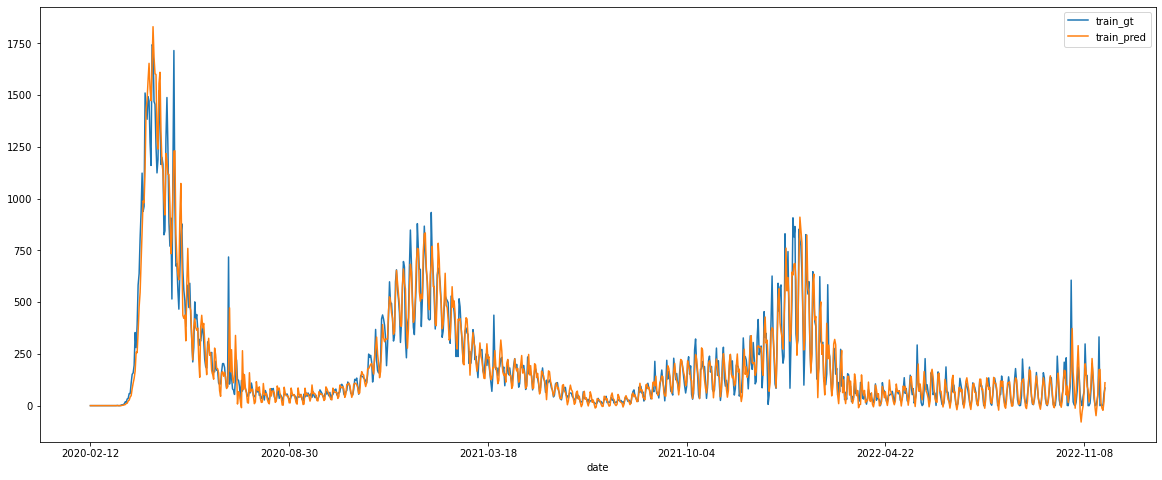

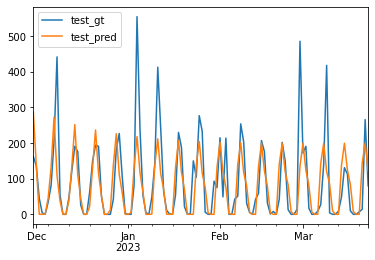

Training Set Metrics:
MAE: 45.66090117861926
MASE: 0.7003226742683571

Testing Set Metrics:
MAE: 49.64701282265064
MASE: 0.5605627946602241


In [1187]:
train_pred=model.fittedvalues
pd.concat([east_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

east_test.index = pd.to_datetime(east_test.index)

test_pred=model.predict(start=len(east_train), end=len(east_train)+len(east_test)-1, dynamic=True)
test_pred = test_pred * 1.5
test_pred[test_pred<0] = 0
pd.concat([east_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(east_train, train_pred)
mase_train = MASE(east_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(east_test, test_pred)
mase_test = MASE(east_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

### midwest

In [1125]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(midwest_train,order=(p,1,q), seasonal_order=(P,1,Q,7)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16820D+00    |proj g|=  7.21047D-02


 This problem is unconstrained.



At iterate    5    f=  6.12411D+00    |proj g|=  9.64476D-03

At iterate   10    f=  6.12163D+00    |proj g|=  2.26862D-03

At iterate   15    f=  6.11691D+00    |proj g|=  1.36652D-02

At iterate   20    f=  6.10802D+00    |proj g|=  9.06996D-03

At iterate   25    f=  6.09312D+00    |proj g|=  2.09478D-02

At iterate   30    f=  6.09176D+00    |proj g|=  2.91330D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     42      1     0     0   1.392D-06   6.092D+00
  F =   6.0917607006887646     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.12333D+00    |proj g|=  1.41753D-02

At iterate   10    f=  6.12159D+00    |proj g|=  3.78679D-03

At iterate   15    f=  6.11167D+00    |proj g|=  2.68681D-02

At iterate   20    f=  6.09714D+00    |proj g|=  4.39396D-02

At iterate   25    f=  6.09186D+00    |proj g|=  2.27448D-03

At iterate   30    f=  6.09183D+00    |proj g|=  2.95142D-03

At iterate   35    f=  6.09166D+00    |proj g|=  6.89562D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     46      1     0     0   1.092D-04   6.092D+00
  F =   6.0916564604287613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.12397D+00    |proj g|=  2.68795D-02

At iterate   10    f=  6.12121D+00    |proj g|=  7.13400D-03

At iterate   15    f=  6.11492D+00    |proj g|=  4.12914D-02

At iterate   20    f=  6.09302D+00    |proj g|=  5.31591D-03

At iterate   25    f=  6.09210D+00    |proj g|=  1.74203D-03

At iterate   30    f=  6.09107D+00    |proj g|=  7.91709D-04

At iterate   35    f=  6.09092D+00    |proj g|=  3.26444D-04

At iterate   40    f=  6.09090D+00    |proj g|=  2.10423D-04

At iterate   45    f=  6.09090D+00    |proj g|=  3.31149D-04

At iterate   50    f=  6.09090D+00    |proj g|=  1.76732D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.12310D+00    |proj g|=  1.48589D-02

At iterate   10    f=  6.12169D+00    |proj g|=  2.79215D-03

At iterate   15    f=  6.11438D+00    |proj g|=  6.18197D-02

At iterate   20    f=  6.09183D+00    |proj g|=  5.78368D-03

At iterate   25    f=  6.09175D+00    |proj g|=  9.99613D-05

At iterate   30    f=  6.09172D+00    |proj g|=  2.19862D-03

At iterate   35    f=  6.09162D+00    |proj g|=  5.87839D-04

At iterate   40    f=  6.09162D+00    |proj g|=  2.37741D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     49      1     0     0   4.723D-06   6.092D+00
  F =   6.09162070598

 This problem is unconstrained.



At iterate    5    f=  6.11523D+00    |proj g|=  2.55551D-03

At iterate   10    f=  6.11470D+00    |proj g|=  6.62012D-03

At iterate   15    f=  6.10818D+00    |proj g|=  2.91666D-02

At iterate   20    f=  6.09312D+00    |proj g|=  8.65499D-03

At iterate   25    f=  6.09284D+00    |proj g|=  9.83940D-03

At iterate   30    f=  6.09119D+00    |proj g|=  1.62016D-02

At iterate   35    f=  6.09079D+00    |proj g|=  4.61722D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     46      1     0     0   4.039D-06   6.091D+00
  F =   6.0907857920405011     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13904D+00    |proj g|=  6.15998D-02

At iterate    5    f=  6.11505D+00    |proj g|=  2.11312D-03

At iterate   10    f=  6.11342D+00    |proj g|=  3.47509D-02

At iterate   15    f=  6.09486D+00    |proj g|=  1.73032D-02

At iterate   20    f=  6.09397D+00    |proj g|=  4.44001D-03

At iterate   25    f=  6.09126D+00    |proj g|=  1.91416D-02

At iterate   30    f=  6.09063D+00    |proj g|=  6.41654D-04

At iterate   35    f=  6.09063D+00    |proj g|=  2.89038D-04

At iterate   40    f=  6.09063D+00    |proj g|=  2.37288D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.11825D+00    |proj g|=  1.19251D-02

At iterate   10    f=  6.11479D+00    |proj g|=  2.10390D-03

At iterate   15    f=  6.11395D+00    |proj g|=  9.24749D-03

At iterate   20    f=  6.09575D+00    |proj g|=  1.72678D-02

At iterate   25    f=  6.09103D+00    |proj g|=  1.80257D-03

At iterate   30    f=  6.08984D+00    |proj g|=  3.23772D-03

At iterate   35    f=  6.08979D+00    |proj g|=  3.47798D-03

At iterate   40    f=  6.08955D+00    |proj g|=  7.32166D-04

At iterate   45    f=  6.08949D+00    |proj g|=  8.82177D-04

At iterate   50    f=  6.08946D+00    |proj g|=  8.51404D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.11507D+00    |proj g|=  3.53778D-03

At iterate   10    f=  6.11374D+00    |proj g|=  1.02211D-02

At iterate   15    f=  6.09543D+00    |proj g|=  3.44014D-02

At iterate   20    f=  6.09338D+00    |proj g|=  1.77489D-03

At iterate   25    f=  6.09117D+00    |proj g|=  9.28479D-03

At iterate   30    f=  6.09075D+00    |proj g|=  3.74530D-04

At iterate   35    f=  6.09074D+00    |proj g|=  1.00898D-03

At iterate   40    f=  6.09063D+00    |proj g|=  2.34027D-03

At iterate   45    f=  6.09061D+00    |proj g|=  1.71640D-04

At iterate   50    f=  6.09061D+00    |proj g|=  1.07187D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.12773D+00    |proj g|=  7.82733D-02

At iterate   10    f=  6.12022D+00    |proj g|=  9.90938D-03

At iterate   15    f=  6.11820D+00    |proj g|=  7.86660D-03

At iterate   20    f=  6.11757D+00    |proj g|=  6.55366D-03

At iterate   25    f=  6.10260D+00    |proj g|=  1.36373D-02

At iterate   30    f=  6.10156D+00    |proj g|=  1.39940D-04

At iterate   35    f=  6.09887D+00    |proj g|=  5.20926D-02

At iterate   40    f=  6.09101D+00    |proj g|=  2.40578D-02

At iterate   45    f=  6.09005D+00    |proj g|=  9.27566D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     67   

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.67763D+00    |proj g|=  9.32105D-01

At iterate    5    f=  6.12040D+00    |proj g|=  9.31182D-03

At iterate   10    f=  6.11896D+00    |proj g|=  1.16430D-02

At iterate   15    f=  6.11782D+00    |proj g|=  7.38020D-03

At iterate   20    f=  6.10372D+00    |proj g|=  3.09451D-02

At iterate   25    f=  6.10141D+00    |proj g|=  1.10449D-03

At iterate   30    f=  6.09768D+00    |proj g|=  5.55314D-02

At iterate   35    f=  6.09085D+00    |proj g|=  1.53849D-02

At iterate   40    f=  6.09022D+00    |proj g|=  6.65734D-04

At iterate   45    f=  6.08995D+00    |proj g|=  3.82758D-03

At iterate   50    f=  6.08982D+00    |proj g|=  2.26227D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 This problem is unconstrained.



At iterate    5    f=  6.12495D+00    |proj g|=  4.61905D-02

At iterate   10    f=  6.11919D+00    |proj g|=  1.19395D-02

At iterate   15    f=  6.11867D+00    |proj g|=  5.41749D-03

At iterate   20    f=  6.10923D+00    |proj g|=  5.18628D-02

At iterate   25    f=  6.09855D+00    |proj g|=  2.50760D-03

At iterate   30    f=  6.09752D+00    |proj g|=  1.88178D-02

At iterate   35    f=  6.09010D+00    |proj g|=  6.40083D-03

At iterate   40    f=  6.09003D+00    |proj g|=  3.06948D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     48      1     0     0   7.307D-06   6.090D+00
  F =   6.09002510290

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.68328D+00    |proj g|=  9.44515D-01

At iterate    5    f=  6.13229D+00    |proj g|=  1.28184D-01

At iterate   10    f=  6.11979D+00    |proj g|=  5.24547D-03

At iterate   15    f=  6.11845D+00    |proj g|=  2.23405D-03

At iterate   20    f=  6.11765D+00    |proj g|=  7.44559D-03

At iterate   25    f=  6.10336D+00    |proj g|=  5.02162D-02

At iterate   30    f=  6.09015D+00    |proj g|=  3.31691D-03

At iterate   35    f=  6.09005D+00    |proj g|=  5.21731D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  6.11587D+00    |proj g|=  2.25116D-02

At iterate   10    f=  6.11488D+00    |proj g|=  6.63600D-03

At iterate   15    f=  6.11128D+00    |proj g|=  4.24178D-02

At iterate   20    f=  6.09724D+00    |proj g|=  3.19813D-02

At iterate   25    f=  6.09129D+00    |proj g|=  1.26467D-02

At iterate   30    f=  6.08895D+00    |proj g|=  2.27120D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     41      1     0     0   2.341D-05   6.089D+00
  F =   6.0889254201504555     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.11504D+00    |proj g|=  6.73393D-03

At iterate   10    f=  6.11470D+00    |proj g|=  9.35988D-03

At iterate   15    f=  6.10617D+00    |proj g|=  5.96579D-02

At iterate   20    f=  6.09402D+00    |proj g|=  4.09311D-02

At iterate   25    f=  6.09035D+00    |proj g|=  6.76414D-03

At iterate   30    f=  6.08897D+00    |proj g|=  1.82173D-03

At iterate   35    f=  6.08834D+00    |proj g|=  1.01565D-02

At iterate   40    f=  6.08794D+00    |proj g|=  1.24272D-03

At iterate   45    f=  6.08792D+00    |proj g|=  1.38387D-04

At iterate   50    f=  6.08792D+00    |proj g|=  6.47630D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.11876D+00    |proj g|=  2.40406D-02

At iterate   10    f=  6.11519D+00    |proj g|=  2.49726D-03

At iterate   15    f=  6.11434D+00    |proj g|=  5.04116D-03

At iterate   20    f=  6.11212D+00    |proj g|=  3.06637D-02

At iterate   25    f=  6.10402D+00    |proj g|=  1.77437D-02

At iterate   30    f=  6.09165D+00    |proj g|=  1.16739D-02

At iterate   35    f=  6.08961D+00    |proj g|=  1.42285D-02

At iterate   40    f=  6.08915D+00    |proj g|=  1.92124D-04

At iterate   45    f=  6.08908D+00    |proj g|=  1.66025D-03

At iterate   50    f=  6.08905D+00    |proj g|=  3.69305D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.11567D+00    |proj g|=  1.73216D-02

At iterate   10    f=  6.11490D+00    |proj g|=  5.65340D-03

At iterate   15    f=  6.11353D+00    |proj g|=  1.59097D-02

At iterate   20    f=  6.09804D+00    |proj g|=  3.86801D-02

At iterate   25    f=  6.09231D+00    |proj g|=  1.16198D-02

At iterate   30    f=  6.08880D+00    |proj g|=  3.11655D-03

At iterate   35    f=  6.08863D+00    |proj g|=  8.76188D-04

At iterate   40    f=  6.08801D+00    |proj g|=  7.67548D-03

At iterate   45    f=  6.08790D+00    |proj g|=  3.99397D-04

At iterate   50    f=  6.08790D+00    |proj g|=  1.69746D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [1126]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
13  2  2  1  2  12459.701957
12  2  2  1  1  12459.763559
8   2  1  1  1  12460.061466
6   1  2  2  1  12460.857279
0   1  1  1  1  12461.558872
4   1  2  1  1  12461.566159
9   2  1  1  2  12461.581913
15  2  2  2  2  12461.666887
2   1  1  2  1  12461.795015
10  2  1  2  1  12462.011310
14  2  2  2  1  12462.017420
5   1  2  1  2  12463.239475
1   1  1  1  2  12463.345805
11  2  1  2  2  12464.059037
7   1  2  2  2  12465.196666
3   1  1  2  2  12465.272723

In [1132]:
model=sm.tsa.statespace.SARIMAX(midwest_train,order=(2, 1, 2),seasonal_order=(1,1,2,7))
model=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13171D+00    |proj g|=  5.78248D-02


 This problem is unconstrained.



At iterate    5    f=  6.11504D+00    |proj g|=  6.73393D-03

At iterate   10    f=  6.11470D+00    |proj g|=  9.35988D-03

At iterate   15    f=  6.10617D+00    |proj g|=  5.96579D-02

At iterate   20    f=  6.09402D+00    |proj g|=  4.09311D-02

At iterate   25    f=  6.09035D+00    |proj g|=  6.76414D-03

At iterate   30    f=  6.08897D+00    |proj g|=  1.82173D-03

At iterate   35    f=  6.08834D+00    |proj g|=  1.01565D-02

At iterate   40    f=  6.08794D+00    |proj g|=  1.24272D-03

At iterate   45    f=  6.08792D+00    |proj g|=  1.38387D-04

At iterate   50    f=  6.08792D+00    |proj g|=  6.47630D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

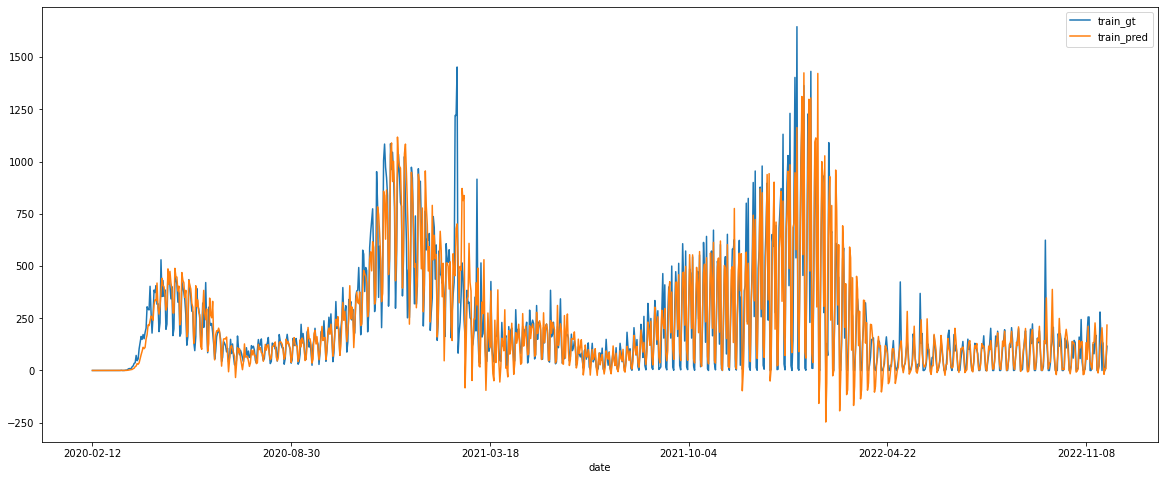

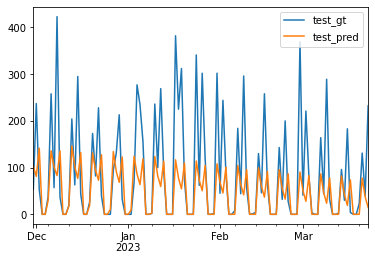

Training Set Metrics:
MAE: 64.16457404060617
MASE: 0.47062563824843673

Testing Set Metrics:
MAE: 59.95126668918454
MASE: 0.5180860458762506


In [1133]:
train_pred=model.fittedvalues
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=model.predict(start=len(midwest_train), end=len(midwest_train)+len(midwest_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(midwest_train, train_pred)
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(midwest_test, test_pred)
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1136]:
midwest_auto = auto_arima(midwest_train, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=7,
                           start_P=0, start_Q = 0, max_Q = 2, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(midwest_auto.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=13086.169, Time=0.11 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=12737.107, Time=0.61 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=12494.030, Time=0.71 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=12729.946, Time=0.27 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=12495.535, Time=0.76 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=12495.482, Time=0.78 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=12572.488, Time=0.48 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=1.45 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=12865.829, Time=0.34 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=12460.460, Time=1.20 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=12461.559, Time=1.46 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=12461.557, Time=1.86 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=inf, Time=1.04 sec
 ARIMA(1,1,1)(1,1,2)[7]             :

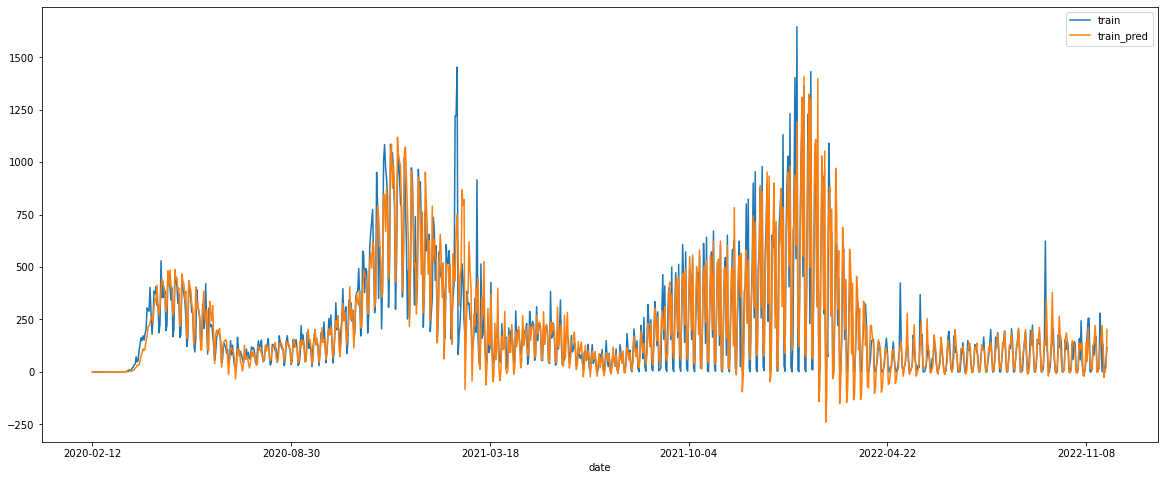

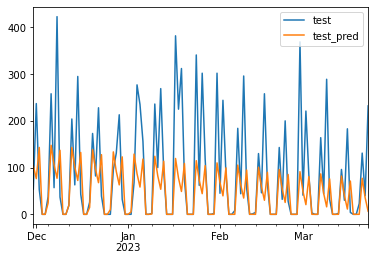

Training Set Metrics:
MAE: 64.35728056958315
MASE: 0.4720390760301173

Testing Set Metrics:
MAE: 60.71155147668132
MASE: 0.5246562646730644


In [1158]:
train_pred=midwest_auto.fittedvalues()
pd.concat([midwest_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

midwest_test.index = pd.to_datetime(midwest_test.index)

test_pred=midwest_auto.predict(n_periods=len(midwest_test))
test_pred[test_pred<0] = 0
pd.concat([midwest_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(midwest_train, train_pred)
mase_train = MASE(midwest_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(midwest_test, test_pred)
mase_test = MASE(midwest_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1138]:
n_periods=7
forecast, conf_int = midwest_auto.predict(n_periods=n_periods, return_conf_int=True)
forecast[forecast<0] = 0

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2022-11-30    103.951394
2022-12-01     76.383476
2022-12-02    143.089109
2022-12-03      0.000000
2022-12-04      0.000000
2022-12-05     24.229206
2022-12-06    147.730237
Freq: D, dtype: float64
Confidence Interval: [[-114.7878329   322.69062042]
 [-152.18193322  304.94888461]
 [ -90.63582947  376.81404725]
 [-243.29893945  225.49360508]
 [-244.02681245  226.87423198]
 [-212.29895302  260.75736481]
 [ -90.15730335  385.61777791]]


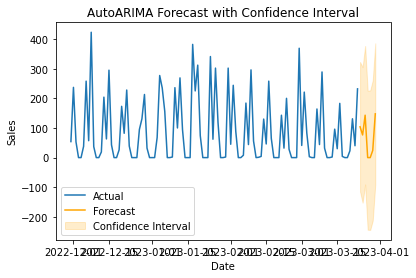

In [1139]:
forecast_index = pd.date_range(midwest_test.index[-1], periods=n_periods + 1, freq=midwest_test.index.freq)[-n_periods:]

plt.plot(midwest_test.index, midwest_test['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### south

In [1143]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(south_train,order=(p,0,q), seasonal_order=(P,0,Q,7)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.94843D+00    |proj g|=  2.05157D-01


 This problem is unconstrained.



At iterate    5    f=  6.87658D+00    |proj g|=  9.25209D-03

At iterate   10    f=  6.86756D+00    |proj g|=  1.96161D-03

At iterate   15    f=  6.83760D+00    |proj g|=  6.12061D-02

At iterate   20    f=  6.73603D+00    |proj g|=  2.91393D-02

At iterate   25    f=  6.70277D+00    |proj g|=  2.65597D-03

At iterate   30    f=  6.70268D+00    |proj g|=  1.69922D-04

At iterate   35    f=  6.70263D+00    |proj g|=  9.22079D-04
  ys=-3.282E-03  -gs= 6.617E-04 BFGS update SKIPPED

At iterate   40    f=  6.69616D+00    |proj g|=  1.81030D-02

At iterate   45    f=  6.69459D+00    |proj g|=  5.00111D-04

At iterate   50    f=  6.69457D+00    |proj g|=  7.53850D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  6.87663D+00    |proj g|=  7.85815D-03

At iterate   10    f=  6.86912D+00    |proj g|=  1.09233D-02

At iterate   15    f=  6.86667D+00    |proj g|=  4.61353D-03

At iterate   20    f=  6.81772D+00    |proj g|=  2.26045D-02

At iterate   25    f=  6.76207D+00    |proj g|=  9.54327D-02

At iterate   30    f=  6.70978D+00    |proj g|=  8.09397D-03

At iterate   35    f=  6.70236D+00    |proj g|=  1.74984D-02

At iterate   40    f=  6.70157D+00    |proj g|=  4.90339D-04

At iterate   45    f=  6.69488D+00    |proj g|=  1.26785D-02

At iterate   50    f=  6.69457D+00    |proj g|=  5.92067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.87719D+00    |proj g|=  5.92441D-03

At iterate   10    f=  6.86993D+00    |proj g|=  4.38141D-03

At iterate   15    f=  6.86261D+00    |proj g|=  2.97053D-03

At iterate   20    f=  6.78683D+00    |proj g|=  7.65705D-02

At iterate   25    f=  6.77163D+00    |proj g|=  8.15070D-03

At iterate   30    f=  6.71153D+00    |proj g|=  6.80320D-02

At iterate   35    f=  6.70373D+00    |proj g|=  3.20347D-03

At iterate   40    f=  6.70347D+00    |proj g|=  1.40415D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     53      1     0     0   1.404D-05   6.703D+00
  F =   6.70346861482

 This problem is unconstrained.



At iterate    5    f=  6.87608D+00    |proj g|=  8.21706D-03

At iterate   10    f=  6.86976D+00    |proj g|=  9.75107D-03

At iterate   15    f=  6.86536D+00    |proj g|=  2.53612D-02

At iterate   20    f=  6.80335D+00    |proj g|=  1.57622D-02

At iterate   25    f=  6.77884D+00    |proj g|=  3.37963D-02

At iterate   30    f=  6.77534D+00    |proj g|=  2.29314D-02

At iterate   35    f=  6.76851D+00    |proj g|=  3.02271D-03

At iterate   40    f=  6.76835D+00    |proj g|=  2.70368D-03

At iterate   45    f=  6.73452D+00    |proj g|=  8.47033D-02

At iterate   50    f=  6.70440D+00    |proj g|=  5.96062D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.19156D+00    |proj g|=  3.10160D+00

At iterate    5    f=  6.84733D+00    |proj g|=  1.03347D-02

At iterate   10    f=  6.82939D+00    |proj g|=  2.97870D-02

At iterate   15    f=  6.82219D+00    |proj g|=  1.12829D-02

At iterate   20    f=  6.82007D+00    |proj g|=  7.60127D-03

At iterate   25    f=  6.71035D+00    |proj g|=  1.25197D-01

At iterate   30    f=  6.69995D+00    |proj g|=  4.76011D-04

At iterate   35    f=  6.69993D+00    |proj g|=  3.25465D-03
  ys=-7.107E-03  -gs= 9.043E-04 BFGS update SKIPPED

At iterate   40    f=  6.69525D+00    |proj g|=  3.56608D-02

At iterate   45    f=  6.69358D+00    |proj g|=  5.65905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy search

 This problem is unconstrained.



At iterate    5    f=  6.84762D+00    |proj g|=  1.03435D-02

At iterate   10    f=  6.83135D+00    |proj g|=  2.89527D-02

At iterate   15    f=  6.82454D+00    |proj g|=  7.20315D-03

At iterate   20    f=  6.82070D+00    |proj g|=  2.40698D-03

At iterate   25    f=  6.81951D+00    |proj g|=  2.17455D-02

At iterate   30    f=  6.76405D+00    |proj g|=  1.86243D-01

At iterate   35    f=  6.72725D+00    |proj g|=  3.64553D-02

At iterate   40    f=  6.69443D+00    |proj g|=  9.81669D-03

At iterate   45    f=  6.69356D+00    |proj g|=  3.76356D-04

At iterate   50    f=  6.69356D+00    |proj g|=  6.97297D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  6.82758D+00    |proj g|=  1.59353D-02

At iterate   15    f=  6.82342D+00    |proj g|=  6.15956D-03

At iterate   20    f=  6.81703D+00    |proj g|=  2.31841D-03

At iterate   25    f=  6.81458D+00    |proj g|=  3.29491D-02

At iterate   30    f=  6.73235D+00    |proj g|=  9.91296D-02

At iterate   35    f=  6.70472D+00    |proj g|=  3.70160D-03

At iterate   40    f=  6.70130D+00    |proj g|=  5.42731D-03

At iterate   45    f=  6.70105D+00    |proj g|=  5.79701D-05

At iterate   50    f=  6.70105D+00    |proj g|=  4.27281D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57   

 This problem is unconstrained.



At iterate    5    f=  6.84591D+00    |proj g|=  8.02655D-03

At iterate   10    f=  6.83300D+00    |proj g|=  4.12706D-02

At iterate   15    f=  6.82346D+00    |proj g|=  7.96933D-03

At iterate   20    f=  6.82048D+00    |proj g|=  5.73626D-03

At iterate   25    f=  6.77676D+00    |proj g|=  2.28407D-02

At iterate   30    f=  6.75841D+00    |proj g|=  3.71071D-03

At iterate   35    f=  6.72926D+00    |proj g|=  1.26396D-01

At iterate   40    f=  6.69693D+00    |proj g|=  1.42255D-03

At iterate   45    f=  6.69691D+00    |proj g|=  1.20356D-03

At iterate   50    f=  6.69665D+00    |proj g|=  2.02926D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  6.86436D+00    |proj g|=  7.06308D-03

At iterate   15    f=  6.85884D+00    |proj g|=  9.21057D-03

At iterate   20    f=  6.85674D+00    |proj g|=  3.99980D-03

At iterate   25    f=  6.79725D+00    |proj g|=  2.30546D-01

At iterate   30    f=  6.75123D+00    |proj g|=  5.76378D-04
  ys=-3.660E-03  -gs= 3.106E-03 BFGS update SKIPPED

At iterate   35    f=  6.73178D+00    |proj g|=  1.72195D-01

At iterate   40    f=  6.70493D+00    |proj g|=  3.02910D-02

At iterate   45    f=  6.70210D+00    |proj g|=  1.83607D-03

At iterate   50    f=  6.70210D+00    |proj g|=  9.56923D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.91483D+00    |proj g|=  1.50883D-01

At iterate    5    f=  6.88252D+00    |proj g|=  8.30787D-03

At iterate   10    f=  6.86548D+00    |proj g|=  2.48310D-02

At iterate   15    f=  6.85791D+00    |proj g|=  1.13158D-02

At iterate   20    f=  6.85631D+00    |proj g|=  7.87581D-03

At iterate   25    f=  6.77130D+00    |proj g|=  1.21530D-01

At iterate   30    f=  6.70239D+00    |proj g|=  1.29381D-02

At iterate   35    f=  6.70209D+00    |proj g|=  1.31389D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  6.88302D+00    |proj g|=  5.85092D-03

At iterate   10    f=  6.86898D+00    |proj g|=  2.21677D-02

At iterate   15    f=  6.86208D+00    |proj g|=  1.04034D-02

At iterate   20    f=  6.85516D+00    |proj g|=  2.35509D-03

At iterate   25    f=  6.85386D+00    |proj g|=  7.60951D-03

At iterate   30    f=  6.79552D+00    |proj g|=  4.77780D-02

At iterate   35    f=  6.75752D+00    |proj g|=  2.58141D-02

At iterate   40    f=  6.74680D+00    |proj g|=  3.91241D-02

At iterate   45    f=  6.72913D+00    |proj g|=  5.80729D-02

At iterate   50    f=  6.70240D+00    |proj g|=  1.22573D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.88089D+00    |proj g|=  7.16259D-03

At iterate   10    f=  6.86982D+00    |proj g|=  2.69704D-02

At iterate   15    f=  6.85998D+00    |proj g|=  9.49131D-03

At iterate   20    f=  6.85440D+00    |proj g|=  5.26167D-03

At iterate   25    f=  6.76607D+00    |proj g|=  4.37329D-02

At iterate   30    f=  6.75352D+00    |proj g|=  1.20499D-02

At iterate   35    f=  6.74911D+00    |proj g|=  3.22234D-03

At iterate   40    f=  6.71142D+00    |proj g|=  9.20483D-02

At iterate   45    f=  6.69640D+00    |proj g|=  7.87361D-04

At iterate   50    f=  6.69639D+00    |proj g|=  2.99706D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.84227D+00    |proj g|=  2.57412D-02

At iterate   10    f=  6.82043D+00    |proj g|=  3.02338D-03

At iterate   15    f=  6.81696D+00    |proj g|=  8.12440D-03

At iterate   20    f=  6.81480D+00    |proj g|=  9.82766D-03

At iterate   25    f=  6.81249D+00    |proj g|=  8.56526D-03

At iterate   30    f=  6.70740D+00    |proj g|=  6.96238D-02

At iterate   35    f=  6.69852D+00    |proj g|=  1.26152D-03

At iterate   40    f=  6.69777D+00    |proj g|=  1.16446D-02

At iterate   45    f=  6.69256D+00    |proj g|=  2.99295D-03

At iterate   50    f=  6.69229D+00    |proj g|=  3.79175D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.84223D+00    |proj g|=  3.29052D-02

At iterate   10    f=  6.82451D+00    |proj g|=  2.56951D-02

At iterate   15    f=  6.81880D+00    |proj g|=  3.52995D-03

At iterate   20    f=  6.81554D+00    |proj g|=  6.35559D-03

At iterate   25    f=  6.81203D+00    |proj g|=  1.33000D-02

At iterate   30    f=  6.79515D+00    |proj g|=  5.54941D-02

At iterate   35    f=  6.71467D+00    |proj g|=  7.21326D-02

At iterate   40    f=  6.69456D+00    |proj g|=  9.49646D-03

At iterate   45    f=  6.69413D+00    |proj g|=  4.40375D-03

At iterate   50    f=  6.69327D+00    |proj g|=  8.55246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.84390D+00    |proj g|=  2.63491D-02

At iterate   10    f=  6.82019D+00    |proj g|=  3.92577D-03

At iterate   15    f=  6.81799D+00    |proj g|=  2.28670D-03

At iterate   20    f=  6.81375D+00    |proj g|=  4.04526D-03

At iterate   25    f=  6.80535D+00    |proj g|=  1.92211D-02

At iterate   30    f=  6.71176D+00    |proj g|=  3.53021D-02

At iterate   35    f=  6.69925D+00    |proj g|=  8.31945D-03

At iterate   40    f=  6.69349D+00    |proj g|=  4.35700D-03

At iterate   45    f=  6.69328D+00    |proj g|=  5.47664D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     63   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.87823D+00    |proj g|=  1.73785D-01

At iterate    5    f=  6.84113D+00    |proj g|=  3.34772D-02

At iterate   10    f=  6.81932D+00    |proj g|=  1.52667D-02

At iterate   15    f=  6.81698D+00    |proj g|=  1.89165D-03

At iterate   20    f=  6.81053D+00    |proj g|=  8.15016D-02

At iterate   25    f=  6.71544D+00    |proj g|=  3.30765D-02

At iterate   30    f=  6.70210D+00    |proj g|=  1.14853D-02
  ys=-3.199E-05  -gs= 1.501E-04 BFGS update SKIPPED

At iterate   35    f=  6.70159D+00    |proj g|=  2.18444D-03
  ys=-1.402E-04  -gs= 4.995E-04 BFGS update SKIPPED

At iterate   40    f=  6.70159D+00    |proj g|=  2.25499D-03
  ys=-5.502E-07  -gs= 4.136E-07 BFGS update SKIPPED

At iterate   45    f=  6.70158D+00    |proj g|=  2.15910D-03

           * * *

Tit   = total number of iterations
Tnf

In [1144]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
12  2  2  1  1  13693.036883
4   1  2  1  1  13693.665498
0   1  1  1  1  13693.698490
5   1  2  1  2  13695.642610
1   1  1  1  2  13695.691148
14  2  2  2  1  13696.984547
13  2  2  1  2  13697.040130
11  2  1  2  2  13703.425520
7   1  2  2  2  13703.960253
6   1  2  2  1  13710.941730
8   2  1  1  1  13711.083216
9   2  1  1  2  13713.067535
10  2  1  2  1  13713.701151
2   1  1  2  1  13713.889849
15  2  2  2  2  13715.872451
3   1  1  2  2  13717.793648

In [1145]:
model=sm.tsa.statespace.SARIMAX(south_train,order=(2, 0, 2),seasonal_order=(1,0,1,7))
model=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.87633D+00    |proj g|=  1.62885D-01

At iterate    5    f=  6.84227D+00    |proj g|=  2.57412D-02


 This problem is unconstrained.



At iterate   10    f=  6.82043D+00    |proj g|=  3.02338D-03

At iterate   15    f=  6.81696D+00    |proj g|=  8.12440D-03

At iterate   20    f=  6.81480D+00    |proj g|=  9.82766D-03

At iterate   25    f=  6.81249D+00    |proj g|=  8.56526D-03

At iterate   30    f=  6.70740D+00    |proj g|=  6.96238D-02

At iterate   35    f=  6.69852D+00    |proj g|=  1.26152D-03

At iterate   40    f=  6.69777D+00    |proj g|=  1.16446D-02

At iterate   45    f=  6.69256D+00    |proj g|=  2.99295D-03

At iterate   50    f=  6.69229D+00    |proj g|=  3.79175D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61   

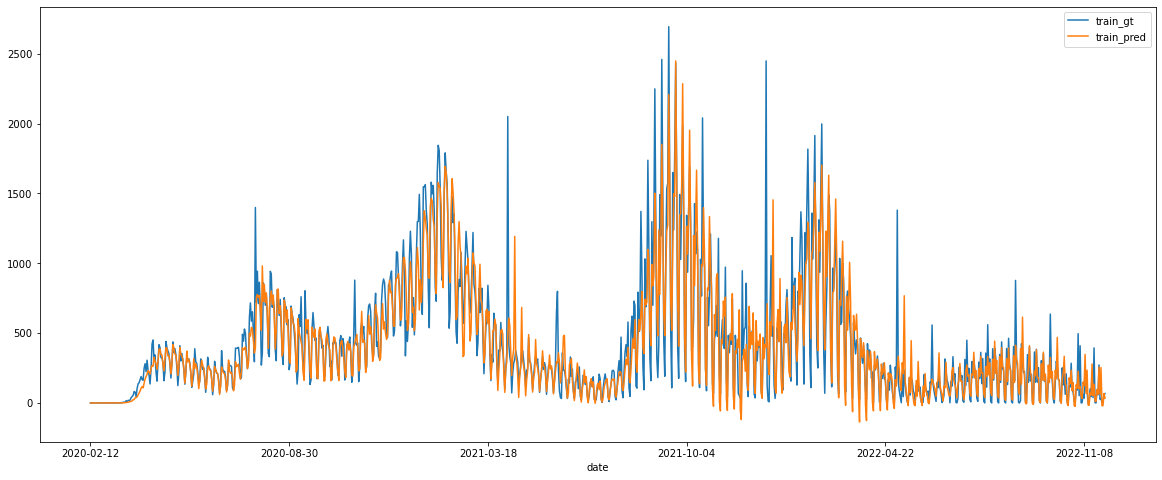

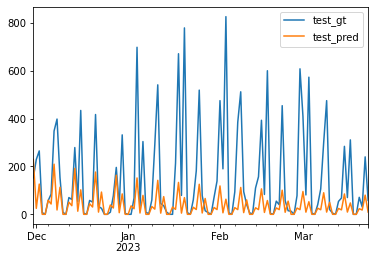

Training Set Metrics:
MAE: 108.8093225785206
MASE: 0.5315848275379307

Testing Set Metrics:
MAE: 118.67262426008382
MASE: 0.613926957899074


In [1146]:
train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1147]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(south_train,order=(p,1,q), seasonal_order=(P,1,Q,7)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72253D+00    |proj g|=  6.06693D-02


 This problem is unconstrained.



At iterate    5    f=  6.69209D+00    |proj g|=  4.03503D-03

At iterate   10    f=  6.69153D+00    |proj g|=  1.26465D-03

At iterate   15    f=  6.68891D+00    |proj g|=  1.40392D-02

At iterate   20    f=  6.67939D+00    |proj g|=  2.83249D-02

At iterate   25    f=  6.67594D+00    |proj g|=  6.21503D-03

At iterate   30    f=  6.66985D+00    |proj g|=  5.72126D-02

At iterate   35    f=  6.66232D+00    |proj g|=  6.27465D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     56      1     0     0   2.447D-06   6.662D+00
  F =   6.6623193680051704     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  6.69261D+00    |proj g|=  2.56809D-03

At iterate   10    f=  6.69248D+00    |proj g|=  3.95610D-03

At iterate   15    f=  6.68670D+00    |proj g|=  7.77772D-02

At iterate   20    f=  6.65712D+00    |proj g|=  1.83339D-02

At iterate   25    f=  6.65260D+00    |proj g|=  1.45100D-02

At iterate   30    f=  6.64261D+00    |proj g|=  4.23311D-03

At iterate   35    f=  6.64246D+00    |proj g|=  1.85232D-03

At iterate   40    f=  6.64220D+00    |proj g|=  5.29764D-04

At iterate   45    f=  6.64217D+00    |proj g|=  3.39926D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     56   

 This problem is unconstrained.



At iterate    5    f=  6.69611D+00    |proj g|=  1.41147D-02

At iterate   10    f=  6.69000D+00    |proj g|=  3.64894D-02

At iterate   15    f=  6.68055D+00    |proj g|=  2.91842D-03

At iterate   20    f=  6.68023D+00    |proj g|=  1.36029D-03

At iterate   25    f=  6.65930D+00    |proj g|=  2.11775D-02

At iterate   30    f=  6.64802D+00    |proj g|=  8.04564D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     40      1     0     0   2.063D-06   6.648D+00
  F =   6.6480192403395284     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.69154D+00    |proj g|=  3.22587D-03

At iterate   10    f=  6.69042D+00    |proj g|=  1.92436D-02

At iterate   15    f=  6.68325D+00    |proj g|=  3.98016D-02

At iterate   20    f=  6.67516D+00    |proj g|=  1.05488D-02

At iterate   25    f=  6.67306D+00    |proj g|=  1.86435D-02

At iterate   30    f=  6.65233D+00    |proj g|=  4.22222D-02

At iterate   35    f=  6.64725D+00    |proj g|=  4.96106D-02

At iterate   40    f=  6.64248D+00    |proj g|=  8.31451D-03

At iterate   45    f=  6.64205D+00    |proj g|=  2.68812D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     57   

 This problem is unconstrained.



At iterate    5    f=  6.68317D+00    |proj g|=  2.74334D-02

At iterate   10    f=  6.67724D+00    |proj g|=  7.97134D-03

At iterate   15    f=  6.67713D+00    |proj g|=  5.22852D-03

At iterate   20    f=  6.67668D+00    |proj g|=  1.30071D-02

At iterate   25    f=  6.67533D+00    |proj g|=  3.56426D-03

At iterate   30    f=  6.67208D+00    |proj g|=  1.96297D-02

At iterate   35    f=  6.66355D+00    |proj g|=  7.07678D-03

At iterate   40    f=  6.66336D+00    |proj g|=  1.08409D-03

At iterate   45    f=  6.66304D+00    |proj g|=  1.69838D-02

At iterate   50    f=  6.66235D+00    |proj g|=  4.67769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.68279D+00    |proj g|=  2.16668D-02

At iterate   10    f=  6.67804D+00    |proj g|=  1.53929D-03

At iterate   15    f=  6.67784D+00    |proj g|=  6.69368D-03

At iterate   20    f=  6.66850D+00    |proj g|=  3.69911D-02

At iterate   25    f=  6.66483D+00    |proj g|=  1.01800D-03

At iterate   30    f=  6.66480D+00    |proj g|=  1.74196D-03

At iterate   35    f=  6.66466D+00    |proj g|=  8.44628D-04

At iterate   40    f=  6.66465D+00    |proj g|=  6.69290D-05

At iterate   45    f=  6.66462D+00    |proj g|=  1.44882D-03

At iterate   50    f=  6.66458D+00    |proj g|=  4.10018D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.69587D+00    |proj g|=  4.74391D-02

At iterate   10    f=  6.67769D+00    |proj g|=  2.42165D-02

At iterate   15    f=  6.67123D+00    |proj g|=  2.55625D-02

At iterate   20    f=  6.66471D+00    |proj g|=  2.59782D-03

At iterate   25    f=  6.66453D+00    |proj g|=  1.25653D-03

At iterate   30    f=  6.66121D+00    |proj g|=  2.89896D-02

At iterate   35    f=  6.64870D+00    |proj g|=  5.05876D-03

At iterate   40    f=  6.64867D+00    |proj g|=  7.34423D-04

At iterate   45    f=  6.64856D+00    |proj g|=  9.84836D-03

At iterate   50    f=  6.64805D+00    |proj g|=  2.55183D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.70277D+00    |proj g|=  8.72436D-02

At iterate   10    f=  6.67793D+00    |proj g|=  2.58511D-02

At iterate   15    f=  6.67651D+00    |proj g|=  1.03398D-02

At iterate   20    f=  6.67497D+00    |proj g|=  1.89597D-02

At iterate   25    f=  6.67036D+00    |proj g|=  2.74006D-02

At iterate   30    f=  6.66314D+00    |proj g|=  1.56790D-02

At iterate   35    f=  6.65890D+00    |proj g|=  9.43261D-03

At iterate   40    f=  6.64907D+00    |proj g|=  6.86589D-02

At iterate   45    f=  6.64279D+00    |proj g|=  1.63470D-03

At iterate   50    f=  6.64273D+00    |proj g|=  1.63912D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.69168D+00    |proj g|=  8.38391D-03

At iterate   10    f=  6.69140D+00    |proj g|=  2.37607D-03

At iterate   15    f=  6.69063D+00    |proj g|=  1.42196D-02

At iterate   20    f=  6.69001D+00    |proj g|=  1.04616D-02

At iterate   25    f=  6.67533D+00    |proj g|=  2.63608D-02

At iterate   30    f=  6.66269D+00    |proj g|=  8.83071D-03

At iterate   35    f=  6.66232D+00    |proj g|=  5.25788D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     45      1     0     0   1.979D-05   6.662D+00
  F =   6.6623181149158812     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.69275D+00    |proj g|=  1.04951D-02

At iterate   10    f=  6.69227D+00    |proj g|=  5.39913D-03

At iterate   15    f=  6.68180D+00    |proj g|=  6.89777D-02

At iterate   20    f=  6.65391D+00    |proj g|=  7.98391D-03

At iterate   25    f=  6.65005D+00    |proj g|=  2.64257D-02

At iterate   30    f=  6.64307D+00    |proj g|=  4.69972D-03

At iterate   35    f=  6.64227D+00    |proj g|=  2.19469D-03

At iterate   40    f=  6.64217D+00    |proj g|=  3.16776D-04

At iterate   45    f=  6.64217D+00    |proj g|=  8.41700D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     52   

 This problem is unconstrained.



At iterate    5    f=  6.69405D+00    |proj g|=  2.24801D-02

At iterate   10    f=  6.68665D+00    |proj g|=  2.62712D-02

At iterate   15    f=  6.68037D+00    |proj g|=  4.33718D-03

At iterate   20    f=  6.68017D+00    |proj g|=  4.90620D-03

At iterate   25    f=  6.67777D+00    |proj g|=  2.05697D-02

At iterate   30    f=  6.65016D+00    |proj g|=  3.16229D-02

At iterate   35    f=  6.64799D+00    |proj g|=  1.62452D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     42      1     0     0   1.744D-06   6.648D+00
  F =   6.6479879141945002     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  6.69207D+00    |proj g|=  2.49536D-02

At iterate   10    f=  6.69035D+00    |proj g|=  6.41019D-03

At iterate   15    f=  6.68909D+00    |proj g|=  7.85635D-03

At iterate   20    f=  6.68181D+00    |proj g|=  2.03379D-02

At iterate   25    f=  6.67595D+00    |proj g|=  4.13591D-03

At iterate   30    f=  6.67139D+00    |proj g|=  7.65191D-03

At iterate   35    f=  6.65913D+00    |proj g|=  8.64024D-03

At iterate   40    f=  6.65780D+00    |proj g|=  1.76095D-02

At iterate   45    f=  6.65736D+00    |proj g|=  7.87071D-03

At iterate   50    f=  6.64983D+00    |proj g|=  2.00423D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  6.68055D+00    |proj g|=  2.19524D-02

At iterate   10    f=  6.67520D+00    |proj g|=  3.09825D-03

At iterate   15    f=  6.67509D+00    |proj g|=  2.40723D-03

At iterate   20    f=  6.67396D+00    |proj g|=  5.46278D-03

At iterate   25    f=  6.67238D+00    |proj g|=  1.94544D-02

At iterate   30    f=  6.66703D+00    |proj g|=  5.21315D-03

At iterate   35    f=  6.66192D+00    |proj g|=  7.24058D-03

At iterate   40    f=  6.65926D+00    |proj g|=  6.46036D-04

At iterate   45    f=  6.65925D+00    |proj g|=  9.05782D-04

At iterate   50    f=  6.65925D+00    |proj g|=  2.38078D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92298D+00    |proj g|=  5.88766D-01

At iterate    5    f=  6.67625D+00    |proj g|=  1.14798D-03

At iterate   10    f=  6.67617D+00    |proj g|=  5.11807D-03

At iterate   15    f=  6.67364D+00    |proj g|=  3.22103D-02

At iterate   20    f=  6.66694D+00    |proj g|=  2.82790D-02

At iterate   25    f=  6.65985D+00    |proj g|=  5.41825D-03

At iterate   30    f=  6.65110D+00    |proj g|=  3.49244D-02

At iterate   35    f=  6.64676D+00    |proj g|=  2.04433D-02

At iterate   40    f=  6.64004D+00    |proj g|=  4.46097D-03

At iterate   45    f=  6.63998D+00    |proj g|=  1.63891D-03

At iterate   50    f=  6.63986D+00    |proj g|=  6.72724D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.68381D+00    |proj g|=  1.37360D-02

At iterate   10    f=  6.67641D+00    |proj g|=  4.52081D-02

At iterate   15    f=  6.66393D+00    |proj g|=  1.20002D-02

At iterate   20    f=  6.66263D+00    |proj g|=  1.05510D-03

At iterate   25    f=  6.66207D+00    |proj g|=  7.68321D-03

At iterate   30    f=  6.65601D+00    |proj g|=  2.78527D-02

At iterate   35    f=  6.64701D+00    |proj g|=  1.61542D-02

At iterate   40    f=  6.64466D+00    |proj g|=  6.79692D-04

At iterate   45    f=  6.64460D+00    |proj g|=  3.10411D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     51   

 This problem is unconstrained.



At iterate    5    f=  6.67632D+00    |proj g|=  7.32021D-03

At iterate   10    f=  6.67411D+00    |proj g|=  1.26324D-02

At iterate   15    f=  6.67341D+00    |proj g|=  5.30162D-03

At iterate   20    f=  6.66895D+00    |proj g|=  5.14117D-02

At iterate   25    f=  6.66105D+00    |proj g|=  1.90605D-02

At iterate   30    f=  6.65706D+00    |proj g|=  3.28575D-03

At iterate   35    f=  6.65349D+00    |proj g|=  9.28307D-03

At iterate   40    f=  6.64244D+00    |proj g|=  1.21502D-02

At iterate   45    f=  6.64034D+00    |proj g|=  1.81610D-03

At iterate   50    f=  6.64031D+00    |proj g|=  3.52309D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [1148]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
13  2  2  1  2  13587.865739
1   1  1  1  2  13588.601516
3   1  1  2  2  13590.355580
9   2  1  1  2  13590.596556
15  2  2  2  2  13590.800050
7   1  2  2  2  13593.749060
14  2  2  2  1  13597.540928
2   1  1  2  1  13600.551327
10  2  1  2  1  13602.487297
6   1  2  2  1  13602.610988
11  2  1  2  2  13608.252174
12  2  2  1  1  13625.498457
0   1  1  1  1  13627.780788
8   2  1  1  1  13629.778227
4   1  2  1  1  13629.843811
5   1  2  1  2  13636.399428

In [1149]:
model=sm.tsa.statespace.SARIMAX(south_train,order=(2, 1, 2),seasonal_order=(1,1,2,7))
model=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92298D+00    |proj g|=  5.88766D-01

At iterate    5    f=  6.67625D+00    |proj g|=  1.14798D-03

At iterate   10    f=  6.67617D+00    |proj g|=  5.11807D-03

At iterate   15    f=  6.67364D+00    |proj g|=  3.22103D-02

At iterate   20    f=  6.66694D+00    |proj g|=  2.82790D-02

At iterate   25    f=  6.65985D+00    |proj g|=  5.41825D-03

At iterate   30    f=  6.65110D+00    |proj g|=  3.49244D-02

At iterate   35    f=  6.64676D+00    |proj g|=  2.04433D-02

At iterate   40    f=  6.64004D+00    |proj g|=  4.46097D-03

At iterate   45    f=  6.63998D+00    |proj g|=  1.63891D-03

At iterate   50    f=  6.63986D+00    |proj g|=  6.72724D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

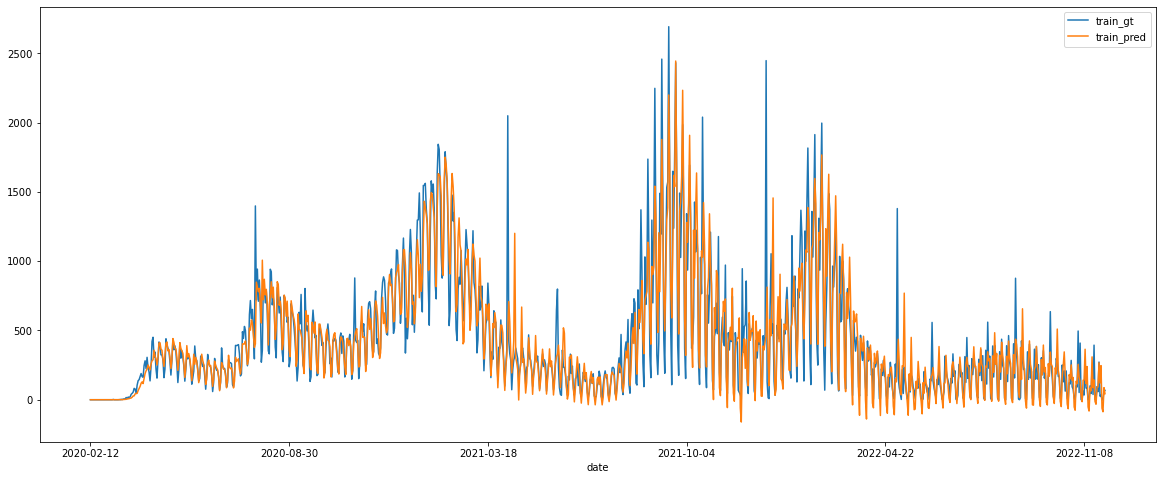

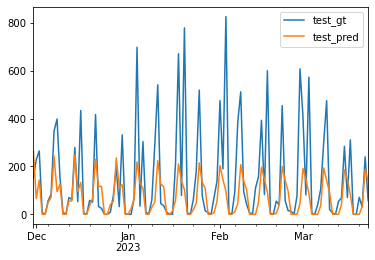

Training Set Metrics:
MAE: 111.83290311753073
MASE: 0.5463564436208896

Testing Set Metrics:
MAE: 104.26040552073077
MASE: 0.5393684852741188


In [1150]:
train_pred=model.fittedvalues
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

south_test.index = pd.to_datetime(south_test.index)

test_pred=model.predict(start=len(south_train), end=len(south_train)+len(south_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1151]:
south_auto = auto_arima(south_train, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=7,
                           start_P=0, start_Q = 0, max_Q = 2, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(south_auto.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=13854.401, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=14440.255, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=13958.042, Time=0.54 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=13630.355, Time=0.71 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=13854.947, Time=0.29 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=13629.059, Time=1.70 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=13696.711, Time=0.46 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=2.15 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=3.08 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=13629.727, Time=0.91 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=13656.572, Time=0.84 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=inf, Time=3.77 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=14106.335, Time=1.04 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=13627.781, Time=3.56 sec
 ARIMA(1,1,1)(0,1,1)[7]             :

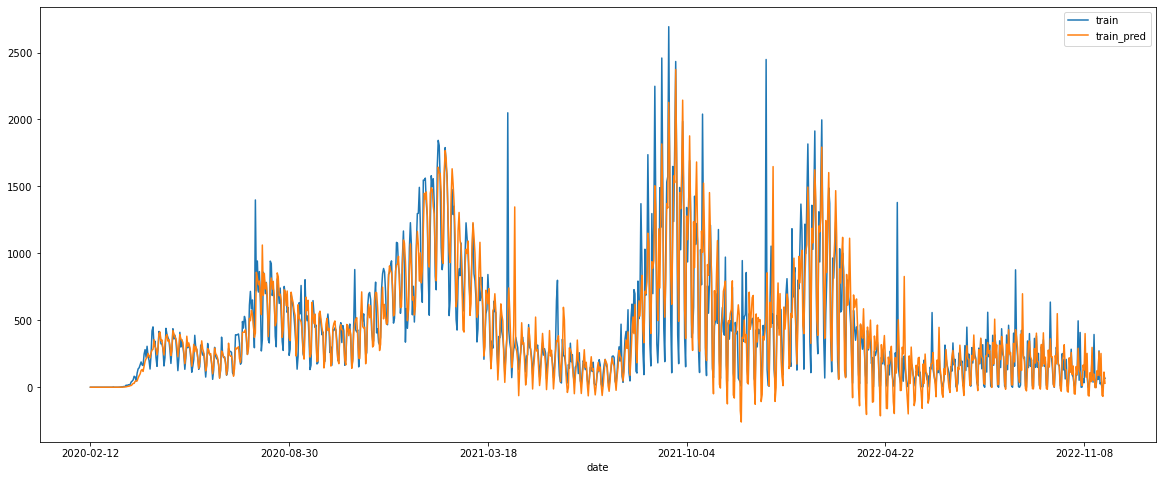

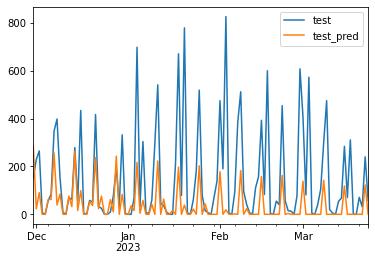

Training Set Metrics:
R-squared: 0.7871629372174396
MAE: 116.13255468730183
MASE: 0.5673622681589533

Testing Set Metrics:
R-squared: -0.05659887020601251
MAE: 117.70208088319878
MASE: 0.6089060632606081


In [1168]:
train_pred=south_auto.fittedvalues()
pd.concat([south_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=south_auto.predict(n_periods=len(south_test))
test_pred[test_pred<0] = 0
#test_pred = test_pred * 2
pd.concat([south_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(south_train, train_pred)
mae_train = mean_absolute_error(south_train, train_pred)
mase_train = MASE(south_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(south_test, test_pred)
mae_test = mean_absolute_error(south_test, test_pred)
mase_test = MASE(south_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1153]:
n_periods=7
forecast, conf_int = south_auto.predict(n_periods=n_periods, return_conf_int=True)
forecast[forecast<0] = 0

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2022-11-30    283.535758
2022-12-01     22.812750
2022-12-02     90.733328
2022-12-03      0.000000
2022-12-04      0.000000
2022-12-05     61.097686
2022-12-06     62.778889
Freq: D, dtype: float64
Confidence Interval: [[-106.6481969   673.71971192]
 [-375.67491544  421.30041524]
 [-312.66708921  494.13374614]
 [-462.22432896  351.95550365]
 [-447.85245265  375.31290996]
 [-354.08124214  476.27661371]
 [-356.80242962  482.36020767]]


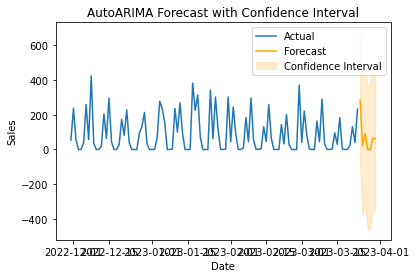

In [1154]:
forecast_index = pd.date_range(south_test.index[-1], periods=n_periods + 1, freq=south_test.index.freq)[-n_periods:]

plt.plot(south_test.index, midwest_test['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

### west

In [1166]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(west_train,order=(p,1,q), seasonal_order=(P,1,Q,7)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92366D+00    |proj g|=  7.03591D-02

At iterate    5    f=  5.90023D+00    |proj g|=  3.78229D-03


 This problem is unconstrained.



At iterate   10    f=  5.89869D+00    |proj g|=  9.32624D-03

At iterate   15    f=  5.87867D+00    |proj g|=  6.48416D-02

At iterate   20    f=  5.86152D+00    |proj g|=  9.58339D-04

At iterate   25    f=  5.86151D+00    |proj g|=  9.54561D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   9.546D-06   5.862D+00
  F =   5.8615090124359019     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.89944D+00    |proj g|=  4.98858D-03

At iterate   10    f=  5.89831D+00    |proj g|=  1.67467D-02

At iterate   15    f=  5.87327D+00    |proj g|=  4.78541D-02

At iterate   20    f=  5.86410D+00    |proj g|=  2.23293D-03

At iterate   25    f=  5.86144D+00    |proj g|=  4.87537D-03

At iterate   30    f=  5.86138D+00    |proj g|=  7.70299D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     35      1     0     0   7.703D-06   5.861D+00
  F =   5.8613833966642703     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.90031D+00    |proj g|=  7.25424D-03

At iterate   10    f=  5.89869D+00    |proj g|=  6.66174D-03

At iterate   15    f=  5.89209D+00    |proj g|=  1.50081D-02

At iterate   20    f=  5.85414D+00    |proj g|=  2.48991D-02

At iterate   25    f=  5.85246D+00    |proj g|=  3.05572D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   2.167D-05   5.852D+00
  F =   5.8524631519597401     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  5.89934D+00    |proj g|=  8.77528D-03

At iterate   10    f=  5.89817D+00    |proj g|=  3.11253D-03

At iterate   15    f=  5.88979D+00    |proj g|=  6.97655D-02

At iterate   20    f=  5.86420D+00    |proj g|=  2.07612D-02

At iterate   25    f=  5.86166D+00    |proj g|=  3.58726D-03

At iterate   30    f=  5.86114D+00    |proj g|=  1.39009D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     38      1     0     0   6.864D-05   5.861D+00
  F =   5.8611368413334866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   10    f=  5.88655D+00    |proj g|=  2.62242D-03

At iterate   15    f=  5.88239D+00    |proj g|=  3.24275D-02

At iterate   20    f=  5.86601D+00    |proj g|=  1.35748D-02

At iterate   25    f=  5.86470D+00    |proj g|=  6.66923D-04

At iterate   30    f=  5.86428D+00    |proj g|=  1.36234D-02

At iterate   35    f=  5.86154D+00    |proj g|=  3.73191D-03

At iterate   40    f=  5.86149D+00    |proj g|=  5.09752D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     46      1     0     0   3.292D-05   5.861D+00
  F =   5.8614887367128627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.88622D+00    |proj g|=  2.63827D-03

At iterate   10    f=  5.88434D+00    |proj g|=  3.37185D-02

At iterate   15    f=  5.87478D+00    |proj g|=  2.32427D-02

At iterate   20    f=  5.86516D+00    |proj g|=  2.48559D-03

At iterate   25    f=  5.86483D+00    |proj g|=  4.50511D-03

At iterate   30    f=  5.86372D+00    |proj g|=  2.22546D-02

At iterate   35    f=  5.86138D+00    |proj g|=  9.26711D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     42      1     0     0   6.974D-06   5.861D+00
  F =   5.8613779632372038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.89080D+00    |proj g|=  1.20133D-02

At iterate   10    f=  5.88627D+00    |proj g|=  3.30076D-03

At iterate   15    f=  5.88483D+00    |proj g|=  2.49670D-02

At iterate   20    f=  5.86559D+00    |proj g|=  1.58156D-02

At iterate   25    f=  5.85701D+00    |proj g|=  3.87563D-03

At iterate   30    f=  5.85689D+00    |proj g|=  3.21253D-03

At iterate   35    f=  5.85423D+00    |proj g|=  3.13835D-02

At iterate   40    f=  5.85237D+00    |proj g|=  8.91959D-04

At iterate   45    f=  5.85237D+00    |proj g|=  3.75108D-05

At iterate   50    f=  5.85237D+00    |proj g|=  6.01176D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88641D+00    |proj g|=  9.22175D-03

At iterate   10    f=  5.88530D+00    |proj g|=  4.66874D-03

At iterate   15    f=  5.87947D+00    |proj g|=  3.06328D-02

At iterate   20    f=  5.87015D+00    |proj g|=  3.71405D-02

At iterate   25    f=  5.86517D+00    |proj g|=  2.00225D-03

At iterate   30    f=  5.86486D+00    |proj g|=  9.19799D-04

At iterate   35    f=  5.86484D+00    |proj g|=  8.15409D-04

At iterate   40    f=  5.86451D+00    |proj g|=  1.77858D-02

At iterate   45    f=  5.86159D+00    |proj g|=  1.20018D-02

At iterate   50    f=  5.86115D+00    |proj g|=  1.23119D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.90054D+00    |proj g|=  4.55509D-03

At iterate   10    f=  5.89924D+00    |proj g|=  3.08483D-03

At iterate   15    f=  5.89490D+00    |proj g|=  5.55179D-02

At iterate   20    f=  5.86148D+00    |proj g|=  2.13906D-03

At iterate   25    f=  5.86147D+00    |proj g|=  5.64242D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   3.358D-06   5.861D+00
  F =   5.8614661734666891     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91020D+00    |proj g|=  6.76602D-02

At iterate    5    f=  5.89923D+00    |proj g|=  3.65664D-03

At iterate   10    f=  5.89827D+00    |proj g|=  1.92542D-02

At iterate   15    f=  5.88001D+00    |proj g|=  4.19113D-02

At iterate   20    f=  5.86289D+00    |proj g|=  1.47118D-03

At iterate   25    f=  5.86174D+00    |proj g|=  1.25231D-02

At iterate   30    f=  5.86136D+00    |proj g|=  1.41026D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  5.90083D+00    |proj g|=  2.30563D-02

At iterate   10    f=  5.89922D+00    |proj g|=  7.85647D-03

At iterate   15    f=  5.89288D+00    |proj g|=  1.20181D-02

At iterate   20    f=  5.87113D+00    |proj g|=  3.23347D-02

At iterate   25    f=  5.85239D+00    |proj g|=  4.19753D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     33      1     0     0   7.526D-06   5.852D+00
  F =   5.8523900437332514     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  5.89945D+00    |proj g|=  7.22719D-03

At iterate   10    f=  5.89801D+00    |proj g|=  7.01230D-03

At iterate   15    f=  5.89436D+00    |proj g|=  2.38745D-02

At iterate   20    f=  5.87350D+00    |proj g|=  3.08156D-02

At iterate   25    f=  5.86205D+00    |proj g|=  2.11884D-03

At iterate   30    f=  5.86126D+00    |proj g|=  3.48334D-03

At iterate   35    f=  5.86112D+00    |proj g|=  3.14790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     42      1     0     0   2.697D-05   5.861D+00
  F =   5.8611148348639341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.88585D+00    |proj g|=  1.16230D-02

At iterate   10    f=  5.88419D+00    |proj g|=  2.60159D-03

At iterate   15    f=  5.88030D+00    |proj g|=  2.38045D-02

At iterate   20    f=  5.86154D+00    |proj g|=  4.14566D-03

At iterate   25    f=  5.86135D+00    |proj g|=  1.03581D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     28      1     0     0   3.742D-05   5.861D+00
  F =   5.8613533059099270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  5.88390D+00    |proj g|=  2.74442D-03

At iterate   10    f=  5.88320D+00    |proj g|=  1.06066D-02

At iterate   15    f=  5.87432D+00    |proj g|=  1.87039D-02

At iterate   20    f=  5.86270D+00    |proj g|=  1.02999D-02

At iterate   25    f=  5.86219D+00    |proj g|=  6.67596D-03

At iterate   30    f=  5.86130D+00    |proj g|=  1.94270D-04

At iterate   35    f=  5.86130D+00    |proj g|=  4.84166D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     37      1     0     0   4.842D-05   5.861D+00
  F =   5.8612987216123376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.88846D+00    |proj g|=  1.32010D-02

At iterate   10    f=  5.88412D+00    |proj g|=  9.09945D-03

At iterate   15    f=  5.88322D+00    |proj g|=  9.90988D-03

At iterate   20    f=  5.87831D+00    |proj g|=  3.14779D-02

At iterate   25    f=  5.86478D+00    |proj g|=  2.16317D-02

At iterate   30    f=  5.85223D+00    |proj g|=  1.88480D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     38      1     0     0   2.517D-05   5.852D+00
  F =   5.8522108144685392     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.88393D+00    |proj g|=  8.27493D-03

At iterate   10    f=  5.88290D+00    |proj g|=  2.62766D-03

At iterate   15    f=  5.88059D+00    |proj g|=  1.91949D-02

At iterate   20    f=  5.86522D+00    |proj g|=  3.64414D-02

At iterate   25    f=  5.86222D+00    |proj g|=  6.49931D-03

At iterate   30    f=  5.86106D+00    |proj g|=  2.86063D-04

At iterate   35    f=  5.86105D+00    |proj g|=  2.22557D-04

At iterate   40    f=  5.86104D+00    |proj g|=  9.35400D-04

At iterate   45    f=  5.86104D+00    |proj g|=  4.32443D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     49   

In [1167]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
2   1  1  2  1  11974.434683
6   1  2  2  1  11976.238870
10  2  1  2  1  11976.285249
14  2  2  2  1  11977.918905
0   1  1  1  1  11990.924421
1   1  1  1  2  11992.667663
8   2  1  1  1  11992.836859
4   1  2  1  1  11992.882978
3   1  1  2  2  11994.163704
12  2  2  1  1  11994.606157
9   2  1  1  2  11994.624474
5   1  2  1  2  11994.656557
11  2  1  2  2  11996.118722
7   1  2  2  2  11996.181113
13  2  2  1  2  11996.494587
15  2  2  2  2  11997.959482

In [1169]:
model=sm.tsa.statespace.SARIMAX(west_train,order=(1, 1, 1),seasonal_order=(2,1,1,7))
model=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92149D+00    |proj g|=  7.09624D-02

At iterate    5    f=  5.90031D+00    |proj g|=  7.25424D-03

At iterate   10    f=  5.89869D+00    |proj g|=  6.66174D-03

At iterate   15    f=  5.89209D+00    |proj g|=  1.50081D-02

At iterate   20    f=  5.85414D+00    |proj g|=  2.48991D-02

At iterate   25    f=  5.85246D+00    |proj g|=  3.05572D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   

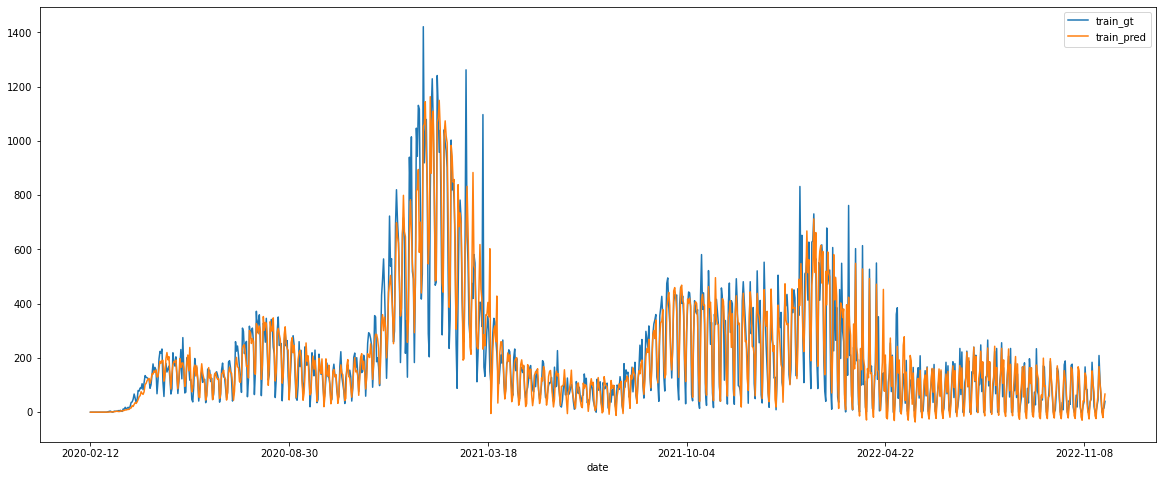

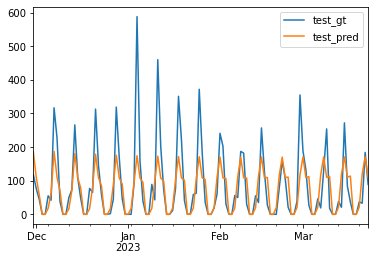

Training Set Metrics:
R-squared: 0.8356324464833998
MAE: 50.012409321298776
MASE: 0.49775476104971483

Testing Set Metrics:
R-squared: 0.5079718792746135
MAE: 46.77312220946745
MASE: 0.5228373538104483


In [1170]:
train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1171]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(west_train,order=(p,2,q), seasonal_order=(P,2,Q,7)).fit()
                    results.append([p,q,P,Q,model.aic])

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46744D+00    |proj g|=  8.00491D-02


 This problem is unconstrained.



At iterate    5    f=  6.41687D+00    |proj g|=  9.78304D-03

At iterate   10    f=  6.04482D+00    |proj g|=  9.36360D-02

At iterate   15    f=  6.00480D+00    |proj g|=  6.47020D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     29      1     0     0   4.874D-06   6.005D+00
  F =   6.0047667264819946     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.52429D+00    |proj g|=  1.75000D-01


 This problem is unconstrained.



At iterate    5    f=  6.42708D+00    |proj g|=  7.64683D-03

At iterate   10    f=  6.40187D+00    |proj g|=  9.88222D-03

At iterate   15    f=  6.39166D+00    |proj g|=  2.66749D-02

At iterate   20    f=  6.21164D+00    |proj g|=  8.27474D-02

At iterate   25    f=  6.20199D+00    |proj g|=  4.42327D-03

At iterate   30    f=  6.20185D+00    |proj g|=  2.05341D-03

At iterate   35    f=  6.20102D+00    |proj g|=  4.62275D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39    103      2     0     0   1.123D-02   6.197D+00
  F =   6.1974268227932754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47372D+00    |proj g|=  8.35923D-02


 This problem is unconstrained.



At iterate    5    f=  6.41284D+00    |proj g|=  4.48248D-03

At iterate   10    f=  6.40589D+00    |proj g|=  4.35704D-03

At iterate   15    f=  6.11224D+00    |proj g|=  2.74876D-02

At iterate   20    f=  6.02477D+00    |proj g|=  1.42173D-01

At iterate   25    f=  5.98393D+00    |proj g|=  3.75350D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     61      2     0     0   6.527D-06   5.984D+00
  F =   5.9839132790833398     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.43342D+00    |proj g|=  6.19583D-02


 This problem is unconstrained.



At iterate    5    f=  6.41588D+00    |proj g|=  2.11556D-02

At iterate   10    f=  6.24190D+00    |proj g|=  4.75703D-02

At iterate   15    f=  6.06945D+00    |proj g|=  7.33084D-02

At iterate   20    f=  6.00479D+00    |proj g|=  1.20734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     47      1     0     0   4.947D-05   6.005D+00
  F =   6.0047899924461889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.25536D+00    |proj g|=  4.51066D-02

At iterate   10    f=  6.18972D+00    |proj g|=  1.54090D-02

At iterate   15    f=  6.15773D+00    |proj g|=  1.21357D-02

At iterate   20    f=  6.13237D+00    |proj g|=  2.20725D-02

At iterate   25    f=  5.89844D+00    |proj g|=  9.51502D-02

At iterate   30    f=  5.87988D+00    |proj g|=  2.66444D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     41      1     0     0   2.664D-03   5.880D+00
  F =   5.8798844284683547     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.26424D+00    |proj g|=  3.06246D-02

At iterate   10    f=  6.17783D+00    |proj g|=  1.01859D-02

At iterate   15    f=  6.15315D+00    |proj g|=  1.30185D-02

At iterate   20    f=  5.96987D+00    |proj g|=  1.62083D-02

At iterate   25    f=  5.94663D+00    |proj g|=  2.28384D-02

At iterate   30    f=  5.94145D+00    |proj g|=  3.56188D-02

At iterate   35    f=  5.85354D+00    |proj g|=  1.25246D-02

At iterate   40    f=  5.85117D+00    |proj g|=  2.54954D-03

At iterate   45    f=  5.85117D+00    |proj g|=  5.01718D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     86   

 This problem is unconstrained.



At iterate    5    f=  6.24664D+00    |proj g|=  4.35504D-02

At iterate   10    f=  6.18882D+00    |proj g|=  4.04050D-02

At iterate   15    f=  6.17213D+00    |proj g|=  7.32098D-03

At iterate   20    f=  6.08254D+00    |proj g|=  7.40469D-02

At iterate   25    f=  5.86313D+00    |proj g|=  4.65719D-03

At iterate   30    f=  5.86257D+00    |proj g|=  5.86213D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     58      1     0     0   1.676D-03   5.863D+00
  F =   5.8625374182002643     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.24336D+00    |proj g|=  4.24009D-02

At iterate   10    f=  6.18498D+00    |proj g|=  8.16796D-03

At iterate   15    f=  6.16625D+00    |proj g|=  1.79152D-02

At iterate   20    f=  6.06809D+00    |proj g|=  1.04256D-01

At iterate   25    f=  5.88091D+00    |proj g|=  3.18110D-02

At iterate   30    f=  5.87955D+00    |proj g|=  1.69005D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     56      1     0     0   1.054D-04   5.880D+00
  F =   5.8795471078126189     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.41191D+00    |proj g|=  6.85525D-03

At iterate   10    f=  6.39948D+00    |proj g|=  8.40971D-03

At iterate   15    f=  6.13319D+00    |proj g|=  1.61327D-01

At iterate   20    f=  5.96717D+00    |proj g|=  1.63268D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     35      1     0     0   4.562D-05   5.967D+00
  F =   5.9669234816551251     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.41871D+00    |proj g|=  2.27729D-02

At iterate   10    f=  6.39910D+00    |proj g|=  3.59807D-02

At iterate   15    f=  6.38688D+00    |proj g|=  1.33041D-02

At iterate   20    f=  6.20369D+00    |proj g|=  7.03717D-02

At iterate   25    f=  6.20103D+00    |proj g|=  1.06355D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26    123      2     0     0   1.064D-01   6.201D+00
  F =   6.2010298307055329     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


2 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.47557D+00    |proj g|=  7.31317D-02


 This problem is unconstrained.



At iterate    5    f=  6.40854D+00    |proj g|=  8.82047D-03

At iterate   10    f=  6.39834D+00    |proj g|=  3.82435D-03

At iterate   15    f=  6.17501D+00    |proj g|=  1.98967D-01

At iterate   20    f=  5.98688D+00    |proj g|=  1.51875D-01

At iterate   25    f=  5.94637D+00    |proj g|=  2.58232D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     39      1     0     0   3.046D-06   5.946D+00
  F =   5.9463602213615792     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  6.40841D+00    |proj g|=  4.57962D-02

At iterate   10    f=  6.40121D+00    |proj g|=  1.16599D-02

At iterate   15    f=  5.97010D+00    |proj g|=  4.58744D-02

At iterate   20    f=  5.96694D+00    |proj g|=  2.37032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     22     32      1     0     0   2.011D-05   5.967D+00
  F =   5.9669417323423879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.23073D+00    |proj g|=  4.73344D-02

At iterate   10    f=  6.20353D+00    |proj g|=  8.61248D-03

At iterate   15    f=  6.19045D+00    |proj g|=  1.96303D-02

At iterate   20    f=  6.08506D+00    |proj g|=  1.95986D-01

At iterate   25    f=  6.00574D+00    |proj g|=  2.45063D-02

At iterate   30    f=  6.00489D+00    |proj g|=  7.01041D-04

At iterate   35    f=  6.00477D+00    |proj g|=  4.34191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     46      1     0     0   1.064D-05   6.005D+00
  F =   6.0047546102727036     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.81353D+00    |proj g|=  2.40283D+00

At iterate    5    f=  6.25138D+00    |proj g|=  3.81779D-02

At iterate   10    f=  6.21042D+00    |proj g|=  1.44296D-02

At iterate   15    f=  6.19185D+00    |proj g|=  3.79187D-03

At iterate   20    f=  6.05077D+00    |proj g|=  1.13365D-01

At iterate   25    f=  5.96559D+00    |proj g|=  1.04131D-02

At iterate   30    f=  5.96269D+00    |proj g|=  1.77750D-02

At iterate   35    f=  5.95724D+00    |proj g|=  1.04697D-01

At iterate   40    f=  5.87700D+00    |proj g|=  5.12177D-02

At iterate   45    f=  5.85714D+00    |proj g|=  6.82398D-02

At iterate   50    f=  5.85225D+00    |proj g|=  7.40577D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  6.22386D+00    |proj g|=  4.31848D-02

At iterate   10    f=  6.19592D+00    |proj g|=  1.21674D-02

At iterate   15    f=  6.19269D+00    |proj g|=  5.16817D-03

At iterate   20    f=  6.06029D+00    |proj g|=  6.94954D-02

At iterate   25    f=  5.98544D+00    |proj g|=  2.95784D-02

At iterate   30    f=  5.98458D+00    |proj g|=  1.62279D-04

At iterate   35    f=  5.98455D+00    |proj g|=  3.53516D-03

At iterate   40    f=  5.98376D+00    |proj g|=  1.19461D-02

At iterate   45    f=  5.98328D+00    |proj g|=  6.38236D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     55   

 This problem is unconstrained.



At iterate    5    f=  6.21680D+00    |proj g|=  2.69486D-02

At iterate   10    f=  6.20167D+00    |proj g|=  5.14534D-03

At iterate   15    f=  6.19745D+00    |proj g|=  1.42408D-02

At iterate   20    f=  6.05202D+00    |proj g|=  8.61286D-02

At iterate   25    f=  6.00484D+00    |proj g|=  2.20354D-03

At iterate   30    f=  6.00462D+00    |proj g|=  1.61477D-03

At iterate   35    f=  6.00399D+00    |proj g|=  1.84051D-02

At iterate   40    f=  6.00354D+00    |proj g|=  1.88411D-04

At iterate   45    f=  6.00354D+00    |proj g|=  3.92161D-04

At iterate   50    f=  6.00351D+00    |proj g|=  1.42288D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [1172]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
5   1  2  1  2  11973.784569
13  2  2  1  2  11977.990771
6   1  2  2  1  11997.026483
4   1  2  1  1  12030.483772
7   1  2  2  2  12033.794288
10  2  1  2  1  12168.360292
8   2  1  1  1  12208.391597
11  2  1  2  2  12212.428901
2   1  1  2  1  12243.118742
14  2  2  2  1  12245.821540
0   1  1  1  1  12283.743189
12  2  2  1  1  12287.718423
3   1  1  2  2  12287.790745
15  2  2  2  2  12289.181091
1   1  1  1  2  12679.540426
9   2  1  1  2  12688.904974

In [1173]:
model=sm.tsa.statespace.SARIMAX(west_train,order=(1, 2, 2),seasonal_order=(1,2,2,7))
model=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34527D+00    |proj g|=  1.75605D+00

At iterate    5    f=  6.26424D+00    |proj g|=  3.06246D-02

At iterate   10    f=  6.17783D+00    |proj g|=  1.01859D-02

At iterate   15    f=  6.15315D+00    |proj g|=  1.30185D-02

At iterate   20    f=  5.96987D+00    |proj g|=  1.62083D-02

At iterate   25    f=  5.94663D+00    |proj g|=  2.28384D-02

At iterate   30    f=  5.94145D+00    |proj g|=  3.56188D-02

At iterate   35    f=  5.85354D+00    |proj g|=  1.25246D-02

At iterate   40    f=  5.85117D+00    |proj g|=  2.54954D-03

At iterate   45    f=  5.85117D+00    |proj g|=  5.01718D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

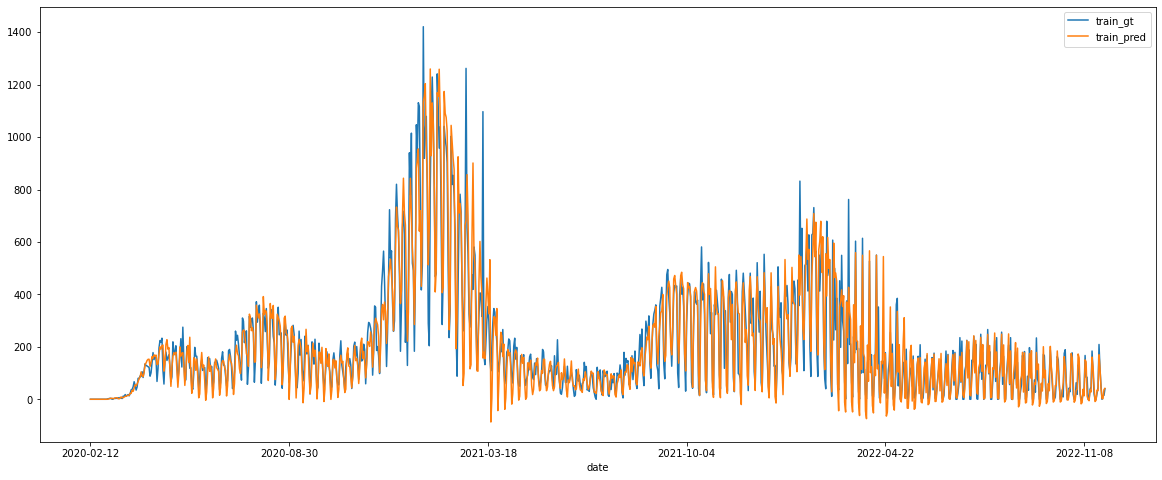

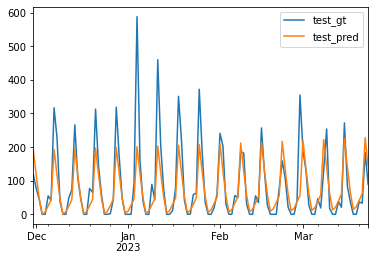

Training Set Metrics:
MAE: 51.93358861928495
MASE: 0.5168755383803826

Testing Set Metrics:
MAE: 37.89525569216895
MASE: 0.4235991584939253


In [1177]:
train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1206]:
west_auto = auto_arima(west_train, start_p=1, start_q=1,
                           max_p=4, max_q=4, m=7,
                           start_P=0, start_Q = 0, max_Q = 2, seasonal=True,
                           d=2, D=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(west_auto.aic())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,2,0)[7]             : AIC=inf, Time=0.50 sec
 ARIMA(0,2,0)(0,2,0)[7]             : AIC=14828.647, Time=0.11 sec
 ARIMA(1,2,0)(1,2,0)[7]             : AIC=13686.415, Time=0.47 sec
 ARIMA(0,2,1)(0,2,1)[7]             : AIC=inf, Time=0.65 sec
 ARIMA(1,2,0)(0,2,0)[7]             : AIC=14298.991, Time=0.11 sec
 ARIMA(1,2,0)(2,2,0)[7]             : AIC=13488.763, Time=1.59 sec
 ARIMA(1,2,0)(2,2,1)[7]             : AIC=inf, Time=2.50 sec
 ARIMA(1,2,0)(1,2,1)[7]             : AIC=inf, Time=1.81 sec
 ARIMA(0,2,0)(2,2,0)[7]             : AIC=14035.486, Time=0.37 sec
 ARIMA(2,2,0)(2,2,0)[7]             : AIC=13258.110, Time=1.58 sec
 ARIMA(2,2,0)(1,2,0)[7]             : AIC=13456.957, Time=0.71 sec
 ARIMA(2,2,0)(2,2,1)[7]             : AIC=inf, Time=3.13 sec
 ARIMA(2,2,0)(1,2,1)[7]             : AIC=inf, Time=2.34 sec
 ARIMA(3,2,0)(2,2,0)[7]             : AIC=13120.364, Time=2.35 sec
 ARIMA(3,2,0)(1,2,0)[7]             : AIC=13302.098, Ti

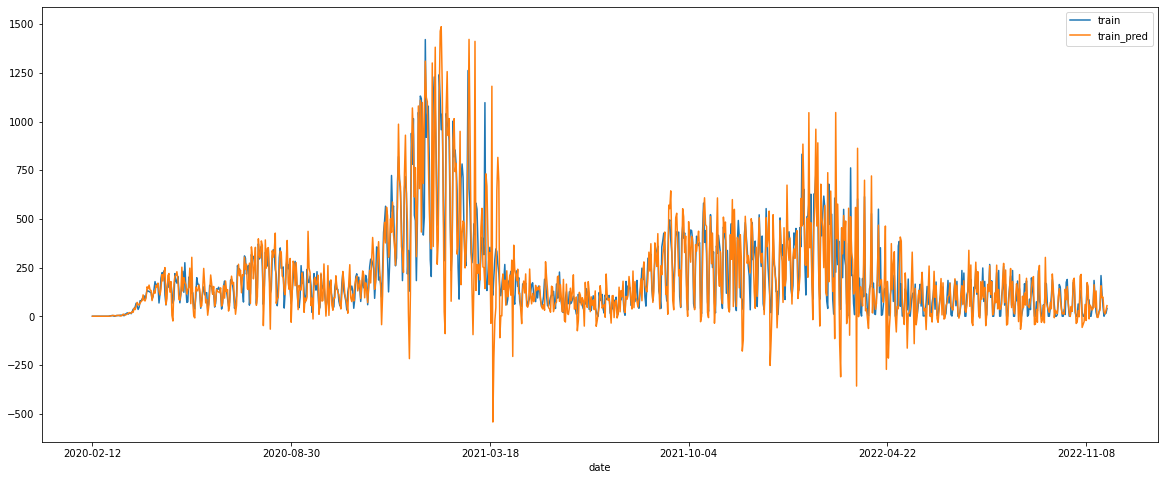

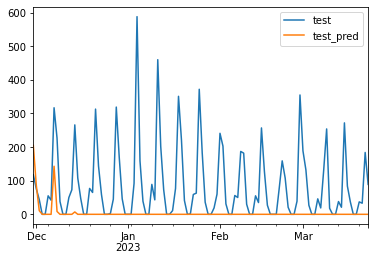

Training Set Metrics:
R-squared: 0.5169170381304167
MAE: 89.34537165752238
MASE: 0.8892209898263929

Testing Set Metrics:
R-squared: -0.531807238684832
MAE: 83.55835015369135
MASE: 0.9340284466680306


In [1207]:
train_pred=west_auto.fittedvalues()
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20,8))
plt.legend(['train', 'train_pred'])
plt.show()

test_pred=west_auto.predict(n_periods=len(west_test))
test_pred[test_pred<0] = 0
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
r2_train = r2_score(west_train, train_pred)
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("R-squared:", r2_train)
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
r2_test = r2_score(west_test, test_pred)
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("R-squared:", r2_test)
print("MAE:", mae_test)
print("MASE:", mase_test)

In [1208]:
n_periods=7
forecast, conf_int = west_auto.predict(n_periods=n_periods, return_conf_int=True)
forecast[forecast<0] = 0

# Print the forecast and confidence interval
print("Forecast:", forecast)
print("Confidence Interval:", conf_int)

Forecast: 2022-11-30    205.174212
2022-12-01     86.857791
2022-12-02     10.868626
2022-12-03      0.000000
2022-12-04      0.000000
2022-12-05      0.000000
2022-12-06      0.000000
Freq: D, dtype: float64
Confidence Interval: [[  -91.2043904    501.55281408]
 [ -285.16066151   458.87624301]
 [ -459.10566058   480.84291197]
 [ -638.93424561   540.19175683]
 [ -782.19861086   694.27943052]
 [ -963.464732     859.52335665]
 [-1092.32441962  1033.34634302]]


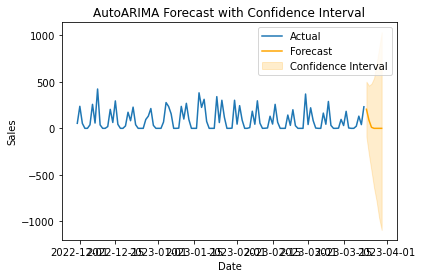

In [1209]:
forecast_index = pd.date_range(west_test.index[-1], periods=n_periods + 1, freq=west_test.index.freq)[-n_periods:]

plt.plot(west_test.index, midwest_test['daily_deaths'], label='Actual')

plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.fill_between(forecast_index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# Customize the plot
plt.title('AutoARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [1214]:
if 1:
    import statsmodels.api as sm

    results=[]
    for p in range(0,5):
        for q in range(0,5):
            for P in range(1,3):
                for Q in range(1,3):
                    print(p,q,P,Q)
                    model=sm.tsa.statespace.SARIMAX(west_train,order=(p,1,q), seasonal_order=(P,1,Q,7)).fit()
                    results.append([p,q,P,Q,model.aic])

0 0 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11340D+00    |proj g|=  4.39198D-02

At iterate    5    f=  6.09278D+00    |proj g|=  7.32449D-04


 This problem is unconstrained.



At iterate   10    f=  6.09128D+00    |proj g|=  1.58509D-02

At iterate   15    f=  6.09081D+00    |proj g|=  6.66098D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     17      1     0     0   6.661D-06   6.091D+00
  F =   6.0908067718843535     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0 0 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.09529D+00    |proj g|=  4.11628D-02

At iterate    5    f=  6.09335D+00    |proj g|=  1.43936D-03


 This problem is unconstrained.



At iterate   10    f=  6.09283D+00    |proj g|=  1.40300D-02

At iterate   15    f=  6.09182D+00    |proj g|=  2.28734D-03

At iterate   20    f=  6.09111D+00    |proj g|=  6.57026D-04

At iterate   25    f=  6.09102D+00    |proj g|=  1.07159D-03

At iterate   30    f=  6.09088D+00    |proj g|=  4.25537D-04

At iterate   35    f=  6.09072D+00    |proj g|=  7.69523D-04

At iterate   40    f=  6.09065D+00    |proj g|=  3.14587D-04

At iterate   45    f=  6.09063D+00    |proj g|=  3.70316D-04

At iterate   50    f=  6.09063D+00    |proj g|=  4.81119D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     69   

 This problem is unconstrained.



At iterate    5    f=  6.09268D+00    |proj g|=  4.99882D-02

At iterate   10    f=  6.08367D+00    |proj g|=  4.92507D-03

At iterate   15    f=  6.08303D+00    |proj g|=  7.20363D-04

At iterate   20    f=  6.08254D+00    |proj g|=  2.37465D-02

At iterate   25    f=  6.08119D+00    |proj g|=  2.91277D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   2.812D-06   6.081D+00
  F =   6.0811802591298711     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0 0 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =     

 This problem is unconstrained.



At iterate    5    f=  6.08846D+00    |proj g|=  1.83980D-03

At iterate   10    f=  6.08739D+00    |proj g|=  1.30606D-02

At iterate   15    f=  6.08207D+00    |proj g|=  4.83717D-02

At iterate   20    f=  6.07661D+00    |proj g|=  1.48559D-02

At iterate   25    f=  6.07455D+00    |proj g|=  2.12266D-03

At iterate   30    f=  6.07447D+00    |proj g|=  8.29335D-05

At iterate   35    f=  6.07445D+00    |proj g|=  3.28925D-03

At iterate   40    f=  6.07441D+00    |proj g|=  4.31505D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     56      1     0     0   5.907D-07   6.074D+00
  F =   6.07440826600

 This problem is unconstrained.



At iterate   10    f=  5.87613D+00    |proj g|=  4.47195D-02

At iterate   15    f=  5.86539D+00    |proj g|=  1.49141D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     18      1     0     0   1.850D-07   5.865D+00
  F =   5.8653879201194385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92144D+00    |proj g|=  6.31373D-02


 This problem is unconstrained.



At iterate    5    f=  5.90250D+00    |proj g|=  3.08390D-03

At iterate   10    f=  5.89964D+00    |proj g|=  2.17134D-02

At iterate   15    f=  5.87094D+00    |proj g|=  2.61757D-02

At iterate   20    f=  5.86648D+00    |proj g|=  1.71830D-02

At iterate   25    f=  5.86556D+00    |proj g|=  1.62885D-04

At iterate   30    f=  5.86551D+00    |proj g|=  1.05395D-02

At iterate   35    f=  5.86388D+00    |proj g|=  1.18024D-02

At iterate   40    f=  5.86350D+00    |proj g|=  4.23251D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     55      1     0     0   4.191D-05   5.863D+00
  F =   5.86349129980

 This problem is unconstrained.



At iterate    5    f=  5.90424D+00    |proj g|=  9.13063D-03

At iterate   10    f=  5.90207D+00    |proj g|=  3.04575D-03

At iterate   15    f=  5.89138D+00    |proj g|=  6.18933D-02

At iterate   20    f=  5.85888D+00    |proj g|=  3.63065D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     29      1     0     0   2.483D-06   5.859D+00
  F =   5.8588337577003573     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.90224D+00    |proj g|=  5.15457D-03

At iterate   10    f=  5.89681D+00    |proj g|=  2.64053D-02

At iterate   15    f=  5.86722D+00    |proj g|=  1.46783D-02

At iterate   20    f=  5.86571D+00    |proj g|=  1.34375D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     29      1     0     0   1.608D-05   5.865D+00
  F =   5.8650307275613587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate   10    f=  5.89033D+00    |proj g|=  9.59996D-03

At iterate   15    f=  5.86234D+00    |proj g|=  2.50222D-02

At iterate   20    f=  5.86166D+00    |proj g|=  9.06546D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     25      1     0     0   9.065D-06   5.862D+00
  F =   5.8616644688966106     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0 2 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90429D+00    |proj g|=  6.12485D-02


 This problem is unconstrained.



At iterate    5    f=  5.89237D+00    |proj g|=  2.96651D-03

At iterate   10    f=  5.89149D+00    |proj g|=  2.46295D-02

At iterate   15    f=  5.87828D+00    |proj g|=  2.32820D-02

At iterate   20    f=  5.86243D+00    |proj g|=  4.16484D-03

At iterate   25    f=  5.86152D+00    |proj g|=  1.06888D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     31      1     0     0   3.847D-05   5.862D+00
  F =   5.8615152908046655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0 2 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate    5    f=  5.89387D+00    |proj g|=  5.79672D-03

At iterate   10    f=  5.89204D+00    |proj g|=  1.58045D-02

At iterate   15    f=  5.88901D+00    |proj g|=  2.47287D-02

At iterate   20    f=  5.86493D+00    |proj g|=  3.22380D-02

At iterate   25    f=  5.85281D+00    |proj g|=  3.72895D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     31      1     0     0   2.138D-05   5.853D+00
  F =   5.8527887299827333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  5.89173D+00    |proj g|=  6.13345D-03

At iterate   10    f=  5.89079D+00    |proj g|=  1.10117D-02

At iterate   15    f=  5.86905D+00    |proj g|=  6.19007D-02

At iterate   20    f=  5.86208D+00    |proj g|=  1.98984D-03

At iterate   25    f=  5.86128D+00    |proj g|=  1.39441D-03

At iterate   30    f=  5.86127D+00    |proj g|=  1.38416D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     32      1     0     0   1.384D-05   5.861D+00
  F =   5.8612735088573320     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0 3 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.92079D+00    |proj g|=  3.53665D-03

At iterate   10    f=  5.91335D+00    |proj g|=  2.05111D-02

At iterate   15    f=  5.87213D+00    |proj g|=  7.35231D-02

At iterate   20    f=  5.86128D+00    |proj g|=  1.49333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     32      1     0     0   3.685D-05   5.861D+00
  F =   5.8612772907548107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0 3 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.92034D+00    |proj g|=  3.54339D-03

At iterate   10    f=  5.91478D+00    |proj g|=  2.08530D-02

At iterate   15    f=  5.87088D+00    |proj g|=  5.24244D-02

At iterate   20    f=  5.86307D+00    |proj g|=  2.34758D-03

At iterate   25    f=  5.86121D+00    |proj g|=  4.48364D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     33      1     0     0   6.223D-06   5.861D+00
  F =   5.8612141995386562     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0 3 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  5.92208D+00    |proj g|=  7.71776D-03

At iterate   10    f=  5.92025D+00    |proj g|=  1.22843D-02

At iterate   15    f=  5.91463D+00    |proj g|=  2.26112D-02

At iterate   20    f=  5.88869D+00    |proj g|=  1.76514D-02

At iterate   25    f=  5.86392D+00    |proj g|=  3.63793D-02

At iterate   30    f=  5.85211D+00    |proj g|=  1.25889D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     41      1     0     0   1.669D-05   5.852D+00
  F =   5.8521126329609743     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0 3 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.91984D+00    |proj g|=  3.55523D-03

At iterate   10    f=  5.91703D+00    |proj g|=  1.02792D-02

At iterate   15    f=  5.87138D+00    |proj g|=  5.42056D-02

At iterate   20    f=  5.86253D+00    |proj g|=  3.51366D-03

At iterate   25    f=  5.86144D+00    |proj g|=  1.45511D-02

At iterate   30    f=  5.86096D+00    |proj g|=  3.93261D-04

At iterate   35    f=  5.86096D+00    |proj g|=  1.11652D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     41      1     0     0   1.117D-05   5.861D+00
  F =   5.8609553580946354     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.91112D+00    |proj g|=  8.52671D-03

At iterate   10    f=  5.90951D+00    |proj g|=  8.46312D-03

At iterate   15    f=  5.87745D+00    |proj g|=  1.00396D-01

At iterate   20    f=  5.86067D+00    |proj g|=  2.21694D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     25      1     0     0   1.072D-05   5.861D+00
  F =   5.8606701971733282     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
0 4 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.91071D+00    |proj g|=  1.57253D-02

At iterate   10    f=  5.90936D+00    |proj g|=  6.22203D-03

At iterate   15    f=  5.88341D+00    |proj g|=  5.46076D-02

At iterate   20    f=  5.86235D+00    |proj g|=  1.04285D-02

At iterate   25    f=  5.86187D+00    |proj g|=  5.85707D-03

At iterate   30    f=  5.86073D+00    |proj g|=  3.15617D-03

At iterate   35    f=  5.86070D+00    |proj g|=  4.43126D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     42      1     0     0   6.222D-06   5.861D+00
  F =   5.8607013311696194     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.91445D+00    |proj g|=  2.15008D-02

At iterate   10    f=  5.90955D+00    |proj g|=  3.35721D-03

At iterate   15    f=  5.90697D+00    |proj g|=  2.21970D-02

At iterate   20    f=  5.87958D+00    |proj g|=  6.00902D-02

At iterate   25    f=  5.85166D+00    |proj g|=  1.02793D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     35      1     0     0   9.897D-06   5.852D+00
  F =   5.8515759708738013     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
0 4 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =     

 This problem is unconstrained.



At iterate    5    f=  5.91031D+00    |proj g|=  1.15006D-02

At iterate   10    f=  5.90874D+00    |proj g|=  3.37331D-03

At iterate   15    f=  5.90138D+00    |proj g|=  4.82981D-02

At iterate   20    f=  5.86137D+00    |proj g|=  1.37166D-02

At iterate   25    f=  5.86072D+00    |proj g|=  1.62316D-03

At iterate   30    f=  5.86041D+00    |proj g|=  1.14871D-03

At iterate   35    f=  5.86041D+00    |proj g|=  1.54757D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     44      1     0     0   1.132D-05   5.860D+00
  F =   5.8604094066831873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  5.99844D+00    |proj g|=  6.31853D-02

At iterate   15    f=  5.98279D+00    |proj g|=  9.45720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   1.237D-06   5.983D+00
  F =   5.9827052621098646     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 0 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.00485D+00    |proj g|=  1.34869D-02


 This problem is unconstrained.



At iterate    5    f=  6.00438D+00    |proj g|=  7.39742D-03

At iterate   10    f=  5.99836D+00    |proj g|=  4.12923D-02

At iterate   15    f=  5.98327D+00    |proj g|=  1.03456D-02

At iterate   20    f=  5.98296D+00    |proj g|=  3.77469D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   3.771D-06   5.983D+00
  F =   5.9829413741952004     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 0 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  6.00486D+00    |proj g|=  6.25640D-03

At iterate   10    f=  6.00443D+00    |proj g|=  3.10448D-03

At iterate   15    f=  5.99350D+00    |proj g|=  1.81034D-02

At iterate   20    f=  5.98029D+00    |proj g|=  5.61181D-03

At iterate   25    f=  5.98025D+00    |proj g|=  3.24811D-03

At iterate   30    f=  5.98013D+00    |proj g|=  6.37981D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     41      1     0     0   7.966D-06   5.980D+00
  F =   5.9801327982012857     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 0 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  6.00390D+00    |proj g|=  2.30090D-03

At iterate   10    f=  6.00173D+00    |proj g|=  3.07321D-02

At iterate   15    f=  5.99060D+00    |proj g|=  3.95474D-02

At iterate   20    f=  5.98274D+00    |proj g|=  2.43424D-04

At iterate   25    f=  5.98271D+00    |proj g|=  1.25212D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     32      1     0     0   2.085D-06   5.983D+00
  F =   5.9827048603949669     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =     

 This problem is unconstrained.



At iterate    5    f=  5.90023D+00    |proj g|=  3.78229D-03

At iterate   10    f=  5.89869D+00    |proj g|=  9.32624D-03

At iterate   15    f=  5.87867D+00    |proj g|=  6.48416D-02

At iterate   20    f=  5.86152D+00    |proj g|=  9.58339D-04

At iterate   25    f=  5.86151D+00    |proj g|=  9.54561D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   9.546D-06   5.862D+00
  F =   5.8615090124359019     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate    5    f=  5.89944D+00    |proj g|=  4.98858D-03

At iterate   10    f=  5.89831D+00    |proj g|=  1.67467D-02

At iterate   15    f=  5.87327D+00    |proj g|=  4.78541D-02

At iterate   20    f=  5.86410D+00    |proj g|=  2.23293D-03

At iterate   25    f=  5.86144D+00    |proj g|=  4.87537D-03

At iterate   30    f=  5.86138D+00    |proj g|=  7.70299D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     35      1     0     0   7.703D-06   5.861D+00
  F =   5.8613833966642703     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.90031D+00    |proj g|=  7.25424D-03

At iterate   10    f=  5.89869D+00    |proj g|=  6.66174D-03

At iterate   15    f=  5.89209D+00    |proj g|=  1.50081D-02

At iterate   20    f=  5.85414D+00    |proj g|=  2.48991D-02

At iterate   25    f=  5.85246D+00    |proj g|=  3.05572D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   2.167D-05   5.852D+00
  F =   5.8524631519597401     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  5.89934D+00    |proj g|=  8.77528D-03

At iterate   10    f=  5.89817D+00    |proj g|=  3.11253D-03

At iterate   15    f=  5.88979D+00    |proj g|=  6.97655D-02

At iterate   20    f=  5.86420D+00    |proj g|=  2.07612D-02

At iterate   25    f=  5.86166D+00    |proj g|=  3.58726D-03

At iterate   30    f=  5.86114D+00    |proj g|=  1.39009D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     38      1     0     0   6.864D-05   5.861D+00
  F =   5.8611368413334866     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   10    f=  5.88655D+00    |proj g|=  2.62242D-03

At iterate   15    f=  5.88239D+00    |proj g|=  3.24275D-02

At iterate   20    f=  5.86601D+00    |proj g|=  1.35748D-02

At iterate   25    f=  5.86470D+00    |proj g|=  6.66923D-04

At iterate   30    f=  5.86428D+00    |proj g|=  1.36234D-02

At iterate   35    f=  5.86154D+00    |proj g|=  3.73191D-03

At iterate   40    f=  5.86149D+00    |proj g|=  5.09752D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     46      1     0     0   3.292D-05   5.861D+00
  F =   5.8614887367128627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.88622D+00    |proj g|=  2.63827D-03

At iterate   10    f=  5.88434D+00    |proj g|=  3.37185D-02

At iterate   15    f=  5.87478D+00    |proj g|=  2.32427D-02

At iterate   20    f=  5.86516D+00    |proj g|=  2.48559D-03

At iterate   25    f=  5.86483D+00    |proj g|=  4.50511D-03

At iterate   30    f=  5.86372D+00    |proj g|=  2.22546D-02

At iterate   35    f=  5.86138D+00    |proj g|=  9.26711D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     42      1     0     0   6.974D-06   5.861D+00
  F =   5.8613779632372038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.89080D+00    |proj g|=  1.20133D-02

At iterate   10    f=  5.88627D+00    |proj g|=  3.30076D-03

At iterate   15    f=  5.88483D+00    |proj g|=  2.49670D-02

At iterate   20    f=  5.86559D+00    |proj g|=  1.58156D-02

At iterate   25    f=  5.85701D+00    |proj g|=  3.87563D-03

At iterate   30    f=  5.85689D+00    |proj g|=  3.21253D-03

At iterate   35    f=  5.85423D+00    |proj g|=  3.13835D-02

At iterate   40    f=  5.85237D+00    |proj g|=  8.91959D-04

At iterate   45    f=  5.85237D+00    |proj g|=  3.75108D-05

At iterate   50    f=  5.85237D+00    |proj g|=  6.01176D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88641D+00    |proj g|=  9.22175D-03

At iterate   10    f=  5.88530D+00    |proj g|=  4.66874D-03

At iterate   15    f=  5.87947D+00    |proj g|=  3.06328D-02

At iterate   20    f=  5.87015D+00    |proj g|=  3.71405D-02

At iterate   25    f=  5.86517D+00    |proj g|=  2.00225D-03

At iterate   30    f=  5.86486D+00    |proj g|=  9.19799D-04

At iterate   35    f=  5.86484D+00    |proj g|=  8.15409D-04

At iterate   40    f=  5.86451D+00    |proj g|=  1.77858D-02

At iterate   45    f=  5.86159D+00    |proj g|=  1.20018D-02

At iterate   50    f=  5.86115D+00    |proj g|=  1.23119D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.90572D+00    |proj g|=  9.03956D-03

At iterate   10    f=  5.90435D+00    |proj g|=  1.19151D-02

At iterate   15    f=  5.88256D+00    |proj g|=  1.42413D-02

At iterate   20    f=  5.86372D+00    |proj g|=  2.85577D-02

At iterate   25    f=  5.86159D+00    |proj g|=  2.49488D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     33      1     0     0   5.071D-05   5.862D+00
  F =   5.8615904190065375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 3 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92916D+00    |proj g|=  4.62340D-02

At iterate    5    f=  5.90520D+00    |proj g|=  3.25172D-03

At iterate   10    f=  5.90100D+00    |proj g|=  3.18121D-02

At iterate   15    f=  5.87288D+00    |proj g|=  2.89238D-02

At iterate   20    f=  5.86230D+00    |proj g|=  1.48380D-03

At iterate   25    f=  5.86149D+00    |proj g|=  1.02095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     33      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  5.90748D+00    |proj g|=  1.37651D-02

At iterate   10    f=  5.90463D+00    |proj g|=  6.58885D-03

At iterate   15    f=  5.89283D+00    |proj g|=  3.56573D-02

At iterate   20    f=  5.85420D+00    |proj g|=  4.33308D-02

At iterate   25    f=  5.85253D+00    |proj g|=  2.33996D-04

At iterate   30    f=  5.85243D+00    |proj g|=  3.34934D-03

At iterate   35    f=  5.85233D+00    |proj g|=  7.01084D-04

At iterate   40    f=  5.85220D+00    |proj g|=  4.65415D-03

At iterate   45    f=  5.85198D+00    |proj g|=  2.51229D-03

At iterate   50    f=  5.85197D+00    |proj g|=  4.09709D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.90460D+00    |proj g|=  3.26580D-03

At iterate   10    f=  5.90064D+00    |proj g|=  3.06366D-02

At iterate   15    f=  5.86729D+00    |proj g|=  2.61133D-02

At iterate   20    f=  5.86187D+00    |proj g|=  3.13830D-03

At iterate   25    f=  5.86129D+00    |proj g|=  2.36441D-03

At iterate   30    f=  5.86127D+00    |proj g|=  1.25788D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     30     33      1     0     0   1.258D-05   5.861D+00
  F =   5.8612675163021590     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 4 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.89877D+00    |proj g|=  5.17746D-03

At iterate   10    f=  5.89780D+00    |proj g|=  1.05311D-02

At iterate   15    f=  5.86678D+00    |proj g|=  4.51129D-02

At iterate   20    f=  5.86127D+00    |proj g|=  6.48089D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     26      1     0     0   6.365D-05   5.861D+00
  F =   5.8612729408164581     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
1 4 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.90062D+00    |proj g|=  4.12365D-02

At iterate    5    f=  5.89827D+00    |proj g|=  8.92932D-03

At iterate   10    f=  5.89291D+00    |proj g|=  5.54325D-02

At iterate   15    f=  5.86476D+00    |proj g|=  5.74441D-02

At iterate   20    f=  5.86174D+00    |proj g|=  3.79469D-03

At iterate   25    f=  5.86121D+00    |proj g|=  7.69668D-04

At iterate   30    f=  5.86120D+00    |proj g|=  1.00677D-03

At iterate   35    f=  5.86110D+00    |proj g|=  1.07898D-02

At iterate   40    f=  5.85987D+00    |proj g|=  6.04181D-03

At iterate   45    f=  5.85936D+00    |proj g|=  6.82902D-03

At iterate   50    f=  5.85873D+00    |proj g|=  1.67388D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.90049D+00    |proj g|=  1.94147D-02

At iterate   10    f=  5.89779D+00    |proj g|=  6.31487D-03

At iterate   15    f=  5.88883D+00    |proj g|=  2.19005D-02

At iterate   20    f=  5.85865D+00    |proj g|=  4.07894D-02

At iterate   25    f=  5.85208D+00    |proj g|=  4.28752D-04

At iterate   30    f=  5.85208D+00    |proj g|=  3.79675D-04

At iterate   35    f=  5.85205D+00    |proj g|=  4.35023D-03

At iterate   40    f=  5.85172D+00    |proj g|=  4.60332D-03

At iterate   45    f=  5.85127D+00    |proj g|=  4.67628D-03

At iterate   50    f=  5.85106D+00    |proj g|=  1.98513D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.89765D+00    |proj g|=  3.10750D-03

At iterate   10    f=  5.89648D+00    |proj g|=  9.40697D-03

At iterate   15    f=  5.87777D+00    |proj g|=  1.45732D-02

At iterate   20    f=  5.86282D+00    |proj g|=  2.29861D-03

At iterate   25    f=  5.86223D+00    |proj g|=  8.62249D-03

At iterate   30    f=  5.86071D+00    |proj g|=  4.52657D-03

At iterate   35    f=  5.86067D+00    |proj g|=  7.55621D-04

At iterate   40    f=  5.86018D+00    |proj g|=  1.13462D-02

At iterate   45    f=  5.85936D+00    |proj g|=  5.67628D-03

At iterate   50    f=  5.85881D+00    |proj g|=  5.23245D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.96678D+00    |proj g|=  2.28665D-03

At iterate   10    f=  5.96485D+00    |proj g|=  2.51288D-02

At iterate   15    f=  5.94654D+00    |proj g|=  3.25015D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   1.852D-06   5.947D+00
  F =   5.9465029628898778     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 0 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.96694D+00    |proj g|=  1.85204D-02


 This problem is unconstrained.



At iterate    5    f=  5.96636D+00    |proj g|=  7.14028D-03

At iterate   10    f=  5.95789D+00    |proj g|=  1.45640D-02

At iterate   15    f=  5.94778D+00    |proj g|=  2.02170D-03

At iterate   20    f=  5.94681D+00    |proj g|=  1.39357D-02

At iterate   25    f=  5.94631D+00    |proj g|=  8.81709D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   3.233D-05   5.946D+00
  F =   5.9463110052072992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 0 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate    5    f=  5.96805D+00    |proj g|=  3.70101D-02

At iterate   10    f=  5.96655D+00    |proj g|=  3.15877D-03

At iterate   15    f=  5.96360D+00    |proj g|=  3.93116D-02

At iterate   20    f=  5.94676D+00    |proj g|=  1.69776D-02

At iterate   25    f=  5.94646D+00    |proj g|=  2.45106D-03

At iterate   30    f=  5.94538D+00    |proj g|=  1.07928D-02

At iterate   35    f=  5.94503D+00    |proj g|=  3.30488D-04

At iterate   40    f=  5.94503D+00    |proj g|=  2.83657D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     49      1     0     0   8.312D-06   5.945D+00
  F =   5.94503257598

 This problem is unconstrained.



At iterate    5    f=  5.96606D+00    |proj g|=  2.30039D-03

At iterate   10    f=  5.96497D+00    |proj g|=  1.97098D-02

At iterate   15    f=  5.95999D+00    |proj g|=  3.90652D-02

At iterate   20    f=  5.94883D+00    |proj g|=  1.78214D-02

At iterate   25    f=  5.94690D+00    |proj g|=  4.80816D-04

At iterate   30    f=  5.94631D+00    |proj g|=  9.52827D-03

At iterate   35    f=  5.94611D+00    |proj g|=  3.54929D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     43      1     0     0   5.250D-06   5.946D+00
  F =   5.9461096143194485     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.90054D+00    |proj g|=  4.55509D-03

At iterate   10    f=  5.89924D+00    |proj g|=  3.08483D-03

At iterate   15    f=  5.89490D+00    |proj g|=  5.55179D-02

At iterate   20    f=  5.86148D+00    |proj g|=  2.13906D-03

At iterate   25    f=  5.86147D+00    |proj g|=  5.64242D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   3.358D-06   5.861D+00
  F =   5.8614661734666891     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  5.89923D+00    |proj g|=  3.65664D-03

At iterate   10    f=  5.89827D+00    |proj g|=  1.92542D-02

At iterate   15    f=  5.88001D+00    |proj g|=  4.19113D-02

At iterate   20    f=  5.86289D+00    |proj g|=  1.47118D-03

At iterate   25    f=  5.86174D+00    |proj g|=  1.25231D-02

At iterate   30    f=  5.86136D+00    |proj g|=  1.41026D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     35      1     0     0   1.410D-05   5.861D+00
  F =   5.8613622671490528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.90083D+00    |proj g|=  2.30563D-02

At iterate   10    f=  5.89922D+00    |proj g|=  7.85647D-03

At iterate   15    f=  5.89288D+00    |proj g|=  1.20181D-02

At iterate   20    f=  5.87113D+00    |proj g|=  3.23347D-02

At iterate   25    f=  5.85239D+00    |proj g|=  4.19753D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     33      1     0     0   7.526D-06   5.852D+00
  F =   5.8523900437332514     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
2 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  5.89945D+00    |proj g|=  7.22719D-03

At iterate   10    f=  5.89801D+00    |proj g|=  7.01230D-03

At iterate   15    f=  5.89436D+00    |proj g|=  2.38745D-02

At iterate   20    f=  5.87350D+00    |proj g|=  3.08156D-02

At iterate   25    f=  5.86205D+00    |proj g|=  2.11884D-03

At iterate   30    f=  5.86126D+00    |proj g|=  3.48334D-03

At iterate   35    f=  5.86112D+00    |proj g|=  3.14790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     42      1     0     0   2.697D-05   5.861D+00
  F =   5.8611148348639341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.88585D+00    |proj g|=  1.16230D-02

At iterate   10    f=  5.88419D+00    |proj g|=  2.60159D-03

At iterate   15    f=  5.88030D+00    |proj g|=  2.38045D-02

At iterate   20    f=  5.86154D+00    |proj g|=  4.14566D-03

At iterate   25    f=  5.86135D+00    |proj g|=  1.03581D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     28      1     0     0   3.742D-05   5.861D+00
  F =   5.8613533059099270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 1 2


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.09903D+00    |proj g|=  5.15259D-01

At iterate    5    f=  5.88390D+00    |proj g|=  2.74442D-03

At iterate   10    f=  5.88320D+00    |proj g|=  1.06066D-02

At iterate   15    f=  5.87432D+00    |proj g|=  1.87039D-02

At iterate   20    f=  5.86270D+00    |proj g|=  1.02999D-02

At iterate   25    f=  5.86219D+00    |proj g|=  6.67596D-03

At iterate   30    f=  5.86130D+00    |proj g|=  1.94270D-04

At iterate   35    f=  5.86130D+00    |proj g|=  4.84166D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  5.88846D+00    |proj g|=  1.32010D-02

At iterate   10    f=  5.88412D+00    |proj g|=  9.09945D-03

At iterate   15    f=  5.88322D+00    |proj g|=  9.90988D-03

At iterate   20    f=  5.87831D+00    |proj g|=  3.14779D-02

At iterate   25    f=  5.86478D+00    |proj g|=  2.16317D-02

At iterate   30    f=  5.85223D+00    |proj g|=  1.88480D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     38      1     0     0   2.517D-05   5.852D+00
  F =   5.8522108144685392     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
2 2 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.88393D+00    |proj g|=  8.27493D-03

At iterate   10    f=  5.88290D+00    |proj g|=  2.62766D-03

At iterate   15    f=  5.88059D+00    |proj g|=  1.91949D-02

At iterate   20    f=  5.86522D+00    |proj g|=  3.64414D-02

At iterate   25    f=  5.86222D+00    |proj g|=  6.49931D-03

At iterate   30    f=  5.86106D+00    |proj g|=  2.86063D-04

At iterate   35    f=  5.86105D+00    |proj g|=  2.22557D-04

At iterate   40    f=  5.86104D+00    |proj g|=  9.35400D-04

At iterate   45    f=  5.86104D+00    |proj g|=  4.32443D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     47     49   

 This problem is unconstrained.



At iterate    5    f=  5.89977D+00    |proj g|=  6.27431D-02

At iterate   10    f=  5.89314D+00    |proj g|=  1.11181D-02

At iterate   15    f=  5.89179D+00    |proj g|=  5.08105D-02

At iterate   20    f=  5.88769D+00    |proj g|=  1.95178D-02

At iterate   25    f=  5.88302D+00    |proj g|=  1.18912D-01

At iterate   30    f=  5.87408D+00    |proj g|=  2.22826D-02

At iterate   35    f=  5.86482D+00    |proj g|=  5.74043D-02

At iterate   40    f=  5.86227D+00    |proj g|=  1.19631D-02

At iterate   45    f=  5.86226D+00    |proj g|=  1.41638D-03

At iterate   50    f=  5.86224D+00    |proj g|=  1.08387D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.93423D+00    |proj g|=  1.19863D-01

At iterate    5    f=  5.90579D+00    |proj g|=  5.11582D-02

At iterate   10    f=  5.89406D+00    |proj g|=  4.82620D-03

At iterate   15    f=  5.89350D+00    |proj g|=  5.88119D-03

At iterate   20    f=  5.89177D+00    |proj g|=  6.01419D-02

At iterate   25    f=  5.88620D+00    |proj g|=  2.79870D-02

At iterate   30    f=  5.86804D+00    |proj g|=  2.99547D-02

At iterate   35    f=  5.86574D+00    |proj g|=  2.31035D-02

At iterate   40    f=  5.86539D+00    |proj g|=  1.44979D-02

At iterate   45    f=  5.86538D+00    |proj g|=  4.08595D-03

At iterate   50    f=  5.86520D+00    |proj g|=  6.28112D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.91145D+00    |proj g|=  3.02789D-02

At iterate   10    f=  5.89504D+00    |proj g|=  8.52820D-03

At iterate   15    f=  5.89334D+00    |proj g|=  1.08776D-02

At iterate   20    f=  5.89273D+00    |proj g|=  5.05380D-03

At iterate   25    f=  5.89141D+00    |proj g|=  2.18445D-02

At iterate   30    f=  5.88604D+00    |proj g|=  4.18335D-02

At iterate   35    f=  5.87463D+00    |proj g|=  2.06535D-01

At iterate   40    f=  5.87124D+00    |proj g|=  3.38800D-02

At iterate   45    f=  5.86256D+00    |proj g|=  1.12989D-01

At iterate   50    f=  5.85789D+00    |proj g|=  2.72487D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.90696D+00    |proj g|=  3.99150D-02

At iterate   10    f=  5.89378D+00    |proj g|=  5.34176D-03

At iterate   15    f=  5.89301D+00    |proj g|=  2.86073D-03

At iterate   20    f=  5.89163D+00    |proj g|=  5.77546D-02

At iterate   25    f=  5.88622D+00    |proj g|=  1.37852D-02

At iterate   30    f=  5.86668D+00    |proj g|=  4.53388D-02

At iterate   35    f=  5.86415D+00    |proj g|=  2.07217D-02

At iterate   40    f=  5.86386D+00    |proj g|=  2.64952D-02

At iterate   45    f=  5.86374D+00    |proj g|=  1.40204D-02

At iterate   50    f=  5.86339D+00    |proj g|=  7.32591D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.89126D+00    |proj g|=  1.45701D-02

At iterate   10    f=  5.89052D+00    |proj g|=  7.59626D-03

At iterate   15    f=  5.88325D+00    |proj g|=  9.83302D-02

At iterate   20    f=  5.87465D+00    |proj g|=  1.63051D-01

At iterate   25    f=  5.87331D+00    |proj g|=  1.99104D-01

At iterate   30    f=  5.87122D+00    |proj g|=  7.31425D-02

At iterate   35    f=  5.86888D+00    |proj g|=  3.25701D-02

At iterate   40    f=  5.86673D+00    |proj g|=  1.24737D-01

At iterate   45    f=  5.86345D+00    |proj g|=  7.46751D-02

At iterate   50    f=  5.85674D+00    |proj g|=  8.11532D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89126D+00    |proj g|=  1.50280D-02

At iterate    5    f=  5.89047D+00    |proj g|=  2.90493D-03

At iterate   10    f=  5.88649D+00    |proj g|=  2.97476D-02

At iterate   15    f=  5.87769D+00    |proj g|=  2.64417D-02

At iterate   20    f=  5.87349D+00    |proj g|=  1.65971D-01

At iterate   25    f=  5.86922D+00    |proj g|=  4.27899D-02

At iterate   30    f=  5.86700D+00    |proj g|=  1.45718D-01

At iterate   35    f=  5.86276D+00    |proj g|=  3.93723D-01

At iterate   40    f=  5.85949D+00    |proj g|=  3.37365D-02

At iterate   45    f=  5.85903D+00    |proj g|=  4.26425D-02

At iterate   50    f=  5.85781D+00    |proj g|=  1.52628D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.89332D+00    |proj g|=  1.88698D-02

At iterate   10    f=  5.89001D+00    |proj g|=  3.47636D-03

At iterate   15    f=  5.88322D+00    |proj g|=  4.14174D-02

At iterate   20    f=  5.87637D+00    |proj g|=  2.65191D-02

At iterate   25    f=  5.87241D+00    |proj g|=  2.09817D-02

At iterate   30    f=  5.86627D+00    |proj g|=  1.19168D-01

At iterate   35    f=  5.86036D+00    |proj g|=  1.27999D-01

At iterate   40    f=  5.85369D+00    |proj g|=  7.50732D-02

At iterate   45    f=  5.85069D+00    |proj g|=  1.66728D-01

At iterate   50    f=  5.84697D+00    |proj g|=  1.06147D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88980D+00    |proj g|=  1.01081D-02

At iterate   10    f=  5.88911D+00    |proj g|=  8.54205D-03

At iterate   15    f=  5.88270D+00    |proj g|=  5.96511D-02

At iterate   20    f=  5.87874D+00    |proj g|=  4.84735D-02

At iterate   25    f=  5.87453D+00    |proj g|=  3.63959D-02

At iterate   30    f=  5.86898D+00    |proj g|=  2.77025D-01

At iterate   35    f=  5.86482D+00    |proj g|=  5.61213D-02

At iterate   40    f=  5.86278D+00    |proj g|=  1.41082D-02

At iterate   45    f=  5.85942D+00    |proj g|=  1.53109D-01

At iterate   50    f=  5.85818D+00    |proj g|=  1.33068D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.94284D+00    |proj g|=  2.31042D-03

At iterate   10    f=  5.94151D+00    |proj g|=  1.57859D-02

At iterate   15    f=  5.92361D+00    |proj g|=  1.83136D-02

At iterate   20    f=  5.92327D+00    |proj g|=  1.73629D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     26      1     0     0   1.641D-06   5.923D+00
  F =   5.9232652134072898     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
3 0 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.94238D+00    |proj g|=  7.25636D-03

At iterate   10    f=  5.93599D+00    |proj g|=  4.03190D-02

At iterate   15    f=  5.92710D+00    |proj g|=  3.18927D-02

At iterate   20    f=  5.92396D+00    |proj g|=  1.20409D-03

At iterate   25    f=  5.92345D+00    |proj g|=  6.68292D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     31      1     0     0   8.975D-06   5.923D+00
  F =   5.9234149749986864     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
3 0 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =     

 This problem is unconstrained.



At iterate    5    f=  5.94366D+00    |proj g|=  1.84603D-02

At iterate   10    f=  5.94257D+00    |proj g|=  2.29863D-03

At iterate   15    f=  5.93962D+00    |proj g|=  2.82820D-02

At iterate   20    f=  5.92070D+00    |proj g|=  1.06445D-02

At iterate   25    f=  5.92051D+00    |proj g|=  1.48088D-03

At iterate   30    f=  5.91944D+00    |proj g|=  3.10721D-03

At iterate   35    f=  5.91939D+00    |proj g|=  3.55789D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     43      1     0     0   5.111D-06   5.919D+00
  F =   5.9193926221703697     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  5.94185D+00    |proj g|=  2.32925D-03

At iterate   10    f=  5.94055D+00    |proj g|=  1.69720D-02

At iterate   15    f=  5.93483D+00    |proj g|=  3.97952D-02

At iterate   20    f=  5.92338D+00    |proj g|=  5.56470D-03

At iterate   25    f=  5.92329D+00    |proj g|=  5.24744D-03

At iterate   30    f=  5.92314D+00    |proj g|=  2.70506D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     37      1     0     0   1.763D-05   5.923D+00
  F =   5.9231434600920734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
3 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.90301D+00    |proj g|=  1.96197D-02

At iterate   10    f=  5.89867D+00    |proj g|=  7.92904D-03

At iterate   15    f=  5.89700D+00    |proj g|=  1.87144D-02

At iterate   20    f=  5.86094D+00    |proj g|=  2.70143D-02

At iterate   25    f=  5.86025D+00    |proj g|=  1.88899D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     29      1     0     0   4.551D-06   5.860D+00
  F =   5.8602506743414642     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
3 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92672D+00    |proj g|=  5.67773D-02

At iterate    5    f=  5.90151D+00    |proj g|=  3.51767D-02

At iterate   10    f=  5.89816D+00    |proj g|=  3.12628D-03

At iterate   15    f=  5.89290D+00    |proj g|=  2.06358D-02

At iterate   20    f=  5.87048D+00    |proj g|=  4.39981D-02

At iterate   25    f=  5.86157D+00    |proj g|=  3.67738D-03

At iterate   30    f=  5.86108D+00    |proj g|=  1.85696D-02

At iterate   35    f=  5.86026D+00    |proj g|=  6.26901D-04

At iterate   40    f=  5.86026D+00    |proj g|=  6.99902D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint 

 This problem is unconstrained.



At iterate    5    f=  5.90676D+00    |proj g|=  4.62628D-02

At iterate   10    f=  5.89846D+00    |proj g|=  3.12071D-03

At iterate   15    f=  5.88883D+00    |proj g|=  3.12530D-02

At iterate   20    f=  5.85881D+00    |proj g|=  3.64176D-02

At iterate   25    f=  5.85115D+00    |proj g|=  6.42111D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     33      1     0     0   4.444D-05   5.851D+00
  F =   5.8511078977363660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
3 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =     

 This problem is unconstrained.



At iterate    5    f=  5.90412D+00    |proj g|=  5.26150D-02

At iterate   10    f=  5.89756D+00    |proj g|=  6.25634D-03

At iterate   15    f=  5.89647D+00    |proj g|=  1.21518D-02

At iterate   20    f=  5.86883D+00    |proj g|=  4.86871D-02

At iterate   25    f=  5.86048D+00    |proj g|=  2.63002D-03

At iterate   30    f=  5.86000D+00    |proj g|=  1.99366D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     34     39      1     0     0   2.084D-05   5.860D+00
  F =   5.8599894008521254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
3 2 1 1
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.88612D+00    |proj g|=  1.86088D-02

At iterate   10    f=  5.88374D+00    |proj g|=  2.65986D-03

At iterate   15    f=  5.88212D+00    |proj g|=  1.03900D-02

At iterate   20    f=  5.86102D+00    |proj g|=  1.97597D-02

At iterate   25    f=  5.86048D+00    |proj g|=  3.18013D-03

At iterate   30    f=  5.85992D+00    |proj g|=  9.49779D-03

At iterate   35    f=  5.85933D+00    |proj g|=  1.48706D-03

At iterate   40    f=  5.85929D+00    |proj g|=  1.08979D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     48      1     0     0   9.928D-06   5.859D+00
  F =   5.85928814852

 This problem is unconstrained.



At iterate    5    f=  5.88389D+00    |proj g|=  1.23738D-02

At iterate   10    f=  5.88320D+00    |proj g|=  2.59334D-03

At iterate   15    f=  5.88088D+00    |proj g|=  2.30155D-02

At iterate   20    f=  5.86923D+00    |proj g|=  2.55181D-02

At iterate   25    f=  5.86010D+00    |proj g|=  2.40475D-03

At iterate   30    f=  5.85954D+00    |proj g|=  6.19798D-03

At iterate   35    f=  5.85945D+00    |proj g|=  4.22407D-04

At iterate   40    f=  5.85938D+00    |proj g|=  3.31666D-03

At iterate   45    f=  5.85930D+00    |proj g|=  1.02298D-03

At iterate   50    f=  5.85905D+00    |proj g|=  4.92503D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88884D+00    |proj g|=  1.90029D-02

At iterate   10    f=  5.88428D+00    |proj g|=  5.66596D-03

At iterate   15    f=  5.88281D+00    |proj g|=  6.44507D-03

At iterate   20    f=  5.87924D+00    |proj g|=  1.60530D-02

At iterate   25    f=  5.86911D+00    |proj g|=  2.40597D-02

At iterate   30    f=  5.85105D+00    |proj g|=  1.57590D-03

At iterate   35    f=  5.85105D+00    |proj g|=  4.64617D-04

At iterate   40    f=  5.85096D+00    |proj g|=  1.49405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     51      1     0     0   3.296D-05   5.851D+00
  F =   5.85095425680

 This problem is unconstrained.



At iterate    5    f=  5.88377D+00    |proj g|=  1.31370D-02

At iterate   10    f=  5.88244D+00    |proj g|=  2.61087D-03

At iterate   15    f=  5.88140D+00    |proj g|=  9.73295D-03

At iterate   20    f=  5.87064D+00    |proj g|=  3.29472D-02

At iterate   25    f=  5.86052D+00    |proj g|=  2.96006D-03

At iterate   30    f=  5.85980D+00    |proj g|=  1.00791D-02

At iterate   35    f=  5.85914D+00    |proj g|=  2.30773D-03

At iterate   40    f=  5.85909D+00    |proj g|=  8.55726D-04

At iterate   45    f=  5.85907D+00    |proj g|=  2.73286D-03

At iterate   50    f=  5.85903D+00    |proj g|=  1.39175D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.90025D+00    |proj g|=  9.82089D-02

At iterate   10    f=  5.89100D+00    |proj g|=  7.77226D-03

At iterate   15    f=  5.89057D+00    |proj g|=  3.25311D-03

At iterate   20    f=  5.88854D+00    |proj g|=  5.32063D-02

At iterate   25    f=  5.88660D+00    |proj g|=  8.54979D-03

At iterate   30    f=  5.88146D+00    |proj g|=  4.71894D-02

At iterate   35    f=  5.87013D+00    |proj g|=  6.86540D-02

At iterate   40    f=  5.86351D+00    |proj g|=  4.17644D-02

At iterate   45    f=  5.85933D+00    |proj g|=  4.00276D-02

At iterate   50    f=  5.85786D+00    |proj g|=  2.28334D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.94606D+00    |proj g|=  2.67271D-01

At iterate    5    f=  5.90422D+00    |proj g|=  4.61311D-02

At iterate   10    f=  5.89047D+00    |proj g|=  4.47437D-03

At iterate   15    f=  5.89015D+00    |proj g|=  2.85352D-03

At iterate   20    f=  5.88660D+00    |proj g|=  4.39755D-02

At iterate   25    f=  5.87717D+00    |proj g|=  1.73465D-02

At iterate   30    f=  5.87307D+00    |proj g|=  1.68570D-01

At iterate   35    f=  5.86292D+00    |proj g|=  5.54944D-02

At iterate   40    f=  5.85917D+00    |proj g|=  8.25247D-03

At iterate   45    f=  5.85885D+00    |proj g|=  5.29105D-03

At iterate   50    f=  5.85883D+00    |proj g|=  1.38142D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.90578D+00    |proj g|=  9.71234D-02

At iterate   10    f=  5.89180D+00    |proj g|=  2.69490D-02

At iterate   15    f=  5.88944D+00    |proj g|=  3.79367D-03

At iterate   20    f=  5.88840D+00    |proj g|=  1.28768D-02

At iterate   25    f=  5.88475D+00    |proj g|=  5.39046D-02

At iterate   30    f=  5.87482D+00    |proj g|=  1.10467D-01

At iterate   35    f=  5.87120D+00    |proj g|=  1.72368D-01

At iterate   40    f=  5.87057D+00    |proj g|=  8.56406D-02

At iterate   45    f=  5.86961D+00    |proj g|=  3.33274D-02

At iterate   50    f=  5.86339D+00    |proj g|=  2.39025D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95375D+00    |proj g|=  2.94080D-01

At iterate    5    f=  5.90270D+00    |proj g|=  1.12980D-01

At iterate   10    f=  5.88998D+00    |proj g|=  7.05475D-03

At iterate   15    f=  5.88877D+00    |proj g|=  1.93543D-02

At iterate   20    f=  5.88840D+00    |proj g|=  2.99329D-03

At iterate   25    f=  5.88729D+00    |proj g|=  2.71795D-02

At iterate   30    f=  5.87925D+00    |proj g|=  8.70041D-02

At iterate   35    f=  5.87600D+00    |proj g|=  1.02991D-01

At iterate   40    f=  5.86439D+00    |proj g|=  2.78951D-01

At iterate   45    f=  5.86136D+00    |proj g|=  2.12324D-02

At iterate   50    f=  5.85937D+00    |proj g|=  4.68649D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  5.88939D+00    |proj g|=  1.55751D-02

At iterate   10    f=  5.88778D+00    |proj g|=  2.83216D-03

At iterate   15    f=  5.88500D+00    |proj g|=  3.27324D-02

At iterate   20    f=  5.87959D+00    |proj g|=  5.47821D-02

At iterate   25    f=  5.87085D+00    |proj g|=  4.99834D-02

At iterate   30    f=  5.86306D+00    |proj g|=  1.11972D-01

At iterate   35    f=  5.85897D+00    |proj g|=  1.71877D-02

At iterate   40    f=  5.85818D+00    |proj g|=  1.05104D-02

At iterate   45    f=  5.85765D+00    |proj g|=  8.69566D-02

At iterate   50    f=  5.85660D+00    |proj g|=  6.27592D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88758D+00    |proj g|=  2.84562D-03

At iterate   10    f=  5.88506D+00    |proj g|=  2.81505D-02

At iterate   15    f=  5.87704D+00    |proj g|=  1.04727D-01

At iterate   20    f=  5.86781D+00    |proj g|=  1.30525D-01

At iterate   25    f=  5.86095D+00    |proj g|=  3.63095D-02

At iterate   30    f=  5.86012D+00    |proj g|=  1.52067D-02

At iterate   35    f=  5.85984D+00    |proj g|=  5.32727D-02

At iterate   40    f=  5.85901D+00    |proj g|=  6.32508D-02

At iterate   45    f=  5.85878D+00    |proj g|=  1.22089D-03

At iterate   50    f=  5.85877D+00    |proj g|=  3.66218D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.89030D+00    |proj g|=  1.68473D-02

At iterate   10    f=  5.88691D+00    |proj g|=  6.70420D-03

At iterate   15    f=  5.88233D+00    |proj g|=  1.41035D-02

At iterate   20    f=  5.87473D+00    |proj g|=  4.60421D-02

At iterate   25    f=  5.86777D+00    |proj g|=  8.82359D-02

At iterate   30    f=  5.86371D+00    |proj g|=  1.80820D-01

At iterate   35    f=  5.85854D+00    |proj g|=  2.63072D-01

At iterate   40    f=  5.85379D+00    |proj g|=  3.17043D-02

At iterate   45    f=  5.85275D+00    |proj g|=  4.83611D-02

At iterate   50    f=  5.85129D+00    |proj g|=  2.16392D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88713D+00    |proj g|=  1.72502D-02

At iterate   10    f=  5.88636D+00    |proj g|=  9.27479D-03

At iterate   15    f=  5.88097D+00    |proj g|=  4.98034D-02

At iterate   20    f=  5.87726D+00    |proj g|=  6.13521D-02

At iterate   25    f=  5.87444D+00    |proj g|=  1.19539D-01

At iterate   30    f=  5.86771D+00    |proj g|=  8.58847D-02

At iterate   35    f=  5.86274D+00    |proj g|=  1.73451D-01

At iterate   40    f=  5.86213D+00    |proj g|=  1.88775D-02

At iterate   45    f=  5.86204D+00    |proj g|=  3.54326D-03

At iterate   50    f=  5.86198D+00    |proj g|=  8.29176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.91795D+00    |proj g|=  2.46751D-03

At iterate   10    f=  5.91745D+00    |proj g|=  1.73868D-02

At iterate   15    f=  5.90156D+00    |proj g|=  6.07648D-02

At iterate   20    f=  5.89624D+00    |proj g|=  9.00334D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     29      1     0     0   9.270D-06   5.896D+00
  F =   5.8962322776922553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
4 0 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  5.91753D+00    |proj g|=  3.96845D-03

At iterate   10    f=  5.91241D+00    |proj g|=  2.89477D-02

At iterate   15    f=  5.89685D+00    |proj g|=  1.49488D-02

At iterate   20    f=  5.89645D+00    |proj g|=  4.95478D-03

At iterate   25    f=  5.89612D+00    |proj g|=  9.74920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     34      1     0     0   1.038D-04   5.896D+00
  F =   5.8961206515095270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
4 0 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =     

 This problem is unconstrained.



At iterate    5    f=  5.91953D+00    |proj g|=  3.36401D-02

At iterate   10    f=  5.91766D+00    |proj g|=  2.70371D-03

At iterate   15    f=  5.91319D+00    |proj g|=  1.09316D-01

At iterate   20    f=  5.89350D+00    |proj g|=  1.71058D-02

At iterate   25    f=  5.89329D+00    |proj g|=  8.06866D-04

At iterate   30    f=  5.89309D+00    |proj g|=  9.68181D-03

At iterate   35    f=  5.89294D+00    |proj g|=  5.71570D-04

At iterate   40    f=  5.89294D+00    |proj g|=  2.08646D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     47      1     0     0   3.617D-06   5.893D+00
  F =   5.89293782684

 This problem is unconstrained.



At iterate    5    f=  5.91722D+00    |proj g|=  3.31819D-03

At iterate   10    f=  5.91646D+00    |proj g|=  1.66848D-02

At iterate   15    f=  5.90974D+00    |proj g|=  2.47615D-02

At iterate   20    f=  5.89717D+00    |proj g|=  8.46566D-03

At iterate   25    f=  5.89693D+00    |proj g|=  5.67192D-03

At iterate   30    f=  5.89578D+00    |proj g|=  1.28946D-02

At iterate   35    f=  5.89564D+00    |proj g|=  1.38668D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     37     40      1     0     0   2.444D-05   5.896D+00
  F =   5.8956401012308950     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.89539D+00    |proj g|=  2.01247D-02

At iterate   10    f=  5.89113D+00    |proj g|=  3.33673D-03

At iterate   15    f=  5.88823D+00    |proj g|=  2.41514D-02

At iterate   20    f=  5.85872D+00    |proj g|=  1.06839D-02

At iterate   25    f=  5.85855D+00    |proj g|=  2.67361D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     30      1     0     0   5.208D-06   5.859D+00
  F =   5.8585536524380668     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
4 1 1 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =     

 This problem is unconstrained.



At iterate    5    f=  5.89586D+00    |proj g|=  3.69323D-02

At iterate   10    f=  5.89057D+00    |proj g|=  2.97282D-03

At iterate   15    f=  5.88789D+00    |proj g|=  2.55609D-02

At iterate   20    f=  5.86888D+00    |proj g|=  2.97417D-02

At iterate   25    f=  5.85951D+00    |proj g|=  1.37859D-03

At iterate   30    f=  5.85877D+00    |proj g|=  1.65481D-02

At iterate   35    f=  5.85852D+00    |proj g|=  4.78467D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     38     44      1     0     0   1.227D-05   5.859D+00
  F =   5.8585159257019868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.89770D+00    |proj g|=  5.33520D-02

At iterate   10    f=  5.89079D+00    |proj g|=  4.47088D-03

At iterate   15    f=  5.88534D+00    |proj g|=  2.94480D-02

At iterate   20    f=  5.86479D+00    |proj g|=  2.06352D-02

At iterate   25    f=  5.85061D+00    |proj g|=  2.71877D-03

At iterate   30    f=  5.85055D+00    |proj g|=  1.48867D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     36      1     0     0   1.489D-05   5.851D+00
  F =   5.8505542558694348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
4 1 2 2
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate    5    f=  5.89500D+00    |proj g|=  4.09304D-02

At iterate   10    f=  5.89029D+00    |proj g|=  1.16209D-02

At iterate   15    f=  5.88958D+00    |proj g|=  6.33194D-03

At iterate   20    f=  5.88163D+00    |proj g|=  3.28768D-02

At iterate   25    f=  5.86113D+00    |proj g|=  4.71366D-02

At iterate   30    f=  5.85868D+00    |proj g|=  2.39243D-03

At iterate   35    f=  5.85821D+00    |proj g|=  5.01778D-03

At iterate   40    f=  5.85816D+00    |proj g|=  1.77182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     44     49      1     0     0   9.191D-05   5.858D+00
  F =   5.85815670137

 This problem is unconstrained.



At iterate    5    f=  5.96373D+00    |proj g|=  1.39594D-01

At iterate   10    f=  5.90278D+00    |proj g|=  2.78352D-02

At iterate   15    f=  5.88673D+00    |proj g|=  4.57686D-02

At iterate   20    f=  5.88107D+00    |proj g|=  4.42290D-03

At iterate   25    f=  5.88084D+00    |proj g|=  3.45018D-03

At iterate   30    f=  5.87251D+00    |proj g|=  7.17959D-02

At iterate   35    f=  5.85959D+00    |proj g|=  7.52833D-03

At iterate   40    f=  5.85928D+00    |proj g|=  8.45299D-04

At iterate   45    f=  5.85905D+00    |proj g|=  9.99288D-03

At iterate   50    f=  5.85847D+00    |proj g|=  2.08570D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.95753D+00    |proj g|=  1.30440D-01

At iterate   10    f=  5.90302D+00    |proj g|=  2.13271D-02

At iterate   15    f=  5.88999D+00    |proj g|=  5.62299D-02

At iterate   20    f=  5.88037D+00    |proj g|=  1.24002D-02

At iterate   25    f=  5.87955D+00    |proj g|=  6.91535D-03

At iterate   30    f=  5.86922D+00    |proj g|=  3.28491D-02

At iterate   35    f=  5.86107D+00    |proj g|=  3.11066D-02

At iterate   40    f=  5.85962D+00    |proj g|=  3.08356D-03

At iterate   45    f=  5.85838D+00    |proj g|=  2.68379D-03

At iterate   50    f=  5.85834D+00    |proj g|=  8.85961D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.96877D+00    |proj g|=  1.04484D-01

At iterate   10    f=  5.90399D+00    |proj g|=  2.67854D-02

At iterate   15    f=  5.88366D+00    |proj g|=  3.40214D-02

At iterate   20    f=  5.88049D+00    |proj g|=  2.60406D-03

At iterate   25    f=  5.87773D+00    |proj g|=  3.98846D-02

At iterate   30    f=  5.86519D+00    |proj g|=  2.29899D-02

At iterate   35    f=  5.85207D+00    |proj g|=  2.24615D-02

At iterate   40    f=  5.85065D+00    |proj g|=  4.29146D-04

At iterate   45    f=  5.85054D+00    |proj g|=  6.14865D-03

At iterate   50    f=  5.85030D+00    |proj g|=  4.20414D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.95910D+00    |proj g|=  1.27992D-01

At iterate   10    f=  5.90109D+00    |proj g|=  1.69637D-02

At iterate   15    f=  5.88168D+00    |proj g|=  2.95945D-02

At iterate   20    f=  5.87960D+00    |proj g|=  5.18317D-03

At iterate   25    f=  5.87918D+00    |proj g|=  8.62297D-03

At iterate   30    f=  5.87035D+00    |proj g|=  1.84782D-02

At iterate   35    f=  5.86049D+00    |proj g|=  1.08685D-02

At iterate   40    f=  5.85949D+00    |proj g|=  6.39466D-03

At iterate   45    f=  5.85893D+00    |proj g|=  1.22099D-03

At iterate   50    f=  5.85888D+00    |proj g|=  3.02481D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.89073D+00    |proj g|=  1.02952D-01

At iterate   10    f=  5.88194D+00    |proj g|=  1.63669D-02

At iterate   15    f=  5.87988D+00    |proj g|=  3.67792D-03

At iterate   20    f=  5.87904D+00    |proj g|=  2.27593D-02

At iterate   25    f=  5.87561D+00    |proj g|=  2.10997D-02

At iterate   30    f=  5.87093D+00    |proj g|=  5.67342D-02

At iterate   35    f=  5.86461D+00    |proj g|=  7.96342D-02

At iterate   40    f=  5.86271D+00    |proj g|=  7.48015D-02

At iterate   45    f=  5.86057D+00    |proj g|=  1.02802D-01

At iterate   50    f=  5.85666D+00    |proj g|=  8.86856D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.89274D+00    |proj g|=  9.42925D-02

At iterate   10    f=  5.88100D+00    |proj g|=  8.52310D-03

At iterate   15    f=  5.87945D+00    |proj g|=  5.83321D-03

At iterate   20    f=  5.87867D+00    |proj g|=  8.35350D-03

At iterate   25    f=  5.87079D+00    |proj g|=  7.11979D-02

At iterate   30    f=  5.86776D+00    |proj g|=  1.73534D-02

At iterate   35    f=  5.86503D+00    |proj g|=  1.39231D-01

At iterate   40    f=  5.86308D+00    |proj g|=  7.94641D-02

At iterate   45    f=  5.86150D+00    |proj g|=  4.18363D-02

At iterate   50    f=  5.85778D+00    |proj g|=  6.86327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.89591D+00    |proj g|=  9.01453D-02

At iterate   10    f=  5.88083D+00    |proj g|=  1.39387D-02

At iterate   15    f=  5.87991D+00    |proj g|=  4.19481D-03

At iterate   20    f=  5.87813D+00    |proj g|=  2.33282D-02

At iterate   25    f=  5.87297D+00    |proj g|=  2.01338D-02

At iterate   30    f=  5.86651D+00    |proj g|=  5.19023D-02

At iterate   35    f=  5.86204D+00    |proj g|=  1.55913D-01

At iterate   40    f=  5.86075D+00    |proj g|=  1.65495D-02

At iterate   45    f=  5.85062D+00    |proj g|=  6.46292D-02

At iterate   50    f=  5.84834D+00    |proj g|=  6.42911D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.89235D+00    |proj g|=  6.65613D-02

At iterate   10    f=  5.88127D+00    |proj g|=  9.89479D-03

At iterate   15    f=  5.87950D+00    |proj g|=  3.70297D-03

At iterate   20    f=  5.87890D+00    |proj g|=  3.82746D-03

At iterate   25    f=  5.87515D+00    |proj g|=  4.38876D-02

At iterate   30    f=  5.86796D+00    |proj g|=  9.46484D-02

At iterate   35    f=  5.86275D+00    |proj g|=  2.55643D-02

At iterate   40    f=  5.86136D+00    |proj g|=  8.32096D-03

At iterate   45    f=  5.85849D+00    |proj g|=  2.99535D-02

At iterate   50    f=  5.85541D+00    |proj g|=  1.19354D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88807D+00    |proj g|=  1.19772D-02

At iterate   10    f=  5.88742D+00    |proj g|=  3.85067D-03

At iterate   15    f=  5.88257D+00    |proj g|=  5.49912D-02

At iterate   20    f=  5.86684D+00    |proj g|=  2.02488D-01

At iterate   25    f=  5.86327D+00    |proj g|=  4.98157D-02

At iterate   30    f=  5.85642D+00    |proj g|=  4.00666D-02

At iterate   35    f=  5.85536D+00    |proj g|=  6.33369D-03

At iterate   40    f=  5.85526D+00    |proj g|=  3.12017D-03

At iterate   45    f=  5.85503D+00    |proj g|=  7.69749D-02

At iterate   50    f=  5.85479D+00    |proj g|=  2.71937D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88720D+00    |proj g|=  2.83994D-03

At iterate   10    f=  5.88528D+00    |proj g|=  2.13047D-02

At iterate   15    f=  5.87570D+00    |proj g|=  2.12741D-02

At iterate   20    f=  5.86386D+00    |proj g|=  8.15679D-02

At iterate   25    f=  5.86195D+00    |proj g|=  3.47143D-02

At iterate   30    f=  5.86033D+00    |proj g|=  3.88491D-03

At iterate   35    f=  5.86020D+00    |proj g|=  1.21598D-02

At iterate   40    f=  5.85995D+00    |proj g|=  8.41849D-03

At iterate   45    f=  5.85969D+00    |proj g|=  6.60154D-03

At iterate   50    f=  5.85952D+00    |proj g|=  8.10934D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.89055D+00    |proj g|=  2.34860D-02

At iterate   10    f=  5.88703D+00    |proj g|=  1.09019D-02

At iterate   15    f=  5.88571D+00    |proj g|=  2.31468D-02

At iterate   20    f=  5.87635D+00    |proj g|=  2.39271D-02

At iterate   25    f=  5.87097D+00    |proj g|=  3.72413D-02

At iterate   30    f=  5.86550D+00    |proj g|=  4.13083D-02

At iterate   35    f=  5.85900D+00    |proj g|=  1.78329D-01

At iterate   40    f=  5.85478D+00    |proj g|=  1.37015D-01

At iterate   45    f=  5.84989D+00    |proj g|=  2.40358D-01

At iterate   50    f=  5.84426D+00    |proj g|=  3.47674D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.88674D+00    |proj g|=  8.56773D-03

At iterate   10    f=  5.88618D+00    |proj g|=  2.84634D-03

At iterate   15    f=  5.88285D+00    |proj g|=  9.67223D-02

At iterate   20    f=  5.87633D+00    |proj g|=  1.97141D-02

At iterate   25    f=  5.87128D+00    |proj g|=  4.83207D-02

At iterate   30    f=  5.85842D+00    |proj g|=  2.06363D-01

At iterate   35    f=  5.85517D+00    |proj g|=  6.55105D-02

At iterate   40    f=  5.85503D+00    |proj g|=  1.35480D-02

At iterate   45    f=  5.85495D+00    |proj g|=  5.06499D-03

At iterate   50    f=  5.85488D+00    |proj g|=  2.16739D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [1215]:
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')

df_results

p  q  P  Q           aic
98  4  4  2  1  11969.663632
58  2  4  2  1  11971.207527
26  1  1  2  1  11974.434683
10  0  2  2  1  11975.100164
66  3  1  2  1  11975.664543
.. .. .. .. ..           ...
23  1  0  2  2  12240.648735
3   0  0  2  2  12426.090496
2   0  0  2  1  12437.932450
0   0  0  1  1  12455.609042
1   0  0  1  2  12457.245676

[100 rows x 5 columns]

In [1216]:
model=sm.tsa.statespace.SARIMAX(west_train,order=(4, 1, 4),seasonal_order=(2,1,1,7))
model=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.89854D+00    |proj g|=  3.11177D-02


 This problem is unconstrained.



At iterate    5    f=  5.89055D+00    |proj g|=  2.34860D-02

At iterate   10    f=  5.88703D+00    |proj g|=  1.09019D-02

At iterate   15    f=  5.88571D+00    |proj g|=  2.31468D-02

At iterate   20    f=  5.87635D+00    |proj g|=  2.39271D-02

At iterate   25    f=  5.87097D+00    |proj g|=  3.72413D-02

At iterate   30    f=  5.86550D+00    |proj g|=  4.13083D-02

At iterate   35    f=  5.85900D+00    |proj g|=  1.78329D-01

At iterate   40    f=  5.85478D+00    |proj g|=  1.37015D-01

At iterate   45    f=  5.84989D+00    |proj g|=  2.40358D-01

At iterate   50    f=  5.84426D+00    |proj g|=  3.47674D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

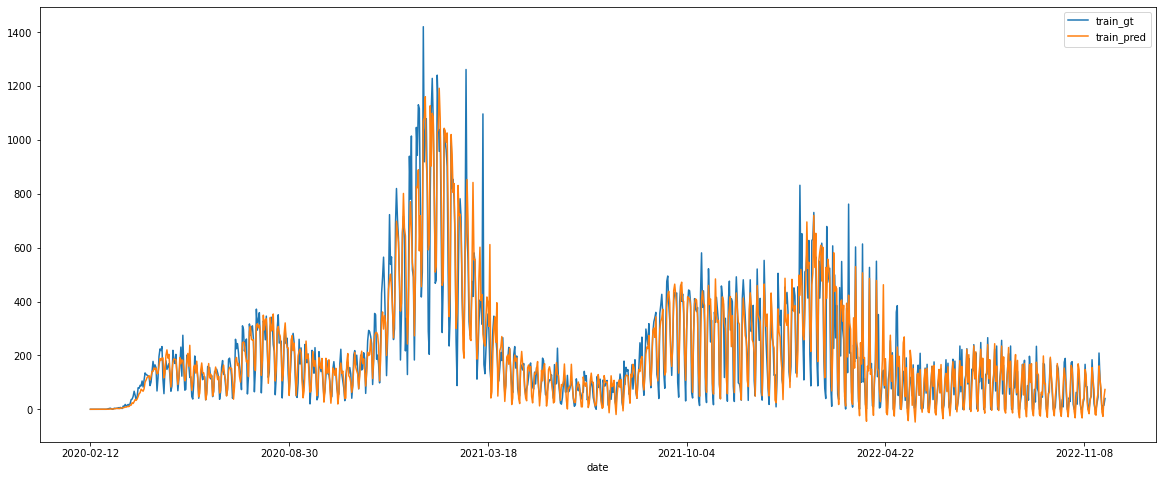

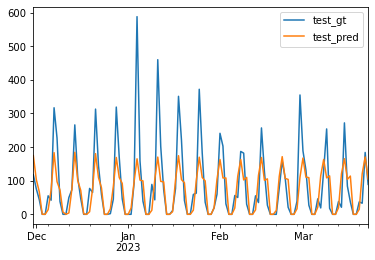

Training Set Metrics:
MAE: 50.293666644387564
MASE: 0.500554009747136

Testing Set Metrics:
MAE: 47.580600577937126
MASE: 0.531863474656929


In [1220]:
train_pred=model.fittedvalues
pd.concat([west_train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])
plt.show()

west_test.index = pd.to_datetime(west_test.index)

test_pred=model.predict(start=len(west_train), end=len(west_train)+len(west_test)-1, dynamic=True)
test_pred[test_pred<0] = 0
pd.concat([west_test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])
plt.show()

# Calculate R-squared, MAE for the training set
mae_train = mean_absolute_error(west_train, train_pred)
mase_train = MASE(west_train, train_pred)

print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)

# Calculate RMSE, R-squared, and MAE for the testing set
mae_test = mean_absolute_error(west_test, test_pred)
mase_test = MASE(west_test, test_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)